In [1]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix
from scipy.interpolate import interp1d
from scipy.spatial import distance
from tqdm import tqdm

In [2]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# 랜드마크 인덱스 정의 # 11개
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]

In [4]:
# # 데이터 증강 함수 정의
# def augment_sequence(sequence, factor=0.2):
#     time_warped = []
#     for landmark in sequence:
#         x = np.arange(len(landmark))
#         f = interp1d(x, landmark, kind='linear', axis=0)
#         x_new = np.linspace(0, len(landmark) - 1, num=int(len(landmark) * (1 + factor)))
#         time_warped.append(f(x_new))
#     return np.array(time_warped)

In [5]:
# 바운딩 박스 비율 클래스 정의 함수
def bbox_ratio_class(ratio):
    if ratio < 0.7:
        return 0  # Normal 가능성 높은 class
    else:
        return 1  # Danger or Fall 가능성 높은 class

# YOLO xy 비율 계산 함수
def calculate_yolo_xy_ratio(frame):
    bbox = frame.get('bbox', None)
    if bbox and (bbox['x2'] - bbox['x1']) != 0:
        yolo_xy_ratio = round((bbox['y2'] - bbox['y1']) / (bbox['x2'] - bbox['x1']), 3)
    else:
        yolo_xy_ratio = 0.0
    return yolo_xy_ratio

In [6]:
# 머리 및 상체 속도 계산 함수 (시퀀스 평균값 사용)
def calculate_head_upper_body_speed(sequence):
    speeds = []
    for j in range(1, len(sequence)):
        keypoints = sequence[j]
        prev_keypoints = sequence[j - 1]
        h = np.array([keypoints.get(f'landmark_0', {}).get('x', 0.0), keypoints.get(f'landmark_0', {}).get('y', 0.0)])
        l = np.array([keypoints.get(f'landmark_11', {}).get('x', 0.0), keypoints.get(f'landmark_11', {}).get('y', 0.0)])
        r = np.array([keypoints.get(f'landmark_12', {}).get('x', 0.0), keypoints.get(f'landmark_12', {}).get('y', 0.0)])

        # 이전 프레임의 좌표
        prev_h = np.array([prev_keypoints.get(f'landmark_0', {}).get('x', 0.0), prev_keypoints.get(f'landmark_0', {}).get('y', 0.0)])
        prev_l = np.array([prev_keypoints.get(f'landmark_11', {}).get('x', 0.0), prev_keypoints.get(f'landmark_11', {}).get('y', 0.0)])
        prev_r = np.array([prev_keypoints.get(f'landmark_12', {}).get('x', 0.0), prev_keypoints.get(f'landmark_12', {}).get('y', 0.0)])

        # 현재 프레임과 이전 프레임의 상체 중심
        center_new = (h + l + r) / 3
        center_prev = (prev_h + prev_l + prev_r) / 3

        # 유클리드 거리 계산 (6프레임당 일정하므로 속력이라 봐도 무방함)
        dist_new = distance.euclidean(center_new, center_prev)
        speeds.append(dist_new)

    # 평균 속력 계산
    if speeds:
        return sum(speeds) / len(speeds)
    else:
        return 0.0

In [7]:
# 데이터셋 클래스 정의
# 현재 input은 mediapipe의 관절 좌표값 22개 + YOLO xy ratio + bbox_ratio_class + 머리/상체 속도 => 25개
class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3, input_config='full'):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        # self.scaler = StandardScaler()
        self.input_config = input_config

        all_landmarks = []

        for json_file in tqdm(json_files, desc="Processing JSON files"):
            with open(json_file, 'r') as f:
                data = json.load(f)

            frames = list(data['pose_data'].values())

            for i in range(0, len(frames) - self.sequence_length + 1, self.sequence_length):
                sequence = frames[i:i + self.sequence_length]
                landmarks = []

                # YOLO xy ratio 및 바운딩 박스 클래스는 시퀀스마다 1개씩만 추가
                yolo_xy_ratio = calculate_yolo_xy_ratio(sequence[-1])  # 마지막 프레임 기준으로 계산
                ratio_class = bbox_ratio_class(yolo_xy_ratio)
                head_torso_speed = calculate_head_upper_body_speed(sequence)

                for j, frame in enumerate(sequence):
                    frame_landmarks = []
                    if frame is not None:
                        if self.input_config in ['full', 'mediapipe']:
                            for landmark in LANDMARKS:
                                landmark_data = frame.get(f'landmark_{landmark}', None)
                                if landmark_data:
                                    frame_landmarks.extend([
                                        round(landmark_data['x'], 3),  # 소수점 세 자리로 반올림
                                        round(landmark_data['y'], 3)
                                    ])
                                else:
                                    frame_landmarks.extend([0.0, 0.0])

                        if self.input_config in ['full', 'simplified']:
                            # YOLO xy ratio, 바운딩 박스 클래스, 머리/상체 속도 추가 (시퀀스 단위로 동일 값 사용)
                            frame_landmarks.append(yolo_xy_ratio)
                            frame_landmarks.append(ratio_class)
                            frame_landmarks.append(head_torso_speed)
                    
                    landmarks.append(frame_landmarks)

                # 데이터 증강 없이 원래 데이터를 사용
                all_landmarks.extend(landmarks)

                # 레이블 재정의
                if sequence[-1]['class'] == 'Normal':
                    label = 0  # 비낙상
                elif sequence[-1]['class'] == 'Danger':
                    label = 1  # 낙상 위험
                elif sequence[-1]['class'] == 'Fall':
                    label = 2  # 완전 낙상

                self.sequences.append(landmarks)
                self.labels.append(label)

        # # 전체 데이터 정규화
        # all_landmarks = np.array(all_landmarks)
        # all_landmarks_scaled = self.scaler.fit_transform(all_landmarks)

        # # 정규화된 데이터를 다시 시퀀스로 재구성
        # for i in range(len(self.sequences)):
        #     start = i * self.sequence_length
        #     end = start + self.sequence_length
        #     self.sequences[i] = all_landmarks_scaled[start:end]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.LongTensor([self.labels[idx]]).squeeze()

In [8]:
# GRU 기반 낙상 감지 모델 정의
class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=3):
        super(FallDetectionGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(2, x.size(0), 128).to(x.device)  # 초기 은닉 상태 정의
        out, _ = self.gru(x, h_0)
        out = self.fc(out[:, -1, :])  # 마지막 time step의 출력을 사용
        return out

In [9]:
# 검증 및 테스트 데이터셋 로드 경로
train_json_folder = r'D:\Falldown\Dataset\Video_Dataset\Json_combined\Train'
valid_json_folder = r'D:\Falldown\Dataset\Video_Dataset\Json_combined\Val'
test_json_folder = r'D:\Falldown\Dataset\Video_Dataset\Json_combined\Test'

# 각 데이터 폴더에서 JSON 파일 목록 생성
train_json_files = [os.path.join(train_json_folder, f) for f in os.listdir(train_json_folder) if f.endswith('.json')]
valid_json_files = [os.path.join(valid_json_folder, f) for f in os.listdir(valid_json_folder) if f.endswith('.json')]
test_json_files = [os.path.join(test_json_folder, f) for f in os.listdir(test_json_folder) if f.endswith('.json')]

# 데이터셋 생성 (입력 데이터 설정에 따라)
train_full_dataset = FallSequenceDataset(train_json_files, input_config='full')
valid_full_dataset = FallSequenceDataset(valid_json_files, input_config='full')
test_full_dataset = FallSequenceDataset(test_json_files, input_config='full')

train_simplified_dataset = FallSequenceDataset(train_json_files, input_config='simplified')
valid_simplified_dataset = FallSequenceDataset(valid_json_files, input_config='simplified')
test_simplified_dataset = FallSequenceDataset(test_json_files, input_config='simplified')

train_mediapipe_dataset = FallSequenceDataset(train_json_files, input_config='mediapipe')
valid_mediapipe_dataset = FallSequenceDataset(valid_json_files, input_config='mediapipe')
test_mediapipe_dataset = FallSequenceDataset(test_json_files, input_config='mediapipe')

# 데이터 로더 생성
train_loader_full = DataLoader(train_full_dataset, batch_size=32, shuffle=True)
valid_loader_full = DataLoader(valid_full_dataset, batch_size=32, shuffle=False)
test_loader_full = DataLoader(test_full_dataset, batch_size=32, shuffle=False)

train_loader_simplified = DataLoader(train_simplified_dataset, batch_size=32, shuffle=True)
valid_loader_simplified = DataLoader(valid_simplified_dataset, batch_size=32, shuffle=False)
test_loader_simplified = DataLoader(test_simplified_dataset, batch_size=32, shuffle=False)

train_loader_mediapipe = DataLoader(train_mediapipe_dataset, batch_size=32, shuffle=True)
valid_loader_mediapipe = DataLoader(valid_mediapipe_dataset, batch_size=32, shuffle=False)
test_loader_mediapipe = DataLoader(test_mediapipe_dataset, batch_size=32, shuffle=False)

Processing JSON files: 100%|██████████| 397/397 [00:01<00:00, 306.95it/s]


In [10]:
# 클래스 가중치 계산 및 손실 함수 정의 (훈련 데이터셋 기준)
class_weights = compute_class_weight('balanced', classes=np.unique(train_full_dataset.labels), y=train_full_dataset.labels)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 모델 준비
def create_model_for_dataset(dataset):
    if len(dataset) > 0:
        sample_sequence, sample_label = dataset[0]
        input_size = len(sample_sequence[0])  # 시퀀스 내의 각 프레임에서 입력의 길이를 가져옴
        return FallDetectionGRU(input_size).to(device)
    else:
        print("데이터 없음")
        exit()

# 학습 파라미터 설정
num_epochs = 500
best_loss = float('inf')
patience = 50
no_improve = 0

In [11]:
# 학습 루프
for train_loader, valid_loader, model_name, dataset, lr in [
    (train_loader_full, valid_loader_full, 'best_fall_detection_gru_0001_full.pt', train_full_dataset, 0.0001),
    (train_loader_full, valid_loader_full, 'best_fall_detection_gru_001_full.pt', train_full_dataset, 0.001),
    (train_loader_simplified, valid_loader_simplified, 'best_fall_detection_gru_0001_simplified.pt', train_simplified_dataset, 0.0001),
    (train_loader_simplified, valid_loader_simplified, 'best_fall_detection_gru_001_simplified.pt', train_simplified_dataset, 0.001),
    (train_loader_mediapipe, valid_loader_mediapipe, 'best_fall_detection_gru_0001_mediapipe.pt', train_mediapipe_dataset, 0.0001),
    (train_loader_mediapipe, valid_loader_mediapipe, 'best_fall_detection_gru_001_mediapipe.pt', train_mediapipe_dataset, 0.001)
]:
    # 모델을 새로 생성
    model = create_model_for_dataset(dataset)
    model.to(device)

    # 옵티마이저와 스케줄러 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0
    
    print(f"{model_name} 학습 시작", flush=True)
    print("\n" + "=" * 20 + f" Training Configuration: GRU with input_config='{train_loader.dataset.input_config}' and lr='{optimizer.param_groups[0]['lr']}' " + "=" * 20 + "\n")

    # 입력 크기 체크 (훈련 시작 시 1회만 출력)
    sequences, labels = next(iter(train_loader))
    print(f'현재 입력 크기 (마지막 차원): {sequences.size(-1)}')
    print(f'예상 입력 크기: {model.gru.input_size}')

    for epoch in range(num_epochs):
        model.train()
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()
            
            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}')

        # 검증 데이터셋 평가
        model.eval()
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), model_name)
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

best_fall_detection_gru_0001_full.pt 학습 시작

==================== Training Configuration: GRU with input_config='full' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 25
예상 입력 크기: 25


Epoch 1/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.17it/s]


Epoch [1/500], Train Loss: 0.7677
Epoch [1/500], Valid Loss: 0.7100


Epoch 2/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.93it/s]


Epoch [2/500], Train Loss: 0.6631
Epoch [2/500], Valid Loss: 0.6022


Epoch 3/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.63it/s]


Epoch [3/500], Train Loss: 0.5846
Epoch [3/500], Valid Loss: 0.5522


Epoch 4/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.59it/s]


Epoch [4/500], Train Loss: 0.5413
Epoch [4/500], Valid Loss: 0.5712


Epoch 5/500: 100%|██████████| 1972/1972 [00:05<00:00, 389.98it/s]


Epoch [5/500], Train Loss: 0.5092
Epoch [5/500], Valid Loss: 0.4811


Epoch 6/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.52it/s]


Epoch [6/500], Train Loss: 0.4878
Epoch [6/500], Valid Loss: 0.4799


Epoch 7/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.01it/s]


Epoch [7/500], Train Loss: 0.4774
Epoch [7/500], Valid Loss: 0.4501


Epoch 8/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.41it/s]


Epoch [8/500], Train Loss: 0.4671
Epoch [8/500], Valid Loss: 0.4702


Epoch 9/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.68it/s]


Epoch [9/500], Train Loss: 0.4626
Epoch [9/500], Valid Loss: 0.4510


Epoch 10/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.73it/s]


Epoch [10/500], Train Loss: 0.4560
Epoch [10/500], Valid Loss: 0.4364


Epoch 11/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.15it/s]


Epoch [11/500], Train Loss: 0.4507
Epoch [11/500], Valid Loss: 0.4355


Epoch 12/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.54it/s]


Epoch [12/500], Train Loss: 0.4494
Epoch [12/500], Valid Loss: 0.5109


Epoch 13/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.76it/s]


Epoch [13/500], Train Loss: 0.4417
Epoch [13/500], Valid Loss: 0.4214


Epoch 14/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.24it/s]


Epoch [14/500], Train Loss: 0.4402
Epoch [14/500], Valid Loss: 0.4500


Epoch 15/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.26it/s]


Epoch [15/500], Train Loss: 0.4371
Epoch [15/500], Valid Loss: 0.4299


Epoch 16/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.66it/s]


Epoch [16/500], Train Loss: 0.4343
Epoch [16/500], Valid Loss: 0.4289


Epoch 17/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.95it/s]


Epoch [17/500], Train Loss: 0.4304
Epoch [17/500], Valid Loss: 0.4411


Epoch 18/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.96it/s]


Epoch [18/500], Train Loss: 0.4257
Epoch [18/500], Valid Loss: 0.4345


Epoch 19/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.92it/s]


Epoch [19/500], Train Loss: 0.4249
Epoch [19/500], Valid Loss: 0.4120


Epoch 20/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.37it/s]


Epoch [20/500], Train Loss: 0.4220
Epoch [20/500], Valid Loss: 0.4473


Epoch 21/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.22it/s]


Epoch [21/500], Train Loss: 0.4242
Epoch [21/500], Valid Loss: 0.4059


Epoch 22/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.49it/s]


Epoch [22/500], Train Loss: 0.4199
Epoch [22/500], Valid Loss: 0.4023


Epoch 23/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.49it/s]


Epoch [23/500], Train Loss: 0.4175
Epoch [23/500], Valid Loss: 0.4184


Epoch 24/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.12it/s]


Epoch [24/500], Train Loss: 0.4159
Epoch [24/500], Valid Loss: 0.4071


Epoch 25/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.73it/s]


Epoch [25/500], Train Loss: 0.4143
Epoch [25/500], Valid Loss: 0.4158


Epoch 26/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.23it/s]


Epoch [26/500], Train Loss: 0.4136
Epoch [26/500], Valid Loss: 0.3985


Epoch 27/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.77it/s]


Epoch [27/500], Train Loss: 0.4120
Epoch [27/500], Valid Loss: 0.4087


Epoch 28/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.67it/s]


Epoch [28/500], Train Loss: 0.4097
Epoch [28/500], Valid Loss: 0.4176


Epoch 29/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.87it/s]


Epoch [29/500], Train Loss: 0.4093
Epoch [29/500], Valid Loss: 0.4024


Epoch 30/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.32it/s]


Epoch [30/500], Train Loss: 0.4071
Epoch [30/500], Valid Loss: 0.4006


Epoch 31/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.30it/s]


Epoch [31/500], Train Loss: 0.4074
Epoch [31/500], Valid Loss: 0.4078


Epoch 32/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.97it/s]


Epoch [32/500], Train Loss: 0.4056
Epoch [32/500], Valid Loss: 0.4403


Epoch 33/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.55it/s]


Epoch [33/500], Train Loss: 0.3920
Epoch [33/500], Valid Loss: 0.3945


Epoch 34/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.99it/s]


Epoch [34/500], Train Loss: 0.3911
Epoch [34/500], Valid Loss: 0.3913


Epoch 35/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.75it/s]


Epoch [35/500], Train Loss: 0.3907
Epoch [35/500], Valid Loss: 0.3982


Epoch 36/500: 100%|██████████| 1972/1972 [00:05<00:00, 383.54it/s]


Epoch [36/500], Train Loss: 0.3915
Epoch [36/500], Valid Loss: 0.3900


Epoch 37/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.37it/s]


Epoch [37/500], Train Loss: 0.3903
Epoch [37/500], Valid Loss: 0.3891


Epoch 38/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.99it/s]


Epoch [38/500], Train Loss: 0.3916
Epoch [38/500], Valid Loss: 0.3937


Epoch 39/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.39it/s]


Epoch [39/500], Train Loss: 0.3903
Epoch [39/500], Valid Loss: 0.3895


Epoch 40/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.95it/s]


Epoch [40/500], Train Loss: 0.3903
Epoch [40/500], Valid Loss: 0.3910


Epoch 41/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.78it/s]


Epoch [41/500], Train Loss: 0.3900
Epoch [41/500], Valid Loss: 0.3919


Epoch 42/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.84it/s]


Epoch [42/500], Train Loss: 0.3902
Epoch [42/500], Valid Loss: 0.3915


Epoch 43/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.05it/s]


Epoch [43/500], Train Loss: 0.3890
Epoch [43/500], Valid Loss: 0.3893


Epoch 44/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.28it/s]


Epoch [44/500], Train Loss: 0.3887
Epoch [44/500], Valid Loss: 0.3889


Epoch 45/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.25it/s]


Epoch [45/500], Train Loss: 0.3876
Epoch [45/500], Valid Loss: 0.3887


Epoch 46/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.04it/s]


Epoch [46/500], Train Loss: 0.3871
Epoch [46/500], Valid Loss: 0.3895


Epoch 47/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.29it/s]


Epoch [47/500], Train Loss: 0.3882
Epoch [47/500], Valid Loss: 0.3894


Epoch 48/500: 100%|██████████| 1972/1972 [00:05<00:00, 359.30it/s]


Epoch [48/500], Train Loss: 0.3879
Epoch [48/500], Valid Loss: 0.3889


Epoch 49/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.65it/s]


Epoch [49/500], Train Loss: 0.3887
Epoch [49/500], Valid Loss: 0.3886


Epoch 50/500: 100%|██████████| 1972/1972 [00:04<00:00, 394.63it/s]


Epoch [50/500], Train Loss: 0.3871
Epoch [50/500], Valid Loss: 0.3891


Epoch 51/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.40it/s]


Epoch [51/500], Train Loss: 0.3874
Epoch [51/500], Valid Loss: 0.3887


Epoch 52/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.47it/s]


Epoch [52/500], Train Loss: 0.3874
Epoch [52/500], Valid Loss: 0.3884


Epoch 53/500: 100%|██████████| 1972/1972 [00:04<00:00, 394.50it/s]


Epoch [53/500], Train Loss: 0.3881
Epoch [53/500], Valid Loss: 0.3888


Epoch 54/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.68it/s]


Epoch [54/500], Train Loss: 0.3882
Epoch [54/500], Valid Loss: 0.3885


Epoch 55/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.54it/s]


Epoch [55/500], Train Loss: 0.3886
Epoch [55/500], Valid Loss: 0.3890


Epoch 56/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.16it/s]


Epoch [56/500], Train Loss: 0.3877
Epoch [56/500], Valid Loss: 0.3882


Epoch 57/500: 100%|██████████| 1972/1972 [00:05<00:00, 386.08it/s]


Epoch [57/500], Train Loss: 0.3887
Epoch [57/500], Valid Loss: 0.3884


Epoch 58/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.93it/s]


Epoch [58/500], Train Loss: 0.3878
Epoch [58/500], Valid Loss: 0.3887


Epoch 59/500: 100%|██████████| 1972/1972 [00:04<00:00, 394.60it/s]


Epoch [59/500], Train Loss: 0.3873
Epoch [59/500], Valid Loss: 0.3882


Epoch 60/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.63it/s]


Epoch [60/500], Train Loss: 0.3883
Epoch [60/500], Valid Loss: 0.3886


Epoch 61/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.10it/s]


Epoch [61/500], Train Loss: 0.3872
Epoch [61/500], Valid Loss: 0.3887


Epoch 62/500: 100%|██████████| 1972/1972 [00:05<00:00, 391.85it/s]


Epoch [62/500], Train Loss: 0.3873
Epoch [62/500], Valid Loss: 0.3884


Epoch 63/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.05it/s]


Epoch [63/500], Train Loss: 0.3884
Epoch [63/500], Valid Loss: 0.3884


Epoch 64/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.23it/s]


Epoch [64/500], Train Loss: 0.3869
Epoch [64/500], Valid Loss: 0.3885


Epoch 65/500: 100%|██████████| 1972/1972 [00:05<00:00, 394.24it/s]


Epoch [65/500], Train Loss: 0.3875
Epoch [65/500], Valid Loss: 0.3885


Epoch 66/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.11it/s]


Epoch [66/500], Train Loss: 0.3876
Epoch [66/500], Valid Loss: 0.3885


Epoch 67/500: 100%|██████████| 1972/1972 [00:05<00:00, 390.57it/s]


Epoch [67/500], Train Loss: 0.3870
Epoch [67/500], Valid Loss: 0.3885


Epoch 68/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.83it/s]


Epoch [68/500], Train Loss: 0.3866
Epoch [68/500], Valid Loss: 0.3885


Epoch 69/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.91it/s]


Epoch [69/500], Train Loss: 0.3871
Epoch [69/500], Valid Loss: 0.3885


Epoch 70/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.22it/s]


Epoch [70/500], Train Loss: 0.3873
Epoch [70/500], Valid Loss: 0.3885


Epoch 71/500: 100%|██████████| 1972/1972 [00:05<00:00, 392.58it/s]


Epoch [71/500], Train Loss: 0.3871
Epoch [71/500], Valid Loss: 0.3885


Epoch 72/500: 100%|██████████| 1972/1972 [00:05<00:00, 393.67it/s]


Epoch [72/500], Train Loss: 0.3869
Epoch [72/500], Valid Loss: 0.3885


Epoch 73/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.64it/s]


Epoch [73/500], Train Loss: 0.3864
Epoch [73/500], Valid Loss: 0.3885


Epoch 74/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.28it/s]


Epoch [74/500], Train Loss: 0.3875
Epoch [74/500], Valid Loss: 0.3885


Epoch 75/500: 100%|██████████| 1972/1972 [00:04<00:00, 394.93it/s]


Epoch [75/500], Train Loss: 0.3873
Epoch [75/500], Valid Loss: 0.3885


Epoch 76/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.08it/s]


Epoch [76/500], Train Loss: 0.3883
Epoch [76/500], Valid Loss: 0.3885


Epoch 77/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.41it/s]


Epoch [77/500], Train Loss: 0.3872
Epoch [77/500], Valid Loss: 0.3885


Epoch 78/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.76it/s]


Epoch [78/500], Train Loss: 0.3884
Epoch [78/500], Valid Loss: 0.3885


Epoch 79/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.82it/s]


Epoch [79/500], Train Loss: 0.3868
Epoch [79/500], Valid Loss: 0.3885


Epoch 80/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.58it/s]


Epoch [80/500], Train Loss: 0.3860
Epoch [80/500], Valid Loss: 0.3885


Epoch 81/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.88it/s]


Epoch [81/500], Train Loss: 0.3877
Epoch [81/500], Valid Loss: 0.3885


Epoch 82/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.56it/s]


Epoch [82/500], Train Loss: 0.3881
Epoch [82/500], Valid Loss: 0.3885


Epoch 83/500: 100%|██████████| 1972/1972 [00:04<00:00, 397.86it/s]


Epoch [83/500], Train Loss: 0.3872
Epoch [83/500], Valid Loss: 0.3885


Epoch 84/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.66it/s]


Epoch [84/500], Train Loss: 0.3872
Epoch [84/500], Valid Loss: 0.3885


Epoch 85/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.19it/s]


Epoch [85/500], Train Loss: 0.3875
Epoch [85/500], Valid Loss: 0.3885


Epoch 86/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.93it/s]


Epoch [86/500], Train Loss: 0.3871
Epoch [86/500], Valid Loss: 0.3885


Epoch 87/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.80it/s]


Epoch [87/500], Train Loss: 0.3882
Epoch [87/500], Valid Loss: 0.3885


Epoch 88/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.97it/s]


Epoch [88/500], Train Loss: 0.3876
Epoch [88/500], Valid Loss: 0.3885


Epoch 89/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.42it/s]


Epoch [89/500], Train Loss: 0.3878
Epoch [89/500], Valid Loss: 0.3885


Epoch 90/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.89it/s]


Epoch [90/500], Train Loss: 0.3874
Epoch [90/500], Valid Loss: 0.3885


Epoch 91/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.80it/s]


Epoch [91/500], Train Loss: 0.3872
Epoch [91/500], Valid Loss: 0.3885


Epoch 92/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.11it/s]


Epoch [92/500], Train Loss: 0.3863
Epoch [92/500], Valid Loss: 0.3885


Epoch 93/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.32it/s]


Epoch [93/500], Train Loss: 0.3873
Epoch [93/500], Valid Loss: 0.3885


Epoch 94/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.05it/s]


Epoch [94/500], Train Loss: 0.3882
Epoch [94/500], Valid Loss: 0.3885


Epoch 95/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.26it/s]


Epoch [95/500], Train Loss: 0.3876
Epoch [95/500], Valid Loss: 0.3885


Epoch 96/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.77it/s]


Epoch [96/500], Train Loss: 0.3870
Epoch [96/500], Valid Loss: 0.3885


Epoch 97/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.37it/s]


Epoch [97/500], Train Loss: 0.3870
Epoch [97/500], Valid Loss: 0.3885


Epoch 98/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.26it/s]


Epoch [98/500], Train Loss: 0.3869
Epoch [98/500], Valid Loss: 0.3885


Epoch 99/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.56it/s]


Epoch [99/500], Train Loss: 0.3876
Epoch [99/500], Valid Loss: 0.3885


Epoch 100/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.03it/s]


Epoch [100/500], Train Loss: 0.3880
Epoch [100/500], Valid Loss: 0.3885


Epoch 101/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.87it/s]


Epoch [101/500], Train Loss: 0.3872
Epoch [101/500], Valid Loss: 0.3885


Epoch 102/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.58it/s]


Epoch [102/500], Train Loss: 0.3862
Epoch [102/500], Valid Loss: 0.3885


Epoch 103/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.80it/s]


Epoch [103/500], Train Loss: 0.3873
Epoch [103/500], Valid Loss: 0.3885


Epoch 104/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.05it/s]


Epoch [104/500], Train Loss: 0.3874
Epoch [104/500], Valid Loss: 0.3885


Epoch 105/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.98it/s]


Epoch [105/500], Train Loss: 0.3870
Epoch [105/500], Valid Loss: 0.3885


Epoch 106/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.82it/s]


Epoch [106/500], Train Loss: 0.3872
Epoch [106/500], Valid Loss: 0.3885


Epoch 107/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.65it/s]


Epoch [107/500], Train Loss: 0.3872
Epoch [107/500], Valid Loss: 0.3885


Epoch 108/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.47it/s]


Epoch [108/500], Train Loss: 0.3867
Epoch [108/500], Valid Loss: 0.3885


Epoch 109/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.37it/s]


Epoch [109/500], Train Loss: 0.3875
Epoch [109/500], Valid Loss: 0.3885
Early stopping
best_fall_detection_gru_001_full.pt 학습 시작

==================== Training Configuration: GRU with input_config='full' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 25
예상 입력 크기: 25


Epoch 1/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.40it/s]


Epoch [1/500], Train Loss: 0.6421
Epoch [1/500], Valid Loss: 0.5051


Epoch 2/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.56it/s]


Epoch [2/500], Train Loss: 0.4984
Epoch [2/500], Valid Loss: 0.4889


Epoch 3/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.44it/s]


Epoch [3/500], Train Loss: 0.4689
Epoch [3/500], Valid Loss: 0.4273


Epoch 4/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.83it/s]


Epoch [4/500], Train Loss: 0.4565
Epoch [4/500], Valid Loss: 0.4585


Epoch 5/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.05it/s]


Epoch [5/500], Train Loss: 0.4441
Epoch [5/500], Valid Loss: 0.4072


Epoch 6/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.60it/s]


Epoch [6/500], Train Loss: 0.4324
Epoch [6/500], Valid Loss: 0.4224


Epoch 7/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.06it/s]


Epoch [7/500], Train Loss: 0.4218
Epoch [7/500], Valid Loss: 0.3980


Epoch 8/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.00it/s]


Epoch [8/500], Train Loss: 0.4155
Epoch [8/500], Valid Loss: 0.4198


Epoch 9/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.81it/s]


Epoch [9/500], Train Loss: 0.4098
Epoch [9/500], Valid Loss: 0.3861


Epoch 10/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.71it/s]


Epoch [10/500], Train Loss: 0.4025
Epoch [10/500], Valid Loss: 0.3923


Epoch 11/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.99it/s]


Epoch [11/500], Train Loss: 0.3973
Epoch [11/500], Valid Loss: 0.3895


Epoch 12/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.78it/s]


Epoch [12/500], Train Loss: 0.3978
Epoch [12/500], Valid Loss: 0.3752


Epoch 13/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.53it/s]


Epoch [13/500], Train Loss: 0.3915
Epoch [13/500], Valid Loss: 0.3913


Epoch 14/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.40it/s]


Epoch [14/500], Train Loss: 0.3899
Epoch [14/500], Valid Loss: 0.4163


Epoch 15/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.39it/s]


Epoch [15/500], Train Loss: 0.3863
Epoch [15/500], Valid Loss: 0.3801


Epoch 16/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.18it/s]


Epoch [16/500], Train Loss: 0.3850
Epoch [16/500], Valid Loss: 0.3947


Epoch 17/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.77it/s]


Epoch [17/500], Train Loss: 0.3778
Epoch [17/500], Valid Loss: 0.3695


Epoch 18/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.26it/s]


Epoch [18/500], Train Loss: 0.3752
Epoch [18/500], Valid Loss: 0.4074


Epoch 19/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.44it/s]


Epoch [19/500], Train Loss: 0.3697
Epoch [19/500], Valid Loss: 0.4076


Epoch 20/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.86it/s]


Epoch [20/500], Train Loss: 0.3675
Epoch [20/500], Valid Loss: 0.3616


Epoch 21/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.16it/s]


Epoch [21/500], Train Loss: 0.3627
Epoch [21/500], Valid Loss: 0.3503


Epoch 22/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.14it/s]


Epoch [22/500], Train Loss: 0.3635
Epoch [22/500], Valid Loss: 0.3672


Epoch 23/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.00it/s]


Epoch [23/500], Train Loss: 0.3564
Epoch [23/500], Valid Loss: 0.3607


Epoch 24/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.55it/s]


Epoch [24/500], Train Loss: 0.3588
Epoch [24/500], Valid Loss: 0.3978


Epoch 25/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.66it/s]


Epoch [25/500], Train Loss: 0.3578
Epoch [25/500], Valid Loss: 0.3909


Epoch 26/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.60it/s]


Epoch [26/500], Train Loss: 0.3503
Epoch [26/500], Valid Loss: 0.3460


Epoch 27/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.83it/s]


Epoch [27/500], Train Loss: 0.3456
Epoch [27/500], Valid Loss: 0.3520


Epoch 28/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.71it/s]


Epoch [28/500], Train Loss: 0.3431
Epoch [28/500], Valid Loss: 0.3638


Epoch 29/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.61it/s]


Epoch [29/500], Train Loss: 0.3416
Epoch [29/500], Valid Loss: 0.3284


Epoch 30/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.56it/s]


Epoch [30/500], Train Loss: 0.3409
Epoch [30/500], Valid Loss: 0.3631


Epoch 31/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.73it/s]


Epoch [31/500], Train Loss: 0.3377
Epoch [31/500], Valid Loss: 0.3717


Epoch 32/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.22it/s]


Epoch [32/500], Train Loss: 0.3362
Epoch [32/500], Valid Loss: 0.3283


Epoch 33/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.16it/s]


Epoch [33/500], Train Loss: 0.3340
Epoch [33/500], Valid Loss: 0.3791


Epoch 34/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.59it/s]


Epoch [34/500], Train Loss: 0.3297
Epoch [34/500], Valid Loss: 0.3611


Epoch 35/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.37it/s]


Epoch [35/500], Train Loss: 0.3275
Epoch [35/500], Valid Loss: 0.3463


Epoch 36/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.84it/s]


Epoch [36/500], Train Loss: 0.3235
Epoch [36/500], Valid Loss: 0.3158


Epoch 37/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.48it/s]


Epoch [37/500], Train Loss: 0.3220
Epoch [37/500], Valid Loss: 0.3245


Epoch 38/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.27it/s]


Epoch [38/500], Train Loss: 0.3175
Epoch [38/500], Valid Loss: 0.3367


Epoch 39/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.13it/s]


Epoch [39/500], Train Loss: 0.3106
Epoch [39/500], Valid Loss: 0.3241


Epoch 40/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.50it/s]


Epoch [40/500], Train Loss: 0.3131
Epoch [40/500], Valid Loss: 0.3244


Epoch 41/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.06it/s]


Epoch [41/500], Train Loss: 0.3107
Epoch [41/500], Valid Loss: 0.3423


Epoch 42/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.39it/s]


Epoch [42/500], Train Loss: 0.3073
Epoch [42/500], Valid Loss: 0.3110


Epoch 43/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.36it/s]


Epoch [43/500], Train Loss: 0.2995
Epoch [43/500], Valid Loss: 0.3188


Epoch 44/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.72it/s]


Epoch [44/500], Train Loss: 0.2972
Epoch [44/500], Valid Loss: 0.3088


Epoch 45/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.48it/s]


Epoch [45/500], Train Loss: 0.2945
Epoch [45/500], Valid Loss: 0.3493


Epoch 46/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.66it/s]


Epoch [46/500], Train Loss: 0.2903
Epoch [46/500], Valid Loss: 0.3083


Epoch 47/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.04it/s]


Epoch [47/500], Train Loss: 0.2877
Epoch [47/500], Valid Loss: 0.3289


Epoch 48/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.40it/s]


Epoch [48/500], Train Loss: 0.2829
Epoch [48/500], Valid Loss: 0.2870


Epoch 49/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.27it/s]


Epoch [49/500], Train Loss: 0.2793
Epoch [49/500], Valid Loss: 0.2898


Epoch 50/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.34it/s]


Epoch [50/500], Train Loss: 0.2754
Epoch [50/500], Valid Loss: 0.2849


Epoch 51/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.29it/s]


Epoch [51/500], Train Loss: 0.2742
Epoch [51/500], Valid Loss: 0.3050


Epoch 52/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.86it/s]


Epoch [52/500], Train Loss: 0.2663
Epoch [52/500], Valid Loss: 0.2713


Epoch 53/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.69it/s]


Epoch [53/500], Train Loss: 0.2629
Epoch [53/500], Valid Loss: 0.2816


Epoch 54/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.30it/s]


Epoch [54/500], Train Loss: 0.2625
Epoch [54/500], Valid Loss: 0.4240


Epoch 55/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.37it/s]


Epoch [55/500], Train Loss: 0.2586
Epoch [55/500], Valid Loss: 0.2657


Epoch 56/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.91it/s]


Epoch [56/500], Train Loss: 0.2526
Epoch [56/500], Valid Loss: 0.2789


Epoch 57/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.61it/s]


Epoch [57/500], Train Loss: 0.2520
Epoch [57/500], Valid Loss: 0.2816


Epoch 58/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.18it/s]


Epoch [58/500], Train Loss: 0.2473
Epoch [58/500], Valid Loss: 0.2653


Epoch 59/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.43it/s]


Epoch [59/500], Train Loss: 0.2414
Epoch [59/500], Valid Loss: 0.2548


Epoch 60/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.70it/s]


Epoch [60/500], Train Loss: 0.2368
Epoch [60/500], Valid Loss: 0.2507


Epoch 61/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.53it/s]


Epoch [61/500], Train Loss: 0.2357
Epoch [61/500], Valid Loss: 0.2425


Epoch 62/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.30it/s]


Epoch [62/500], Train Loss: 0.2313
Epoch [62/500], Valid Loss: 0.2294


Epoch 63/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.86it/s]


Epoch [63/500], Train Loss: 0.2238
Epoch [63/500], Valid Loss: 0.2663


Epoch 64/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.15it/s]


Epoch [64/500], Train Loss: 0.2246
Epoch [64/500], Valid Loss: 0.2528


Epoch 65/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.92it/s]


Epoch [65/500], Train Loss: 0.2249
Epoch [65/500], Valid Loss: 0.2566


Epoch 66/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.51it/s]


Epoch [66/500], Train Loss: 0.2165
Epoch [66/500], Valid Loss: 0.2441


Epoch 67/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.69it/s]


Epoch [67/500], Train Loss: 0.2082
Epoch [67/500], Valid Loss: 0.2289


Epoch 68/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.48it/s]


Epoch [68/500], Train Loss: 0.2080
Epoch [68/500], Valid Loss: 0.2316


Epoch 69/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.68it/s]


Epoch [69/500], Train Loss: 0.2071
Epoch [69/500], Valid Loss: 0.2224


Epoch 70/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.90it/s]


Epoch [70/500], Train Loss: 0.2008
Epoch [70/500], Valid Loss: 0.2246


Epoch 71/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.59it/s]


Epoch [71/500], Train Loss: 0.2023
Epoch [71/500], Valid Loss: 0.2294


Epoch 72/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.73it/s]


Epoch [72/500], Train Loss: 0.1914
Epoch [72/500], Valid Loss: 0.2235


Epoch 73/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.25it/s]


Epoch [73/500], Train Loss: 0.1908
Epoch [73/500], Valid Loss: 0.2133


Epoch 74/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.21it/s]


Epoch [74/500], Train Loss: 0.1909
Epoch [74/500], Valid Loss: 0.2203


Epoch 75/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.89it/s]


Epoch [75/500], Train Loss: 0.1861
Epoch [75/500], Valid Loss: 0.2260


Epoch 76/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.03it/s]


Epoch [76/500], Train Loss: 0.1825
Epoch [76/500], Valid Loss: 0.2306


Epoch 77/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.67it/s]


Epoch [77/500], Train Loss: 0.1750
Epoch [77/500], Valid Loss: 0.2513


Epoch 78/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.08it/s]


Epoch [78/500], Train Loss: 0.1698
Epoch [78/500], Valid Loss: 0.2053


Epoch 79/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.48it/s]


Epoch [79/500], Train Loss: 0.1744
Epoch [79/500], Valid Loss: 0.2078


Epoch 80/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.10it/s]


Epoch [80/500], Train Loss: 0.1729
Epoch [80/500], Valid Loss: 0.2190


Epoch 81/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.97it/s]


Epoch [81/500], Train Loss: 0.1644
Epoch [81/500], Valid Loss: 0.1944


Epoch 82/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.89it/s]


Epoch [82/500], Train Loss: 0.1629
Epoch [82/500], Valid Loss: 0.2400


Epoch 83/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.57it/s]


Epoch [83/500], Train Loss: 0.1598
Epoch [83/500], Valid Loss: 0.2033


Epoch 84/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.93it/s]


Epoch [84/500], Train Loss: 0.1530
Epoch [84/500], Valid Loss: 0.1905


Epoch 85/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.15it/s]


Epoch [85/500], Train Loss: 0.1540
Epoch [85/500], Valid Loss: 0.2466


Epoch 86/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.37it/s]


Epoch [86/500], Train Loss: 0.1560
Epoch [86/500], Valid Loss: 0.1815


Epoch 87/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.50it/s]


Epoch [87/500], Train Loss: 0.1498
Epoch [87/500], Valid Loss: 0.2133


Epoch 88/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.14it/s]


Epoch [88/500], Train Loss: 0.1431
Epoch [88/500], Valid Loss: 0.1788


Epoch 89/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.17it/s]


Epoch [89/500], Train Loss: 0.1472
Epoch [89/500], Valid Loss: 0.1773


Epoch 90/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.73it/s]


Epoch [90/500], Train Loss: 0.1424
Epoch [90/500], Valid Loss: 0.2025


Epoch 91/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.36it/s]


Epoch [91/500], Train Loss: 0.1402
Epoch [91/500], Valid Loss: 0.1825


Epoch 92/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.02it/s]


Epoch [92/500], Train Loss: 0.1381
Epoch [92/500], Valid Loss: 0.1885


Epoch 93/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.67it/s]


Epoch [93/500], Train Loss: 0.1338
Epoch [93/500], Valid Loss: 0.2001


Epoch 94/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.02it/s]


Epoch [94/500], Train Loss: 0.1344
Epoch [94/500], Valid Loss: 0.2173


Epoch 95/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.07it/s]


Epoch [95/500], Train Loss: 0.1327
Epoch [95/500], Valid Loss: 0.1828


Epoch 96/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.13it/s]


Epoch [96/500], Train Loss: 0.0828
Epoch [96/500], Valid Loss: 0.1500


Epoch 97/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.79it/s]


Epoch [97/500], Train Loss: 0.0717
Epoch [97/500], Valid Loss: 0.1517


Epoch 98/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.85it/s]


Epoch [98/500], Train Loss: 0.0687
Epoch [98/500], Valid Loss: 0.1512


Epoch 99/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.08it/s]


Epoch [99/500], Train Loss: 0.0661
Epoch [99/500], Valid Loss: 0.1482


Epoch 100/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.16it/s]


Epoch [100/500], Train Loss: 0.0636
Epoch [100/500], Valid Loss: 0.1494


Epoch 101/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.58it/s]


Epoch [101/500], Train Loss: 0.0621
Epoch [101/500], Valid Loss: 0.1476


Epoch 102/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.43it/s]


Epoch [102/500], Train Loss: 0.0606
Epoch [102/500], Valid Loss: 0.1505


Epoch 103/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.45it/s]


Epoch [103/500], Train Loss: 0.0598
Epoch [103/500], Valid Loss: 0.1476


Epoch 104/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.41it/s]


Epoch [104/500], Train Loss: 0.0584
Epoch [104/500], Valid Loss: 0.1485


Epoch 105/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.47it/s]


Epoch [105/500], Train Loss: 0.0570
Epoch [105/500], Valid Loss: 0.1477


Epoch 106/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.96it/s]


Epoch [106/500], Train Loss: 0.0559
Epoch [106/500], Valid Loss: 0.1456


Epoch 107/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.45it/s]


Epoch [107/500], Train Loss: 0.0549
Epoch [107/500], Valid Loss: 0.1475


Epoch 108/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.28it/s]


Epoch [108/500], Train Loss: 0.0540
Epoch [108/500], Valid Loss: 0.1464


Epoch 109/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.55it/s]


Epoch [109/500], Train Loss: 0.0530
Epoch [109/500], Valid Loss: 0.1486


Epoch 110/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.15it/s]


Epoch [110/500], Train Loss: 0.0520
Epoch [110/500], Valid Loss: 0.1506


Epoch 111/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.48it/s]


Epoch [111/500], Train Loss: 0.0511
Epoch [111/500], Valid Loss: 0.1446


Epoch 112/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.33it/s]


Epoch [112/500], Train Loss: 0.0501
Epoch [112/500], Valid Loss: 0.1472


Epoch 113/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.08it/s]


Epoch [113/500], Train Loss: 0.0494
Epoch [113/500], Valid Loss: 0.1501


Epoch 114/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.15it/s]


Epoch [114/500], Train Loss: 0.0486
Epoch [114/500], Valid Loss: 0.1481


Epoch 115/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.17it/s]


Epoch [115/500], Train Loss: 0.0481
Epoch [115/500], Valid Loss: 0.1461


Epoch 116/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.40it/s]


Epoch [116/500], Train Loss: 0.0468
Epoch [116/500], Valid Loss: 0.1449


Epoch 117/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.32it/s]


Epoch [117/500], Train Loss: 0.0461
Epoch [117/500], Valid Loss: 0.1459


Epoch 118/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.93it/s]


Epoch [118/500], Train Loss: 0.0418
Epoch [118/500], Valid Loss: 0.1457


Epoch 119/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.92it/s]


Epoch [119/500], Train Loss: 0.0413
Epoch [119/500], Valid Loss: 0.1463


Epoch 120/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.64it/s]


Epoch [120/500], Train Loss: 0.0407
Epoch [120/500], Valid Loss: 0.1462


Epoch 121/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.11it/s]


Epoch [121/500], Train Loss: 0.0407
Epoch [121/500], Valid Loss: 0.1459


Epoch 122/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.06it/s]


Epoch [122/500], Train Loss: 0.0409
Epoch [122/500], Valid Loss: 0.1466


Epoch 123/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.80it/s]


Epoch [123/500], Train Loss: 0.0406
Epoch [123/500], Valid Loss: 0.1480


Epoch 124/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.42it/s]


Epoch [124/500], Train Loss: 0.0401
Epoch [124/500], Valid Loss: 0.1468


Epoch 125/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.14it/s]


Epoch [125/500], Train Loss: 0.0399
Epoch [125/500], Valid Loss: 0.1465


Epoch 126/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.34it/s]


Epoch [126/500], Train Loss: 0.0402
Epoch [126/500], Valid Loss: 0.1465


Epoch 127/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.21it/s]


Epoch [127/500], Train Loss: 0.0400
Epoch [127/500], Valid Loss: 0.1463


Epoch 128/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.02it/s]


Epoch [128/500], Train Loss: 0.0399
Epoch [128/500], Valid Loss: 0.1463


Epoch 129/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.82it/s]


Epoch [129/500], Train Loss: 0.0402
Epoch [129/500], Valid Loss: 0.1463


Epoch 130/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.21it/s]


Epoch [130/500], Train Loss: 0.0399
Epoch [130/500], Valid Loss: 0.1463


Epoch 131/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.02it/s]


Epoch [131/500], Train Loss: 0.0401
Epoch [131/500], Valid Loss: 0.1463


Epoch 132/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.44it/s]


Epoch [132/500], Train Loss: 0.0398
Epoch [132/500], Valid Loss: 0.1463


Epoch 133/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.18it/s]


Epoch [133/500], Train Loss: 0.0401
Epoch [133/500], Valid Loss: 0.1463


Epoch 134/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.52it/s]


Epoch [134/500], Train Loss: 0.0399
Epoch [134/500], Valid Loss: 0.1463


Epoch 135/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.66it/s]


Epoch [135/500], Train Loss: 0.0398
Epoch [135/500], Valid Loss: 0.1463


Epoch 136/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.85it/s]


Epoch [136/500], Train Loss: 0.0400
Epoch [136/500], Valid Loss: 0.1463


Epoch 137/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.89it/s]


Epoch [137/500], Train Loss: 0.0400
Epoch [137/500], Valid Loss: 0.1463


Epoch 138/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.09it/s]


Epoch [138/500], Train Loss: 0.0399
Epoch [138/500], Valid Loss: 0.1463


Epoch 139/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.37it/s]


Epoch [139/500], Train Loss: 0.0399
Epoch [139/500], Valid Loss: 0.1463


Epoch 140/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.01it/s]


Epoch [140/500], Train Loss: 0.0399
Epoch [140/500], Valid Loss: 0.1463


Epoch 141/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.80it/s]


Epoch [141/500], Train Loss: 0.0398
Epoch [141/500], Valid Loss: 0.1463


Epoch 142/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.52it/s]


Epoch [142/500], Train Loss: 0.0399
Epoch [142/500], Valid Loss: 0.1463


Epoch 143/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.11it/s]


Epoch [143/500], Train Loss: 0.0399
Epoch [143/500], Valid Loss: 0.1463


Epoch 144/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.39it/s]


Epoch [144/500], Train Loss: 0.0400
Epoch [144/500], Valid Loss: 0.1463


Epoch 145/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.46it/s]


Epoch [145/500], Train Loss: 0.0399
Epoch [145/500], Valid Loss: 0.1463


Epoch 146/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.64it/s]


Epoch [146/500], Train Loss: 0.0397
Epoch [146/500], Valid Loss: 0.1463


Epoch 147/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.80it/s]


Epoch [147/500], Train Loss: 0.0398
Epoch [147/500], Valid Loss: 0.1463


Epoch 148/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.72it/s]


Epoch [148/500], Train Loss: 0.0399
Epoch [148/500], Valid Loss: 0.1463


Epoch 149/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.58it/s]


Epoch [149/500], Train Loss: 0.0398
Epoch [149/500], Valid Loss: 0.1463


Epoch 150/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.93it/s]


Epoch [150/500], Train Loss: 0.0400
Epoch [150/500], Valid Loss: 0.1463


Epoch 151/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.91it/s]


Epoch [151/500], Train Loss: 0.0400
Epoch [151/500], Valid Loss: 0.1463


Epoch 152/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.37it/s]


Epoch [152/500], Train Loss: 0.0400
Epoch [152/500], Valid Loss: 0.1463


Epoch 153/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.31it/s]


Epoch [153/500], Train Loss: 0.0401
Epoch [153/500], Valid Loss: 0.1463


Epoch 154/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.56it/s]


Epoch [154/500], Train Loss: 0.0399
Epoch [154/500], Valid Loss: 0.1463


Epoch 155/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.29it/s]


Epoch [155/500], Train Loss: 0.0398
Epoch [155/500], Valid Loss: 0.1463


Epoch 156/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.78it/s]


Epoch [156/500], Train Loss: 0.0397
Epoch [156/500], Valid Loss: 0.1463


Epoch 157/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.67it/s]


Epoch [157/500], Train Loss: 0.0399
Epoch [157/500], Valid Loss: 0.1463


Epoch 158/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.73it/s]


Epoch [158/500], Train Loss: 0.0399
Epoch [158/500], Valid Loss: 0.1463


Epoch 159/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.33it/s]


Epoch [159/500], Train Loss: 0.0398
Epoch [159/500], Valid Loss: 0.1463


Epoch 160/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.28it/s]


Epoch [160/500], Train Loss: 0.0398
Epoch [160/500], Valid Loss: 0.1463


Epoch 161/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.02it/s]


Epoch [161/500], Train Loss: 0.0400
Epoch [161/500], Valid Loss: 0.1463
Early stopping
best_fall_detection_gru_0001_simplified.pt 학습 시작

==================== Training Configuration: GRU with input_config='simplified' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 3
예상 입력 크기: 3


Epoch 1/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.16it/s]


Epoch [1/500], Train Loss: 0.8170
Epoch [1/500], Valid Loss: 0.7691


Epoch 2/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.35it/s]


Epoch [2/500], Train Loss: 0.7767
Epoch [2/500], Valid Loss: 0.7469


Epoch 3/500: 100%|██████████| 1972/1972 [00:04<00:00, 421.35it/s]


Epoch [3/500], Train Loss: 0.6525
Epoch [3/500], Valid Loss: 0.5425


Epoch 4/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.28it/s]


Epoch [4/500], Train Loss: 0.5529
Epoch [4/500], Valid Loss: 0.5325


Epoch 5/500: 100%|██████████| 1972/1972 [00:04<00:00, 421.78it/s]


Epoch [5/500], Train Loss: 0.5427
Epoch [5/500], Valid Loss: 0.5320


Epoch 6/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.34it/s]


Epoch [6/500], Train Loss: 0.5378
Epoch [6/500], Valid Loss: 0.5207


Epoch 7/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.32it/s]


Epoch [7/500], Train Loss: 0.5347
Epoch [7/500], Valid Loss: 0.5148


Epoch 8/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.33it/s]


Epoch [8/500], Train Loss: 0.5348
Epoch [8/500], Valid Loss: 0.5205


Epoch 9/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.62it/s]


Epoch [9/500], Train Loss: 0.5311
Epoch [9/500], Valid Loss: 0.5159


Epoch 10/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.77it/s]


Epoch [10/500], Train Loss: 0.5302
Epoch [10/500], Valid Loss: 0.5097


Epoch 11/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.51it/s]


Epoch [11/500], Train Loss: 0.5283
Epoch [11/500], Valid Loss: 0.5297


Epoch 12/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.03it/s]


Epoch [12/500], Train Loss: 0.5311
Epoch [12/500], Valid Loss: 0.5193


Epoch 13/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.80it/s]


Epoch [13/500], Train Loss: 0.5270
Epoch [13/500], Valid Loss: 0.5241


Epoch 14/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.43it/s]


Epoch [14/500], Train Loss: 0.5280
Epoch [14/500], Valid Loss: 0.5088


Epoch 15/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.46it/s]


Epoch [15/500], Train Loss: 0.5277
Epoch [15/500], Valid Loss: 0.5297


Epoch 16/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.84it/s]


Epoch [16/500], Train Loss: 0.5274
Epoch [16/500], Valid Loss: 0.5089


Epoch 17/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.84it/s]


Epoch [17/500], Train Loss: 0.5271
Epoch [17/500], Valid Loss: 0.5208


Epoch 18/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.94it/s]


Epoch [18/500], Train Loss: 0.5255
Epoch [18/500], Valid Loss: 0.5158


Epoch 19/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.63it/s]


Epoch [19/500], Train Loss: 0.5245
Epoch [19/500], Valid Loss: 0.5256


Epoch 20/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.20it/s]


Epoch [20/500], Train Loss: 0.5255
Epoch [20/500], Valid Loss: 0.5067


Epoch 21/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.01it/s]


Epoch [21/500], Train Loss: 0.5242
Epoch [21/500], Valid Loss: 0.5092


Epoch 22/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.54it/s]


Epoch [22/500], Train Loss: 0.5231
Epoch [22/500], Valid Loss: 0.5157


Epoch 23/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.48it/s]


Epoch [23/500], Train Loss: 0.5244
Epoch [23/500], Valid Loss: 0.5101


Epoch 24/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.10it/s]


Epoch [24/500], Train Loss: 0.5240
Epoch [24/500], Valid Loss: 0.5124


Epoch 25/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.22it/s]


Epoch [25/500], Train Loss: 0.5242
Epoch [25/500], Valid Loss: 0.5124


Epoch 26/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.15it/s]


Epoch [26/500], Train Loss: 0.5240
Epoch [26/500], Valid Loss: 0.5082


Epoch 27/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.12it/s]


Epoch [27/500], Train Loss: 0.5184
Epoch [27/500], Valid Loss: 0.5092


Epoch 28/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.11it/s]


Epoch [28/500], Train Loss: 0.5187
Epoch [28/500], Valid Loss: 0.5074


Epoch 29/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.59it/s]


Epoch [29/500], Train Loss: 0.5185
Epoch [29/500], Valid Loss: 0.5095


Epoch 30/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.43it/s]


Epoch [30/500], Train Loss: 0.5176
Epoch [30/500], Valid Loss: 0.5067


Epoch 31/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.09it/s]


Epoch [31/500], Train Loss: 0.5181
Epoch [31/500], Valid Loss: 0.5071


Epoch 32/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.88it/s]


Epoch [32/500], Train Loss: 0.5181
Epoch [32/500], Valid Loss: 0.5061


Epoch 33/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.88it/s]


Epoch [33/500], Train Loss: 0.5186
Epoch [33/500], Valid Loss: 0.5062


Epoch 34/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.49it/s]


Epoch [34/500], Train Loss: 0.5175
Epoch [34/500], Valid Loss: 0.5088


Epoch 35/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.89it/s]


Epoch [35/500], Train Loss: 0.5178
Epoch [35/500], Valid Loss: 0.5067


Epoch 36/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.82it/s]


Epoch [36/500], Train Loss: 0.5188
Epoch [36/500], Valid Loss: 0.5068


Epoch 37/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.93it/s]


Epoch [37/500], Train Loss: 0.5167
Epoch [37/500], Valid Loss: 0.5070


Epoch 38/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.91it/s]


Epoch [38/500], Train Loss: 0.5188
Epoch [38/500], Valid Loss: 0.5093


Epoch 39/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.73it/s]


Epoch [39/500], Train Loss: 0.5174
Epoch [39/500], Valid Loss: 0.5064


Epoch 40/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.04it/s]


Epoch [40/500], Train Loss: 0.5168
Epoch [40/500], Valid Loss: 0.5063


Epoch 41/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.99it/s]


Epoch [41/500], Train Loss: 0.5174
Epoch [41/500], Valid Loss: 0.5069


Epoch 42/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.24it/s]


Epoch [42/500], Train Loss: 0.5166
Epoch [42/500], Valid Loss: 0.5069


Epoch 43/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.01it/s]


Epoch [43/500], Train Loss: 0.5175
Epoch [43/500], Valid Loss: 0.5060


Epoch 44/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.21it/s]


Epoch [44/500], Train Loss: 0.5170
Epoch [44/500], Valid Loss: 0.5063


Epoch 45/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.70it/s]


Epoch [45/500], Train Loss: 0.5164
Epoch [45/500], Valid Loss: 0.5067


Epoch 46/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.56it/s]


Epoch [46/500], Train Loss: 0.5167
Epoch [46/500], Valid Loss: 0.5068


Epoch 47/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.62it/s]


Epoch [47/500], Train Loss: 0.5181
Epoch [47/500], Valid Loss: 0.5065


Epoch 48/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.92it/s]


Epoch [48/500], Train Loss: 0.5166
Epoch [48/500], Valid Loss: 0.5061


Epoch 49/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.70it/s]


Epoch [49/500], Train Loss: 0.5179
Epoch [49/500], Valid Loss: 0.5064


Epoch 50/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.05it/s]


Epoch [50/500], Train Loss: 0.5170
Epoch [50/500], Valid Loss: 0.5063


Epoch 51/500: 100%|██████████| 1972/1972 [00:04<00:00, 420.63it/s]


Epoch [51/500], Train Loss: 0.5162
Epoch [51/500], Valid Loss: 0.5063


Epoch 52/500: 100%|██████████| 1972/1972 [00:04<00:00, 421.77it/s]


Epoch [52/500], Train Loss: 0.5169
Epoch [52/500], Valid Loss: 0.5062


Epoch 53/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.75it/s]


Epoch [53/500], Train Loss: 0.5176
Epoch [53/500], Valid Loss: 0.5063


Epoch 54/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.57it/s]


Epoch [54/500], Train Loss: 0.5173
Epoch [54/500], Valid Loss: 0.5062


Epoch 55/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.99it/s]


Epoch [55/500], Train Loss: 0.5175
Epoch [55/500], Valid Loss: 0.5062


Epoch 56/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.57it/s]


Epoch [56/500], Train Loss: 0.5171
Epoch [56/500], Valid Loss: 0.5062


Epoch 57/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.05it/s]


Epoch [57/500], Train Loss: 0.5169
Epoch [57/500], Valid Loss: 0.5062


Epoch 58/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.29it/s]


Epoch [58/500], Train Loss: 0.5177
Epoch [58/500], Valid Loss: 0.5062


Epoch 59/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.89it/s]


Epoch [59/500], Train Loss: 0.5180
Epoch [59/500], Valid Loss: 0.5062


Epoch 60/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.61it/s]


Epoch [60/500], Train Loss: 0.5174
Epoch [60/500], Valid Loss: 0.5062


Epoch 61/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.19it/s]


Epoch [61/500], Train Loss: 0.5153
Epoch [61/500], Valid Loss: 0.5062


Epoch 62/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.84it/s]


Epoch [62/500], Train Loss: 0.5165
Epoch [62/500], Valid Loss: 0.5062


Epoch 63/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.61it/s]


Epoch [63/500], Train Loss: 0.5168
Epoch [63/500], Valid Loss: 0.5062


Epoch 64/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.82it/s]


Epoch [64/500], Train Loss: 0.5167
Epoch [64/500], Valid Loss: 0.5062


Epoch 65/500: 100%|██████████| 1972/1972 [00:04<00:00, 417.52it/s]


Epoch [65/500], Train Loss: 0.5172
Epoch [65/500], Valid Loss: 0.5062


Epoch 66/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.38it/s]


Epoch [66/500], Train Loss: 0.5172
Epoch [66/500], Valid Loss: 0.5062


Epoch 67/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.34it/s]


Epoch [67/500], Train Loss: 0.5178
Epoch [67/500], Valid Loss: 0.5062


Epoch 68/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.93it/s]


Epoch [68/500], Train Loss: 0.5159
Epoch [68/500], Valid Loss: 0.5062


Epoch 69/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.08it/s]


Epoch [69/500], Train Loss: 0.5172
Epoch [69/500], Valid Loss: 0.5062


Epoch 70/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.08it/s]


Epoch [70/500], Train Loss: 0.5165
Epoch [70/500], Valid Loss: 0.5062


Epoch 71/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.45it/s]


Epoch [71/500], Train Loss: 0.5172
Epoch [71/500], Valid Loss: 0.5062


Epoch 72/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.50it/s]


Epoch [72/500], Train Loss: 0.5168
Epoch [72/500], Valid Loss: 0.5062


Epoch 73/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.92it/s]


Epoch [73/500], Train Loss: 0.5163
Epoch [73/500], Valid Loss: 0.5062


Epoch 74/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.83it/s]


Epoch [74/500], Train Loss: 0.5174
Epoch [74/500], Valid Loss: 0.5062


Epoch 75/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.99it/s]


Epoch [75/500], Train Loss: 0.5176
Epoch [75/500], Valid Loss: 0.5062


Epoch 76/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.89it/s]


Epoch [76/500], Train Loss: 0.5170
Epoch [76/500], Valid Loss: 0.5062


Epoch 77/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.70it/s]


Epoch [77/500], Train Loss: 0.5160
Epoch [77/500], Valid Loss: 0.5062


Epoch 78/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.00it/s]


Epoch [78/500], Train Loss: 0.5171
Epoch [78/500], Valid Loss: 0.5062


Epoch 79/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.40it/s]


Epoch [79/500], Train Loss: 0.5180
Epoch [79/500], Valid Loss: 0.5062


Epoch 80/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.18it/s]


Epoch [80/500], Train Loss: 0.5163
Epoch [80/500], Valid Loss: 0.5062


Epoch 81/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.27it/s]


Epoch [81/500], Train Loss: 0.5173
Epoch [81/500], Valid Loss: 0.5062


Epoch 82/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.18it/s]


Epoch [82/500], Train Loss: 0.5174
Epoch [82/500], Valid Loss: 0.5062


Epoch 83/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.56it/s]


Epoch [83/500], Train Loss: 0.5160
Epoch [83/500], Valid Loss: 0.5062


Epoch 84/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.88it/s]


Epoch [84/500], Train Loss: 0.5177
Epoch [84/500], Valid Loss: 0.5062


Epoch 85/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.93it/s]


Epoch [85/500], Train Loss: 0.5165
Epoch [85/500], Valid Loss: 0.5062


Epoch 86/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.58it/s]


Epoch [86/500], Train Loss: 0.5172
Epoch [86/500], Valid Loss: 0.5062


Epoch 87/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.22it/s]


Epoch [87/500], Train Loss: 0.5168
Epoch [87/500], Valid Loss: 0.5062


Epoch 88/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.85it/s]


Epoch [88/500], Train Loss: 0.5181
Epoch [88/500], Valid Loss: 0.5062


Epoch 89/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.57it/s]


Epoch [89/500], Train Loss: 0.5175
Epoch [89/500], Valid Loss: 0.5062


Epoch 90/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.02it/s]


Epoch [90/500], Train Loss: 0.5178
Epoch [90/500], Valid Loss: 0.5062


Epoch 91/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.77it/s]


Epoch [91/500], Train Loss: 0.5173
Epoch [91/500], Valid Loss: 0.5062


Epoch 92/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.89it/s]


Epoch [92/500], Train Loss: 0.5175
Epoch [92/500], Valid Loss: 0.5062


Epoch 93/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.12it/s]


Epoch [93/500], Train Loss: 0.5176
Epoch [93/500], Valid Loss: 0.5062
Early stopping
best_fall_detection_gru_001_simplified.pt 학습 시작

==================== Training Configuration: GRU with input_config='simplified' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 3
예상 입력 크기: 3


Epoch 1/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.86it/s]


Epoch [1/500], Train Loss: 0.6465
Epoch [1/500], Valid Loss: 0.5329


Epoch 2/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.83it/s]


Epoch [2/500], Train Loss: 0.5474
Epoch [2/500], Valid Loss: 0.5152


Epoch 3/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.83it/s]


Epoch [3/500], Train Loss: 0.5428
Epoch [3/500], Valid Loss: 0.5255


Epoch 4/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.87it/s]


Epoch [4/500], Train Loss: 0.5388
Epoch [4/500], Valid Loss: 0.5374


Epoch 5/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.21it/s]


Epoch [5/500], Train Loss: 0.5361
Epoch [5/500], Valid Loss: 0.5194


Epoch 6/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.74it/s]


Epoch [6/500], Train Loss: 0.5341
Epoch [6/500], Valid Loss: 0.5142


Epoch 7/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.79it/s]


Epoch [7/500], Train Loss: 0.5343
Epoch [7/500], Valid Loss: 0.5150


Epoch 8/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.14it/s]


Epoch [8/500], Train Loss: 0.5320
Epoch [8/500], Valid Loss: 0.5100


Epoch 9/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.31it/s]


Epoch [9/500], Train Loss: 0.5297
Epoch [9/500], Valid Loss: 0.5044


Epoch 10/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.28it/s]


Epoch [10/500], Train Loss: 0.5301
Epoch [10/500], Valid Loss: 0.5103


Epoch 11/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.32it/s]


Epoch [11/500], Train Loss: 0.5291
Epoch [11/500], Valid Loss: 0.5110


Epoch 12/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.01it/s]


Epoch [12/500], Train Loss: 0.5290
Epoch [12/500], Valid Loss: 0.5294


Epoch 13/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.51it/s]


Epoch [13/500], Train Loss: 0.5296
Epoch [13/500], Valid Loss: 0.5079


Epoch 14/500: 100%|██████████| 1972/1972 [00:04<00:00, 421.84it/s]


Epoch [14/500], Train Loss: 0.5263
Epoch [14/500], Valid Loss: 0.5071


Epoch 15/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.19it/s]


Epoch [15/500], Train Loss: 0.5278
Epoch [15/500], Valid Loss: 0.5088


Epoch 16/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.26it/s]


Epoch [16/500], Train Loss: 0.5143
Epoch [16/500], Valid Loss: 0.5044


Epoch 17/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.66it/s]


Epoch [17/500], Train Loss: 0.5144
Epoch [17/500], Valid Loss: 0.5037


Epoch 18/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.95it/s]


Epoch [18/500], Train Loss: 0.5143
Epoch [18/500], Valid Loss: 0.5026


Epoch 19/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.69it/s]


Epoch [19/500], Train Loss: 0.5138
Epoch [19/500], Valid Loss: 0.5058


Epoch 20/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.47it/s]


Epoch [20/500], Train Loss: 0.5152
Epoch [20/500], Valid Loss: 0.5026


Epoch 21/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.78it/s]


Epoch [21/500], Train Loss: 0.5146
Epoch [21/500], Valid Loss: 0.5024


Epoch 22/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.18it/s]


Epoch [22/500], Train Loss: 0.5154
Epoch [22/500], Valid Loss: 0.5038


Epoch 23/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.96it/s]


Epoch [23/500], Train Loss: 0.5150
Epoch [23/500], Valid Loss: 0.5059


Epoch 24/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.40it/s]


Epoch [24/500], Train Loss: 0.5134
Epoch [24/500], Valid Loss: 0.5051


Epoch 25/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.37it/s]


Epoch [25/500], Train Loss: 0.5147
Epoch [25/500], Valid Loss: 0.5035


Epoch 26/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.39it/s]


Epoch [26/500], Train Loss: 0.5134
Epoch [26/500], Valid Loss: 0.5025


Epoch 27/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.20it/s]


Epoch [27/500], Train Loss: 0.5141
Epoch [27/500], Valid Loss: 0.5030


Epoch 28/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.54it/s]


Epoch [28/500], Train Loss: 0.5122
Epoch [28/500], Valid Loss: 0.5027


Epoch 29/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.98it/s]


Epoch [29/500], Train Loss: 0.5134
Epoch [29/500], Valid Loss: 0.5031


Epoch 30/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.89it/s]


Epoch [30/500], Train Loss: 0.5121
Epoch [30/500], Valid Loss: 0.5026


Epoch 31/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.05it/s]


Epoch [31/500], Train Loss: 0.5127
Epoch [31/500], Valid Loss: 0.5022


Epoch 32/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.58it/s]


Epoch [32/500], Train Loss: 0.5127
Epoch [32/500], Valid Loss: 0.5022


Epoch 33/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.60it/s]


Epoch [33/500], Train Loss: 0.5124
Epoch [33/500], Valid Loss: 0.5039


Epoch 34/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.51it/s]


Epoch [34/500], Train Loss: 0.5122
Epoch [34/500], Valid Loss: 0.5026


Epoch 35/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.15it/s]


Epoch [35/500], Train Loss: 0.5129
Epoch [35/500], Valid Loss: 0.5025


Epoch 36/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.13it/s]


Epoch [36/500], Train Loss: 0.5137
Epoch [36/500], Valid Loss: 0.5026


Epoch 37/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.92it/s]


Epoch [37/500], Train Loss: 0.5136
Epoch [37/500], Valid Loss: 0.5024


Epoch 38/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.61it/s]


Epoch [38/500], Train Loss: 0.5128
Epoch [38/500], Valid Loss: 0.5025


Epoch 39/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.94it/s]


Epoch [39/500], Train Loss: 0.5131
Epoch [39/500], Valid Loss: 0.5025


Epoch 40/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.49it/s]


Epoch [40/500], Train Loss: 0.5133
Epoch [40/500], Valid Loss: 0.5025


Epoch 41/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.05it/s]


Epoch [41/500], Train Loss: 0.5131
Epoch [41/500], Valid Loss: 0.5025


Epoch 42/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.96it/s]


Epoch [42/500], Train Loss: 0.5122
Epoch [42/500], Valid Loss: 0.5025


Epoch 43/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.40it/s]


Epoch [43/500], Train Loss: 0.5120
Epoch [43/500], Valid Loss: 0.5026


Epoch 44/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.93it/s]


Epoch [44/500], Train Loss: 0.5111
Epoch [44/500], Valid Loss: 0.5026


Epoch 45/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.79it/s]


Epoch [45/500], Train Loss: 0.5127
Epoch [45/500], Valid Loss: 0.5026


Epoch 46/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.02it/s]


Epoch [46/500], Train Loss: 0.5132
Epoch [46/500], Valid Loss: 0.5026


Epoch 47/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.64it/s]


Epoch [47/500], Train Loss: 0.5132
Epoch [47/500], Valid Loss: 0.5026


Epoch 48/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.72it/s]


Epoch [48/500], Train Loss: 0.5117
Epoch [48/500], Valid Loss: 0.5026


Epoch 49/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.40it/s]


Epoch [49/500], Train Loss: 0.5131
Epoch [49/500], Valid Loss: 0.5026


Epoch 50/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.66it/s]


Epoch [50/500], Train Loss: 0.5135
Epoch [50/500], Valid Loss: 0.5026


Epoch 51/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.12it/s]


Epoch [51/500], Train Loss: 0.5126
Epoch [51/500], Valid Loss: 0.5026


Epoch 52/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.84it/s]


Epoch [52/500], Train Loss: 0.5120
Epoch [52/500], Valid Loss: 0.5026


Epoch 53/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.23it/s]


Epoch [53/500], Train Loss: 0.5121
Epoch [53/500], Valid Loss: 0.5026


Epoch 54/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.26it/s]


Epoch [54/500], Train Loss: 0.5119
Epoch [54/500], Valid Loss: 0.5026


Epoch 55/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.25it/s]


Epoch [55/500], Train Loss: 0.5143
Epoch [55/500], Valid Loss: 0.5026


Epoch 56/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.66it/s]


Epoch [56/500], Train Loss: 0.5121
Epoch [56/500], Valid Loss: 0.5026


Epoch 57/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.88it/s]


Epoch [57/500], Train Loss: 0.5135
Epoch [57/500], Valid Loss: 0.5026


Epoch 58/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.10it/s]


Epoch [58/500], Train Loss: 0.5123
Epoch [58/500], Valid Loss: 0.5026


Epoch 59/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.83it/s]


Epoch [59/500], Train Loss: 0.5125
Epoch [59/500], Valid Loss: 0.5026


Epoch 60/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.84it/s]


Epoch [60/500], Train Loss: 0.5117
Epoch [60/500], Valid Loss: 0.5026


Epoch 61/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.40it/s]


Epoch [61/500], Train Loss: 0.5121
Epoch [61/500], Valid Loss: 0.5026


Epoch 62/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.23it/s]


Epoch [62/500], Train Loss: 0.5131
Epoch [62/500], Valid Loss: 0.5026


Epoch 63/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.57it/s]


Epoch [63/500], Train Loss: 0.5124
Epoch [63/500], Valid Loss: 0.5026


Epoch 64/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.48it/s]


Epoch [64/500], Train Loss: 0.5125
Epoch [64/500], Valid Loss: 0.5026


Epoch 65/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.65it/s]


Epoch [65/500], Train Loss: 0.5119
Epoch [65/500], Valid Loss: 0.5026


Epoch 66/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.17it/s]


Epoch [66/500], Train Loss: 0.5131
Epoch [66/500], Valid Loss: 0.5026


Epoch 67/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.29it/s]


Epoch [67/500], Train Loss: 0.5133
Epoch [67/500], Valid Loss: 0.5026


Epoch 68/500: 100%|██████████| 1972/1972 [00:04<00:00, 428.79it/s]


Epoch [68/500], Train Loss: 0.5121
Epoch [68/500], Valid Loss: 0.5026


Epoch 69/500: 100%|██████████| 1972/1972 [00:04<00:00, 426.86it/s]


Epoch [69/500], Train Loss: 0.5126
Epoch [69/500], Valid Loss: 0.5026


Epoch 70/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.85it/s]


Epoch [70/500], Train Loss: 0.5129
Epoch [70/500], Valid Loss: 0.5026


Epoch 71/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.64it/s]


Epoch [71/500], Train Loss: 0.5125
Epoch [71/500], Valid Loss: 0.5026


Epoch 72/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.92it/s]


Epoch [72/500], Train Loss: 0.5123
Epoch [72/500], Valid Loss: 0.5026


Epoch 73/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.45it/s]


Epoch [73/500], Train Loss: 0.5135
Epoch [73/500], Valid Loss: 0.5026


Epoch 74/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.62it/s]


Epoch [74/500], Train Loss: 0.5134
Epoch [74/500], Valid Loss: 0.5026


Epoch 75/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.20it/s]


Epoch [75/500], Train Loss: 0.5119
Epoch [75/500], Valid Loss: 0.5026


Epoch 76/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.47it/s]


Epoch [76/500], Train Loss: 0.5120
Epoch [76/500], Valid Loss: 0.5026


Epoch 77/500: 100%|██████████| 1972/1972 [00:04<00:00, 422.91it/s]


Epoch [77/500], Train Loss: 0.5139
Epoch [77/500], Valid Loss: 0.5026


Epoch 78/500: 100%|██████████| 1972/1972 [00:04<00:00, 423.38it/s]


Epoch [78/500], Train Loss: 0.5119
Epoch [78/500], Valid Loss: 0.5026


Epoch 79/500: 100%|██████████| 1972/1972 [00:04<00:00, 425.92it/s]


Epoch [79/500], Train Loss: 0.5128
Epoch [79/500], Valid Loss: 0.5026


Epoch 80/500: 100%|██████████| 1972/1972 [00:04<00:00, 427.73it/s]


Epoch [80/500], Train Loss: 0.5120
Epoch [80/500], Valid Loss: 0.5026


Epoch 81/500: 100%|██████████| 1972/1972 [00:04<00:00, 424.56it/s]


Epoch [81/500], Train Loss: 0.5127
Epoch [81/500], Valid Loss: 0.5026
Early stopping
best_fall_detection_gru_0001_mediapipe.pt 학습 시작

==================== Training Configuration: GRU with input_config='mediapipe' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 22
예상 입력 크기: 22


Epoch 1/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.90it/s]


Epoch [1/500], Train Loss: 0.8372
Epoch [1/500], Valid Loss: 0.7818


Epoch 2/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.75it/s]


Epoch [2/500], Train Loss: 0.7752
Epoch [2/500], Valid Loss: 0.7407


Epoch 3/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.92it/s]


Epoch [3/500], Train Loss: 0.7360
Epoch [3/500], Valid Loss: 0.6982


Epoch 4/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.82it/s]


Epoch [4/500], Train Loss: 0.6948
Epoch [4/500], Valid Loss: 0.6593


Epoch 5/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.81it/s]


Epoch [5/500], Train Loss: 0.6642
Epoch [5/500], Valid Loss: 0.6407


Epoch 6/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.61it/s]


Epoch [6/500], Train Loss: 0.6432
Epoch [6/500], Valid Loss: 0.6131


Epoch 7/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.09it/s]


Epoch [7/500], Train Loss: 0.6224
Epoch [7/500], Valid Loss: 0.5909


Epoch 8/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.69it/s]


Epoch [8/500], Train Loss: 0.6090
Epoch [8/500], Valid Loss: 0.6032


Epoch 9/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.74it/s]


Epoch [9/500], Train Loss: 0.5973
Epoch [9/500], Valid Loss: 0.5690


Epoch 10/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.65it/s]


Epoch [10/500], Train Loss: 0.5867
Epoch [10/500], Valid Loss: 0.5553


Epoch 11/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.99it/s]


Epoch [11/500], Train Loss: 0.5771
Epoch [11/500], Valid Loss: 0.5465


Epoch 12/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.21it/s]


Epoch [12/500], Train Loss: 0.5673
Epoch [12/500], Valid Loss: 0.5529


Epoch 13/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.34it/s]


Epoch [13/500], Train Loss: 0.5638
Epoch [13/500], Valid Loss: 0.5490


Epoch 14/500: 100%|██████████| 1972/1972 [00:04<00:00, 407.40it/s]


Epoch [14/500], Train Loss: 0.5584
Epoch [14/500], Valid Loss: 0.5417


Epoch 15/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.13it/s]


Epoch [15/500], Train Loss: 0.5531
Epoch [15/500], Valid Loss: 0.5346


Epoch 16/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.68it/s]


Epoch [16/500], Train Loss: 0.5501
Epoch [16/500], Valid Loss: 0.5463


Epoch 17/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.93it/s]


Epoch [17/500], Train Loss: 0.5438
Epoch [17/500], Valid Loss: 0.5281


Epoch 18/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.45it/s]


Epoch [18/500], Train Loss: 0.5415
Epoch [18/500], Valid Loss: 0.5611


Epoch 19/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.60it/s]


Epoch [19/500], Train Loss: 0.5373
Epoch [19/500], Valid Loss: 0.5220


Epoch 20/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.50it/s]


Epoch [20/500], Train Loss: 0.5347
Epoch [20/500], Valid Loss: 0.5452


Epoch 21/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.70it/s]


Epoch [21/500], Train Loss: 0.5311
Epoch [21/500], Valid Loss: 0.5160


Epoch 22/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.96it/s]


Epoch [22/500], Train Loss: 0.5289
Epoch [22/500], Valid Loss: 0.5658


Epoch 23/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.35it/s]


Epoch [23/500], Train Loss: 0.5262
Epoch [23/500], Valid Loss: 0.5283


Epoch 24/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.94it/s]


Epoch [24/500], Train Loss: 0.5266
Epoch [24/500], Valid Loss: 0.5154


Epoch 25/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.06it/s]


Epoch [25/500], Train Loss: 0.5206
Epoch [25/500], Valid Loss: 0.5137


Epoch 26/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.16it/s]


Epoch [26/500], Train Loss: 0.5209
Epoch [26/500], Valid Loss: 0.5147


Epoch 27/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.16it/s]


Epoch [27/500], Train Loss: 0.5173
Epoch [27/500], Valid Loss: 0.5124


Epoch 28/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.92it/s]


Epoch [28/500], Train Loss: 0.5169
Epoch [28/500], Valid Loss: 0.5146


Epoch 29/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.16it/s]


Epoch [29/500], Train Loss: 0.5152
Epoch [29/500], Valid Loss: 0.5071


Epoch 30/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.76it/s]


Epoch [30/500], Train Loss: 0.5164
Epoch [30/500], Valid Loss: 0.5182


Epoch 31/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.24it/s]


Epoch [31/500], Train Loss: 0.5122
Epoch [31/500], Valid Loss: 0.4996


Epoch 32/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.50it/s]


Epoch [32/500], Train Loss: 0.5117
Epoch [32/500], Valid Loss: 0.5182


Epoch 33/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.89it/s]


Epoch [33/500], Train Loss: 0.5103
Epoch [33/500], Valid Loss: 0.5044


Epoch 34/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.92it/s]


Epoch [34/500], Train Loss: 0.5096
Epoch [34/500], Valid Loss: 0.4985


Epoch 35/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.93it/s]


Epoch [35/500], Train Loss: 0.5066
Epoch [35/500], Valid Loss: 0.5006


Epoch 36/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.50it/s]


Epoch [36/500], Train Loss: 0.5066
Epoch [36/500], Valid Loss: 0.4964


Epoch 37/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.62it/s]


Epoch [37/500], Train Loss: 0.5035
Epoch [37/500], Valid Loss: 0.5008


Epoch 38/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.48it/s]


Epoch [38/500], Train Loss: 0.5013
Epoch [38/500], Valid Loss: 0.4966


Epoch 39/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.12it/s]


Epoch [39/500], Train Loss: 0.5004
Epoch [39/500], Valid Loss: 0.4960


Epoch 40/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.08it/s]


Epoch [40/500], Train Loss: 0.5010
Epoch [40/500], Valid Loss: 0.5171


Epoch 41/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.61it/s]


Epoch [41/500], Train Loss: 0.4984
Epoch [41/500], Valid Loss: 0.4957


Epoch 42/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.78it/s]


Epoch [42/500], Train Loss: 0.4989
Epoch [42/500], Valid Loss: 0.5096


Epoch 43/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.79it/s]


Epoch [43/500], Train Loss: 0.4971
Epoch [43/500], Valid Loss: 0.4885


Epoch 44/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.88it/s]


Epoch [44/500], Train Loss: 0.4955
Epoch [44/500], Valid Loss: 0.4848


Epoch 45/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.66it/s]


Epoch [45/500], Train Loss: 0.4936
Epoch [45/500], Valid Loss: 0.4933


Epoch 46/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.33it/s]


Epoch [46/500], Train Loss: 0.4964
Epoch [46/500], Valid Loss: 0.5098


Epoch 47/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.28it/s]


Epoch [47/500], Train Loss: 0.4926
Epoch [47/500], Valid Loss: 0.5074


Epoch 48/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.53it/s]


Epoch [48/500], Train Loss: 0.4906
Epoch [48/500], Valid Loss: 0.4868


Epoch 49/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.15it/s]


Epoch [49/500], Train Loss: 0.4900
Epoch [49/500], Valid Loss: 0.4941


Epoch 50/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.79it/s]


Epoch [50/500], Train Loss: 0.4896
Epoch [50/500], Valid Loss: 0.4848


Epoch 51/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.89it/s]


Epoch [51/500], Train Loss: 0.4780
Epoch [51/500], Valid Loss: 0.4782


Epoch 52/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.10it/s]


Epoch [52/500], Train Loss: 0.4782
Epoch [52/500], Valid Loss: 0.4804


Epoch 53/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.69it/s]


Epoch [53/500], Train Loss: 0.4770
Epoch [53/500], Valid Loss: 0.4768


Epoch 54/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.82it/s]


Epoch [54/500], Train Loss: 0.4778
Epoch [54/500], Valid Loss: 0.4804


Epoch 55/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.00it/s]


Epoch [55/500], Train Loss: 0.4769
Epoch [55/500], Valid Loss: 0.4771


Epoch 56/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.37it/s]


Epoch [56/500], Train Loss: 0.4779
Epoch [56/500], Valid Loss: 0.4762


Epoch 57/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.06it/s]


Epoch [57/500], Train Loss: 0.4776
Epoch [57/500], Valid Loss: 0.4778


Epoch 58/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.33it/s]


Epoch [58/500], Train Loss: 0.4771
Epoch [58/500], Valid Loss: 0.4787


Epoch 59/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.87it/s]


Epoch [59/500], Train Loss: 0.4767
Epoch [59/500], Valid Loss: 0.4784


Epoch 60/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.27it/s]


Epoch [60/500], Train Loss: 0.4762
Epoch [60/500], Valid Loss: 0.4768


Epoch 61/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.98it/s]


Epoch [61/500], Train Loss: 0.4773
Epoch [61/500], Valid Loss: 0.4776


Epoch 62/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.71it/s]


Epoch [62/500], Train Loss: 0.4759
Epoch [62/500], Valid Loss: 0.4756


Epoch 63/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.91it/s]


Epoch [63/500], Train Loss: 0.4752
Epoch [63/500], Valid Loss: 0.4754


Epoch 64/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.63it/s]


Epoch [64/500], Train Loss: 0.4754
Epoch [64/500], Valid Loss: 0.4751


Epoch 65/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.86it/s]


Epoch [65/500], Train Loss: 0.4760
Epoch [65/500], Valid Loss: 0.4755


Epoch 66/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.55it/s]


Epoch [66/500], Train Loss: 0.4749
Epoch [66/500], Valid Loss: 0.4748


Epoch 67/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.33it/s]


Epoch [67/500], Train Loss: 0.4755
Epoch [67/500], Valid Loss: 0.4778


Epoch 68/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.85it/s]


Epoch [68/500], Train Loss: 0.4754
Epoch [68/500], Valid Loss: 0.4761


Epoch 69/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.51it/s]


Epoch [69/500], Train Loss: 0.4751
Epoch [69/500], Valid Loss: 0.4759


Epoch 70/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.46it/s]


Epoch [70/500], Train Loss: 0.4755
Epoch [70/500], Valid Loss: 0.4743


Epoch 71/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.51it/s]


Epoch [71/500], Train Loss: 0.4748
Epoch [71/500], Valid Loss: 0.4814


Epoch 72/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.33it/s]


Epoch [72/500], Train Loss: 0.4749
Epoch [72/500], Valid Loss: 0.4769


Epoch 73/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.40it/s]


Epoch [73/500], Train Loss: 0.4752
Epoch [73/500], Valid Loss: 0.4741


Epoch 74/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.86it/s]


Epoch [74/500], Train Loss: 0.4745
Epoch [74/500], Valid Loss: 0.4742


Epoch 75/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.38it/s]


Epoch [75/500], Train Loss: 0.4737
Epoch [75/500], Valid Loss: 0.4847


Epoch 76/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.43it/s]


Epoch [76/500], Train Loss: 0.4735
Epoch [76/500], Valid Loss: 0.4752


Epoch 77/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.39it/s]


Epoch [77/500], Train Loss: 0.4754
Epoch [77/500], Valid Loss: 0.4734


Epoch 78/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.99it/s]


Epoch [78/500], Train Loss: 0.4753
Epoch [78/500], Valid Loss: 0.4739


Epoch 79/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.07it/s]


Epoch [79/500], Train Loss: 0.4731
Epoch [79/500], Valid Loss: 0.4743


Epoch 80/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.77it/s]


Epoch [80/500], Train Loss: 0.4736
Epoch [80/500], Valid Loss: 0.4787


Epoch 81/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.85it/s]


Epoch [81/500], Train Loss: 0.4736
Epoch [81/500], Valid Loss: 0.4740


Epoch 82/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.31it/s]


Epoch [82/500], Train Loss: 0.4729
Epoch [82/500], Valid Loss: 0.4761


Epoch 83/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.28it/s]


Epoch [83/500], Train Loss: 0.4737
Epoch [83/500], Valid Loss: 0.4753


Epoch 84/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.69it/s]


Epoch [84/500], Train Loss: 0.4719
Epoch [84/500], Valid Loss: 0.4731


Epoch 85/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.01it/s]


Epoch [85/500], Train Loss: 0.4724
Epoch [85/500], Valid Loss: 0.4727


Epoch 86/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.64it/s]


Epoch [86/500], Train Loss: 0.4718
Epoch [86/500], Valid Loss: 0.4730


Epoch 87/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.90it/s]


Epoch [87/500], Train Loss: 0.4722
Epoch [87/500], Valid Loss: 0.4730


Epoch 88/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.05it/s]


Epoch [88/500], Train Loss: 0.4707
Epoch [88/500], Valid Loss: 0.4730


Epoch 89/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.56it/s]


Epoch [89/500], Train Loss: 0.4713
Epoch [89/500], Valid Loss: 0.4727


Epoch 90/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.40it/s]


Epoch [90/500], Train Loss: 0.4717
Epoch [90/500], Valid Loss: 0.4724


Epoch 91/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.60it/s]


Epoch [91/500], Train Loss: 0.4712
Epoch [91/500], Valid Loss: 0.4731


Epoch 92/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.49it/s]


Epoch [92/500], Train Loss: 0.4718
Epoch [92/500], Valid Loss: 0.4731


Epoch 93/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.88it/s]


Epoch [93/500], Train Loss: 0.4724
Epoch [93/500], Valid Loss: 0.4727


Epoch 94/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.27it/s]


Epoch [94/500], Train Loss: 0.4719
Epoch [94/500], Valid Loss: 0.4725


Epoch 95/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.30it/s]


Epoch [95/500], Train Loss: 0.4720
Epoch [95/500], Valid Loss: 0.4724


Epoch 96/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.07it/s]


Epoch [96/500], Train Loss: 0.4714
Epoch [96/500], Valid Loss: 0.4731


Epoch 97/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.00it/s]


Epoch [97/500], Train Loss: 0.4713
Epoch [97/500], Valid Loss: 0.4729


Epoch 98/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.91it/s]


Epoch [98/500], Train Loss: 0.4716
Epoch [98/500], Valid Loss: 0.4729


Epoch 99/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.49it/s]


Epoch [99/500], Train Loss: 0.4722
Epoch [99/500], Valid Loss: 0.4728


Epoch 100/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.39it/s]


Epoch [100/500], Train Loss: 0.4714
Epoch [100/500], Valid Loss: 0.4728


Epoch 101/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.01it/s]


Epoch [101/500], Train Loss: 0.4727
Epoch [101/500], Valid Loss: 0.4728


Epoch 102/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.96it/s]


Epoch [102/500], Train Loss: 0.4707
Epoch [102/500], Valid Loss: 0.4727


Epoch 103/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.40it/s]


Epoch [103/500], Train Loss: 0.4718
Epoch [103/500], Valid Loss: 0.4727


Epoch 104/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.77it/s]


Epoch [104/500], Train Loss: 0.4706
Epoch [104/500], Valid Loss: 0.4727


Epoch 105/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.98it/s]


Epoch [105/500], Train Loss: 0.4713
Epoch [105/500], Valid Loss: 0.4727


Epoch 106/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.40it/s]


Epoch [106/500], Train Loss: 0.4721
Epoch [106/500], Valid Loss: 0.4727


Epoch 107/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.82it/s]


Epoch [107/500], Train Loss: 0.4714
Epoch [107/500], Valid Loss: 0.4727


Epoch 108/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.34it/s]


Epoch [108/500], Train Loss: 0.4717
Epoch [108/500], Valid Loss: 0.4727


Epoch 109/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.50it/s]


Epoch [109/500], Train Loss: 0.4711
Epoch [109/500], Valid Loss: 0.4727


Epoch 110/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.62it/s]


Epoch [110/500], Train Loss: 0.4723
Epoch [110/500], Valid Loss: 0.4727


Epoch 111/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.82it/s]


Epoch [111/500], Train Loss: 0.4710
Epoch [111/500], Valid Loss: 0.4727


Epoch 112/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.95it/s]


Epoch [112/500], Train Loss: 0.4710
Epoch [112/500], Valid Loss: 0.4727


Epoch 113/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.19it/s]


Epoch [113/500], Train Loss: 0.4726
Epoch [113/500], Valid Loss: 0.4727


Epoch 114/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.92it/s]


Epoch [114/500], Train Loss: 0.4711
Epoch [114/500], Valid Loss: 0.4727


Epoch 115/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.52it/s]


Epoch [115/500], Train Loss: 0.4719
Epoch [115/500], Valid Loss: 0.4727


Epoch 116/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.27it/s]


Epoch [116/500], Train Loss: 0.4712
Epoch [116/500], Valid Loss: 0.4727


Epoch 117/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.12it/s]


Epoch [117/500], Train Loss: 0.4726
Epoch [117/500], Valid Loss: 0.4727


Epoch 118/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.78it/s]


Epoch [118/500], Train Loss: 0.4724
Epoch [118/500], Valid Loss: 0.4727


Epoch 119/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.45it/s]


Epoch [119/500], Train Loss: 0.4725
Epoch [119/500], Valid Loss: 0.4727


Epoch 120/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.31it/s]


Epoch [120/500], Train Loss: 0.4715
Epoch [120/500], Valid Loss: 0.4727


Epoch 121/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.51it/s]


Epoch [121/500], Train Loss: 0.4727
Epoch [121/500], Valid Loss: 0.4727


Epoch 122/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.33it/s]


Epoch [122/500], Train Loss: 0.4711
Epoch [122/500], Valid Loss: 0.4727


Epoch 123/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.83it/s]


Epoch [123/500], Train Loss: 0.4716
Epoch [123/500], Valid Loss: 0.4727


Epoch 124/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.87it/s]


Epoch [124/500], Train Loss: 0.4718
Epoch [124/500], Valid Loss: 0.4727


Epoch 125/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.94it/s]


Epoch [125/500], Train Loss: 0.4715
Epoch [125/500], Valid Loss: 0.4727


Epoch 126/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.07it/s]


Epoch [126/500], Train Loss: 0.4703
Epoch [126/500], Valid Loss: 0.4727


Epoch 127/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.39it/s]


Epoch [127/500], Train Loss: 0.4715
Epoch [127/500], Valid Loss: 0.4727


Epoch 128/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.66it/s]


Epoch [128/500], Train Loss: 0.4706
Epoch [128/500], Valid Loss: 0.4727


Epoch 129/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.36it/s]


Epoch [129/500], Train Loss: 0.4709
Epoch [129/500], Valid Loss: 0.4727


Epoch 130/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.72it/s]


Epoch [130/500], Train Loss: 0.4719
Epoch [130/500], Valid Loss: 0.4727


Epoch 131/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.35it/s]


Epoch [131/500], Train Loss: 0.4714
Epoch [131/500], Valid Loss: 0.4727


Epoch 132/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.16it/s]


Epoch [132/500], Train Loss: 0.4710
Epoch [132/500], Valid Loss: 0.4727


Epoch 133/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.18it/s]


Epoch [133/500], Train Loss: 0.4713
Epoch [133/500], Valid Loss: 0.4727


Epoch 134/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.48it/s]


Epoch [134/500], Train Loss: 0.4705
Epoch [134/500], Valid Loss: 0.4727


Epoch 135/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.52it/s]


Epoch [135/500], Train Loss: 0.4718
Epoch [135/500], Valid Loss: 0.4727


Epoch 136/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.17it/s]


Epoch [136/500], Train Loss: 0.4728
Epoch [136/500], Valid Loss: 0.4727


Epoch 137/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.67it/s]


Epoch [137/500], Train Loss: 0.4724
Epoch [137/500], Valid Loss: 0.4727


Epoch 138/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.79it/s]


Epoch [138/500], Train Loss: 0.4704
Epoch [138/500], Valid Loss: 0.4727


Epoch 139/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.94it/s]


Epoch [139/500], Train Loss: 0.4717
Epoch [139/500], Valid Loss: 0.4727


Epoch 140/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.15it/s]


Epoch [140/500], Train Loss: 0.4722
Epoch [140/500], Valid Loss: 0.4727
Early stopping
best_fall_detection_gru_001_mediapipe.pt 학습 시작

==================== Training Configuration: GRU with input_config='mediapipe' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 22
예상 입력 크기: 22


Epoch 1/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.99it/s]


Epoch [1/500], Train Loss: 0.7302
Epoch [1/500], Valid Loss: 0.6166


Epoch 2/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.67it/s]


Epoch [2/500], Train Loss: 0.5956
Epoch [2/500], Valid Loss: 0.5546


Epoch 3/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.45it/s]


Epoch [3/500], Train Loss: 0.5592
Epoch [3/500], Valid Loss: 0.5616


Epoch 4/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.83it/s]


Epoch [4/500], Train Loss: 0.5356
Epoch [4/500], Valid Loss: 0.5382


Epoch 5/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.60it/s]


Epoch [5/500], Train Loss: 0.5195
Epoch [5/500], Valid Loss: 0.4976


Epoch 6/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.03it/s]


Epoch [6/500], Train Loss: 0.5127
Epoch [6/500], Valid Loss: 0.5139


Epoch 7/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.98it/s]


Epoch [7/500], Train Loss: 0.5024
Epoch [7/500], Valid Loss: 0.4763


Epoch 8/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.30it/s]


Epoch [8/500], Train Loss: 0.4935
Epoch [8/500], Valid Loss: 0.5369


Epoch 9/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.89it/s]


Epoch [9/500], Train Loss: 0.4843
Epoch [9/500], Valid Loss: 0.4822


Epoch 10/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.71it/s]


Epoch [10/500], Train Loss: 0.4760
Epoch [10/500], Valid Loss: 0.4676


Epoch 11/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.71it/s]


Epoch [11/500], Train Loss: 0.4724
Epoch [11/500], Valid Loss: 0.4735


Epoch 12/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.63it/s]


Epoch [12/500], Train Loss: 0.4662
Epoch [12/500], Valid Loss: 0.4479


Epoch 13/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.40it/s]


Epoch [13/500], Train Loss: 0.4614
Epoch [13/500], Valid Loss: 0.4481


Epoch 14/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.25it/s]


Epoch [14/500], Train Loss: 0.4581
Epoch [14/500], Valid Loss: 0.4544


Epoch 15/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.34it/s]


Epoch [15/500], Train Loss: 0.4524
Epoch [15/500], Valid Loss: 0.4790


Epoch 16/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.13it/s]


Epoch [16/500], Train Loss: 0.4502
Epoch [16/500], Valid Loss: 0.4518


Epoch 17/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.95it/s]


Epoch [17/500], Train Loss: 0.4475
Epoch [17/500], Valid Loss: 0.4456


Epoch 18/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.96it/s]


Epoch [18/500], Train Loss: 0.4428
Epoch [18/500], Valid Loss: 0.4376


Epoch 19/500: 100%|██████████| 1972/1972 [00:05<00:00, 388.14it/s]


Epoch [19/500], Train Loss: 0.4386
Epoch [19/500], Valid Loss: 0.4426


Epoch 20/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.35it/s]


Epoch [20/500], Train Loss: 0.4387
Epoch [20/500], Valid Loss: 0.4514


Epoch 21/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.45it/s]


Epoch [21/500], Train Loss: 0.4326
Epoch [21/500], Valid Loss: 0.4348


Epoch 22/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.25it/s]


Epoch [22/500], Train Loss: 0.4278
Epoch [22/500], Valid Loss: 0.4310


Epoch 23/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.40it/s]


Epoch [23/500], Train Loss: 0.4240
Epoch [23/500], Valid Loss: 0.4268


Epoch 24/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.60it/s]


Epoch [24/500], Train Loss: 0.4194
Epoch [24/500], Valid Loss: 0.4304


Epoch 25/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.07it/s]


Epoch [25/500], Train Loss: 0.4130
Epoch [25/500], Valid Loss: 0.4088


Epoch 26/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.73it/s]


Epoch [26/500], Train Loss: 0.4097
Epoch [26/500], Valid Loss: 0.4135


Epoch 27/500: 100%|██████████| 1972/1972 [00:04<00:00, 396.34it/s]


Epoch [27/500], Train Loss: 0.4041
Epoch [27/500], Valid Loss: 0.4155


Epoch 28/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.62it/s]


Epoch [28/500], Train Loss: 0.4010
Epoch [28/500], Valid Loss: 0.3962


Epoch 29/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.19it/s]


Epoch [29/500], Train Loss: 0.3980
Epoch [29/500], Valid Loss: 0.4106


Epoch 30/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.02it/s]


Epoch [30/500], Train Loss: 0.3956
Epoch [30/500], Valid Loss: 0.4141


Epoch 31/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.71it/s]


Epoch [31/500], Train Loss: 0.3927
Epoch [31/500], Valid Loss: 0.3992


Epoch 32/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.72it/s]


Epoch [32/500], Train Loss: 0.3870
Epoch [32/500], Valid Loss: 0.3837


Epoch 33/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.02it/s]


Epoch [33/500], Train Loss: 0.3862
Epoch [33/500], Valid Loss: 0.4026


Epoch 34/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.98it/s]


Epoch [34/500], Train Loss: 0.3808
Epoch [34/500], Valid Loss: 0.3826


Epoch 35/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.70it/s]


Epoch [35/500], Train Loss: 0.3775
Epoch [35/500], Valid Loss: 0.3764


Epoch 36/500: 100%|██████████| 1972/1972 [00:04<00:00, 395.86it/s]


Epoch [36/500], Train Loss: 0.3723
Epoch [36/500], Valid Loss: 0.3752


Epoch 37/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.32it/s]


Epoch [37/500], Train Loss: 0.3693
Epoch [37/500], Valid Loss: 0.3796


Epoch 38/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.83it/s]


Epoch [38/500], Train Loss: 0.3630
Epoch [38/500], Valid Loss: 0.3748


Epoch 39/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.57it/s]


Epoch [39/500], Train Loss: 0.3607
Epoch [39/500], Valid Loss: 0.3649


Epoch 40/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.40it/s]


Epoch [40/500], Train Loss: 0.3598
Epoch [40/500], Valid Loss: 0.3794


Epoch 41/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.76it/s]


Epoch [41/500], Train Loss: 0.3535
Epoch [41/500], Valid Loss: 0.3794


Epoch 42/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.98it/s]


Epoch [42/500], Train Loss: 0.3541
Epoch [42/500], Valid Loss: 0.3953


Epoch 43/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.60it/s]


Epoch [43/500], Train Loss: 0.3462
Epoch [43/500], Valid Loss: 0.3725


Epoch 44/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.09it/s]


Epoch [44/500], Train Loss: 0.3425
Epoch [44/500], Valid Loss: 0.3655


Epoch 45/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.15it/s]


Epoch [45/500], Train Loss: 0.3359
Epoch [45/500], Valid Loss: 0.3563


Epoch 46/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.01it/s]


Epoch [46/500], Train Loss: 0.3326
Epoch [46/500], Valid Loss: 0.3397


Epoch 47/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.15it/s]


Epoch [47/500], Train Loss: 0.3290
Epoch [47/500], Valid Loss: 0.3322


Epoch 48/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.57it/s]


Epoch [48/500], Train Loss: 0.3261
Epoch [48/500], Valid Loss: 0.3403


Epoch 49/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.30it/s]


Epoch [49/500], Train Loss: 0.3184
Epoch [49/500], Valid Loss: 0.3346


Epoch 50/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.34it/s]


Epoch [50/500], Train Loss: 0.3150
Epoch [50/500], Valid Loss: 0.3119


Epoch 51/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.91it/s]


Epoch [51/500], Train Loss: 0.3081
Epoch [51/500], Valid Loss: 0.3300


Epoch 52/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.19it/s]


Epoch [52/500], Train Loss: 0.3077
Epoch [52/500], Valid Loss: 0.3316


Epoch 53/500: 100%|██████████| 1972/1972 [00:04<00:00, 405.09it/s]


Epoch [53/500], Train Loss: 0.3007
Epoch [53/500], Valid Loss: 0.3468


Epoch 54/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.90it/s]


Epoch [54/500], Train Loss: 0.2998
Epoch [54/500], Valid Loss: 0.3136


Epoch 55/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.60it/s]


Epoch [55/500], Train Loss: 0.2908
Epoch [55/500], Valid Loss: 0.3113


Epoch 56/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.48it/s]


Epoch [56/500], Train Loss: 0.2865
Epoch [56/500], Valid Loss: 0.3296


Epoch 57/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.61it/s]


Epoch [57/500], Train Loss: 0.2832
Epoch [57/500], Valid Loss: 0.2889


Epoch 58/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.52it/s]


Epoch [58/500], Train Loss: 0.2800
Epoch [58/500], Valid Loss: 0.2957


Epoch 59/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.56it/s]


Epoch [59/500], Train Loss: 0.2712
Epoch [59/500], Valid Loss: 0.3253


Epoch 60/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.08it/s]


Epoch [60/500], Train Loss: 0.2702
Epoch [60/500], Valid Loss: 0.3157


Epoch 61/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.73it/s]


Epoch [61/500], Train Loss: 0.2634
Epoch [61/500], Valid Loss: 0.2840


Epoch 62/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.26it/s]


Epoch [62/500], Train Loss: 0.2603
Epoch [62/500], Valid Loss: 0.2923


Epoch 63/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.60it/s]


Epoch [63/500], Train Loss: 0.2554
Epoch [63/500], Valid Loss: 0.3094


Epoch 64/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.99it/s]


Epoch [64/500], Train Loss: 0.2521
Epoch [64/500], Valid Loss: 0.2544


Epoch 65/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.10it/s]


Epoch [65/500], Train Loss: 0.2455
Epoch [65/500], Valid Loss: 0.3149


Epoch 66/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.52it/s]


Epoch [66/500], Train Loss: 0.2474
Epoch [66/500], Valid Loss: 0.2627


Epoch 67/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.59it/s]


Epoch [67/500], Train Loss: 0.2421
Epoch [67/500], Valid Loss: 0.2569


Epoch 68/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.73it/s]


Epoch [68/500], Train Loss: 0.2346
Epoch [68/500], Valid Loss: 0.2582


Epoch 69/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.60it/s]


Epoch [69/500], Train Loss: 0.2295
Epoch [69/500], Valid Loss: 0.2459


Epoch 70/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.48it/s]


Epoch [70/500], Train Loss: 0.2294
Epoch [70/500], Valid Loss: 0.2671


Epoch 71/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.40it/s]


Epoch [71/500], Train Loss: 0.2232
Epoch [71/500], Valid Loss: 0.2658


Epoch 72/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.88it/s]


Epoch [72/500], Train Loss: 0.2242
Epoch [72/500], Valid Loss: 0.2577


Epoch 73/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.04it/s]


Epoch [73/500], Train Loss: 0.2127
Epoch [73/500], Valid Loss: 0.2809


Epoch 74/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.57it/s]


Epoch [74/500], Train Loss: 0.2124
Epoch [74/500], Valid Loss: 0.2331


Epoch 75/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.65it/s]


Epoch [75/500], Train Loss: 0.2063
Epoch [75/500], Valid Loss: 0.2687


Epoch 76/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.59it/s]


Epoch [76/500], Train Loss: 0.2027
Epoch [76/500], Valid Loss: 0.2570


Epoch 77/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.17it/s]


Epoch [77/500], Train Loss: 0.2004
Epoch [77/500], Valid Loss: 0.2336


Epoch 78/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.54it/s]


Epoch [78/500], Train Loss: 0.1944
Epoch [78/500], Valid Loss: 0.2395


Epoch 79/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.07it/s]


Epoch [79/500], Train Loss: 0.1938
Epoch [79/500], Valid Loss: 0.2326


Epoch 80/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.17it/s]


Epoch [80/500], Train Loss: 0.1939
Epoch [80/500], Valid Loss: 0.2204


Epoch 81/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.99it/s]


Epoch [81/500], Train Loss: 0.1857
Epoch [81/500], Valid Loss: 0.2415


Epoch 82/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.01it/s]


Epoch [82/500], Train Loss: 0.1779
Epoch [82/500], Valid Loss: 0.2273


Epoch 83/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.18it/s]


Epoch [83/500], Train Loss: 0.1818
Epoch [83/500], Valid Loss: 0.2195


Epoch 84/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.68it/s]


Epoch [84/500], Train Loss: 0.1762
Epoch [84/500], Valid Loss: 0.2727


Epoch 85/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.20it/s]


Epoch [85/500], Train Loss: 0.1723
Epoch [85/500], Valid Loss: 0.2252


Epoch 86/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.68it/s]


Epoch [86/500], Train Loss: 0.1662
Epoch [86/500], Valid Loss: 0.2220


Epoch 87/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.67it/s]


Epoch [87/500], Train Loss: 0.1637
Epoch [87/500], Valid Loss: 0.2305


Epoch 88/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.84it/s]


Epoch [88/500], Train Loss: 0.1659
Epoch [88/500], Valid Loss: 0.2086


Epoch 89/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.21it/s]


Epoch [89/500], Train Loss: 0.1589
Epoch [89/500], Valid Loss: 0.2194


Epoch 90/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.73it/s]


Epoch [90/500], Train Loss: 0.1567
Epoch [90/500], Valid Loss: 0.2012


Epoch 91/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.75it/s]


Epoch [91/500], Train Loss: 0.1586
Epoch [91/500], Valid Loss: 0.2028


Epoch 92/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.78it/s]


Epoch [92/500], Train Loss: 0.1505
Epoch [92/500], Valid Loss: 0.2198


Epoch 93/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.81it/s]


Epoch [93/500], Train Loss: 0.1508
Epoch [93/500], Valid Loss: 0.1966


Epoch 94/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.28it/s]


Epoch [94/500], Train Loss: 0.1459
Epoch [94/500], Valid Loss: 0.2043


Epoch 95/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.62it/s]


Epoch [95/500], Train Loss: 0.1463
Epoch [95/500], Valid Loss: 0.2844


Epoch 96/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.89it/s]


Epoch [96/500], Train Loss: 0.1416
Epoch [96/500], Valid Loss: 0.2094


Epoch 97/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.56it/s]


Epoch [97/500], Train Loss: 0.1377
Epoch [97/500], Valid Loss: 0.3041


Epoch 98/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.59it/s]


Epoch [98/500], Train Loss: 0.1405
Epoch [98/500], Valid Loss: 0.2025


Epoch 99/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.20it/s]


Epoch [99/500], Train Loss: 0.1346
Epoch [99/500], Valid Loss: 0.2124


Epoch 100/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.13it/s]


Epoch [100/500], Train Loss: 0.0781
Epoch [100/500], Valid Loss: 0.1688


Epoch 101/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.09it/s]


Epoch [101/500], Train Loss: 0.0675
Epoch [101/500], Valid Loss: 0.1752


Epoch 102/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.83it/s]


Epoch [102/500], Train Loss: 0.0641
Epoch [102/500], Valid Loss: 0.1684


Epoch 103/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.68it/s]


Epoch [103/500], Train Loss: 0.0620
Epoch [103/500], Valid Loss: 0.1695


Epoch 104/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.92it/s]


Epoch [104/500], Train Loss: 0.0597
Epoch [104/500], Valid Loss: 0.1698


Epoch 105/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.47it/s]


Epoch [105/500], Train Loss: 0.0576
Epoch [105/500], Valid Loss: 0.1685


Epoch 106/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.50it/s]


Epoch [106/500], Train Loss: 0.0565
Epoch [106/500], Valid Loss: 0.1720


Epoch 107/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.34it/s]


Epoch [107/500], Train Loss: 0.0557
Epoch [107/500], Valid Loss: 0.1671


Epoch 108/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.54it/s]


Epoch [108/500], Train Loss: 0.0539
Epoch [108/500], Valid Loss: 0.1689


Epoch 109/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.84it/s]


Epoch [109/500], Train Loss: 0.0531
Epoch [109/500], Valid Loss: 0.1715


Epoch 110/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.55it/s]


Epoch [110/500], Train Loss: 0.0518
Epoch [110/500], Valid Loss: 0.1692


Epoch 111/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.19it/s]


Epoch [111/500], Train Loss: 0.0509
Epoch [111/500], Valid Loss: 0.1682


Epoch 112/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.56it/s]


Epoch [112/500], Train Loss: 0.0500
Epoch [112/500], Valid Loss: 0.1700


Epoch 113/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.40it/s]


Epoch [113/500], Train Loss: 0.0485
Epoch [113/500], Valid Loss: 0.1725


Epoch 114/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.86it/s]


Epoch [114/500], Train Loss: 0.0445
Epoch [114/500], Valid Loss: 0.1695


Epoch 115/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.86it/s]


Epoch [115/500], Train Loss: 0.0437
Epoch [115/500], Valid Loss: 0.1687


Epoch 116/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.17it/s]


Epoch [116/500], Train Loss: 0.0433
Epoch [116/500], Valid Loss: 0.1695


Epoch 117/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.25it/s]


Epoch [117/500], Train Loss: 0.0432
Epoch [117/500], Valid Loss: 0.1700


Epoch 118/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.97it/s]


Epoch [118/500], Train Loss: 0.0435
Epoch [118/500], Valid Loss: 0.1706


Epoch 119/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.48it/s]


Epoch [119/500], Train Loss: 0.0430
Epoch [119/500], Valid Loss: 0.1698


Epoch 120/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.09it/s]


Epoch [120/500], Train Loss: 0.0426
Epoch [120/500], Valid Loss: 0.1699


Epoch 121/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.01it/s]


Epoch [121/500], Train Loss: 0.0425
Epoch [121/500], Valid Loss: 0.1701


Epoch 122/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.66it/s]


Epoch [122/500], Train Loss: 0.0423
Epoch [122/500], Valid Loss: 0.1702


Epoch 123/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.48it/s]


Epoch [123/500], Train Loss: 0.0424
Epoch [123/500], Valid Loss: 0.1703


Epoch 124/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.77it/s]


Epoch [124/500], Train Loss: 0.0425
Epoch [124/500], Valid Loss: 0.1703


Epoch 125/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.36it/s]


Epoch [125/500], Train Loss: 0.0423
Epoch [125/500], Valid Loss: 0.1703


Epoch 126/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.38it/s]


Epoch [126/500], Train Loss: 0.0420
Epoch [126/500], Valid Loss: 0.1703


Epoch 127/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.92it/s]


Epoch [127/500], Train Loss: 0.0425
Epoch [127/500], Valid Loss: 0.1703


Epoch 128/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.92it/s]


Epoch [128/500], Train Loss: 0.0425
Epoch [128/500], Valid Loss: 0.1703


Epoch 129/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.28it/s]


Epoch [129/500], Train Loss: 0.0423
Epoch [129/500], Valid Loss: 0.1703


Epoch 130/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.12it/s]


Epoch [130/500], Train Loss: 0.0424
Epoch [130/500], Valid Loss: 0.1703


Epoch 131/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.68it/s]


Epoch [131/500], Train Loss: 0.0422
Epoch [131/500], Valid Loss: 0.1703


Epoch 132/500: 100%|██████████| 1972/1972 [00:04<00:00, 406.91it/s]


Epoch [132/500], Train Loss: 0.0424
Epoch [132/500], Valid Loss: 0.1703


Epoch 133/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.24it/s]


Epoch [133/500], Train Loss: 0.0423
Epoch [133/500], Valid Loss: 0.1703


Epoch 134/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.57it/s]


Epoch [134/500], Train Loss: 0.0424
Epoch [134/500], Valid Loss: 0.1703


Epoch 135/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.38it/s]


Epoch [135/500], Train Loss: 0.0423
Epoch [135/500], Valid Loss: 0.1703


Epoch 136/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.19it/s]


Epoch [136/500], Train Loss: 0.0423
Epoch [136/500], Valid Loss: 0.1703


Epoch 137/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.21it/s]


Epoch [137/500], Train Loss: 0.0421
Epoch [137/500], Valid Loss: 0.1703


Epoch 138/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.02it/s]


Epoch [138/500], Train Loss: 0.0423
Epoch [138/500], Valid Loss: 0.1703


Epoch 139/500: 100%|██████████| 1972/1972 [00:04<00:00, 398.01it/s]


Epoch [139/500], Train Loss: 0.0423
Epoch [139/500], Valid Loss: 0.1703


Epoch 140/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.94it/s]


Epoch [140/500], Train Loss: 0.0420
Epoch [140/500], Valid Loss: 0.1703


Epoch 141/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.80it/s]


Epoch [141/500], Train Loss: 0.0422
Epoch [141/500], Valid Loss: 0.1703


Epoch 142/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.05it/s]


Epoch [142/500], Train Loss: 0.0423
Epoch [142/500], Valid Loss: 0.1703


Epoch 143/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.37it/s]


Epoch [143/500], Train Loss: 0.0424
Epoch [143/500], Valid Loss: 0.1703


Epoch 144/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.34it/s]


Epoch [144/500], Train Loss: 0.0422
Epoch [144/500], Valid Loss: 0.1703


Epoch 145/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.96it/s]


Epoch [145/500], Train Loss: 0.0421
Epoch [145/500], Valid Loss: 0.1703


Epoch 146/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.57it/s]


Epoch [146/500], Train Loss: 0.0425
Epoch [146/500], Valid Loss: 0.1703


Epoch 147/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.26it/s]


Epoch [147/500], Train Loss: 0.0422
Epoch [147/500], Valid Loss: 0.1703


Epoch 148/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.57it/s]


Epoch [148/500], Train Loss: 0.0424
Epoch [148/500], Valid Loss: 0.1703


Epoch 149/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.92it/s]


Epoch [149/500], Train Loss: 0.0424
Epoch [149/500], Valid Loss: 0.1703


Epoch 150/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.35it/s]


Epoch [150/500], Train Loss: 0.0422
Epoch [150/500], Valid Loss: 0.1703


Epoch 151/500: 100%|██████████| 1972/1972 [00:04<00:00, 401.99it/s]


Epoch [151/500], Train Loss: 0.0422
Epoch [151/500], Valid Loss: 0.1703


Epoch 152/500: 100%|██████████| 1972/1972 [00:04<00:00, 402.75it/s]


Epoch [152/500], Train Loss: 0.0425
Epoch [152/500], Valid Loss: 0.1703


Epoch 153/500: 100%|██████████| 1972/1972 [00:04<00:00, 404.99it/s]


Epoch [153/500], Train Loss: 0.0423
Epoch [153/500], Valid Loss: 0.1703


Epoch 154/500: 100%|██████████| 1972/1972 [00:04<00:00, 403.86it/s]


Epoch [154/500], Train Loss: 0.0422
Epoch [154/500], Valid Loss: 0.1703


Epoch 155/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.19it/s]


Epoch [155/500], Train Loss: 0.0423
Epoch [155/500], Valid Loss: 0.1703


Epoch 156/500: 100%|██████████| 1972/1972 [00:04<00:00, 399.01it/s]


Epoch [156/500], Train Loss: 0.0421
Epoch [156/500], Valid Loss: 0.1703


Epoch 157/500: 100%|██████████| 1972/1972 [00:04<00:00, 400.68it/s]


Epoch [157/500], Train Loss: 0.0421
Epoch [157/500], Valid Loss: 0.1703
Early stopping


In [12]:
# 성능 지표 계산 함수 정의
def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm

In [13]:
# 학습, 검증, 테스트 데이터셋 평가
results = []
for model_name, train_loader, val_loader, test_loader in [
    ('best_fall_detection_gru_001_full.pt', train_loader_full, valid_loader_full, test_loader_full),
    ('best_fall_detection_gru_0001_full.pt', train_loader_full, valid_loader_full, test_loader_full),
    ('best_fall_detection_gru_001_simplified.pt', train_loader_simplified, valid_loader_simplified, test_loader_simplified),
    ('best_fall_detection_gru_0001_simplified.pt', train_loader_simplified, valid_loader_simplified, test_loader_simplified),
    ('best_fall_detection_gru_001_mediapipe.pt', train_loader_mediapipe, valid_loader_mediapipe, test_loader_mediapipe),
    ('best_fall_detection_gru_0001_mediapipe.pt', train_loader_mediapipe, valid_loader_mediapipe, test_loader_mediapipe)
]:
    # 모델 생성 (각 모델의 input에 맞게 dataset 전달)
    model = create_model_for_dataset(test_loader.dataset)
    model.load_state_dict(torch.load(model_name, weights_only=True))
    model.to(device)

    # 데이터셋별 평가
    scores = {'Model': model_name}
    for loader_name, data_loader in [('Train', train_loader), ('Validation', val_loader), ('Test', test_loader)]:
        f1, cm = calculate_metrics(model, data_loader)
        print(f"{model_name} ({loader_name}): F1 Score: {f1:.4f}")
        print(f"Confusion Matrix ({loader_name}):\n{cm}")
        scores[loader_name] = f1
    results.append(scores)

best_fall_detection_gru_001_full.pt (Train): F1 Score: 0.9847
Confusion Matrix (Train):
[[35687   551   223]
 [    4  4858     6]
 [   45   156 21569]]
best_fall_detection_gru_001_full.pt (Validation): F1 Score: 0.9688
Confusion Matrix (Validation):
[[6627  134  119]
 [  32  972   13]
 [  55   42 4512]]
best_fall_detection_gru_001_full.pt (Test): F1 Score: 0.9704
Confusion Matrix (Test):
[[7600  133  131]
 [  37  890   15]
 [  33   38 4027]]
best_fall_detection_gru_0001_full.pt (Train): F1 Score: 0.8621
Confusion Matrix (Train):
[[30347  3343  2771]
 [  607  3884   377]
 [  989  1140 19641]]
best_fall_detection_gru_0001_full.pt (Validation): F1 Score: 0.8601
Confusion Matrix (Validation):
[[5699  620  561]
 [ 129  796   92]
 [ 209  227 4173]]
best_fall_detection_gru_0001_full.pt (Test): F1 Score: 0.8507
Confusion Matrix (Test):
[[6428  767  669]
 [ 110  763   69]
 [ 244  188 3666]]
best_fall_detection_gru_001_simplified.pt (Train): F1 Score: 0.7952
Confusion Matrix (Train):
[[27067  50

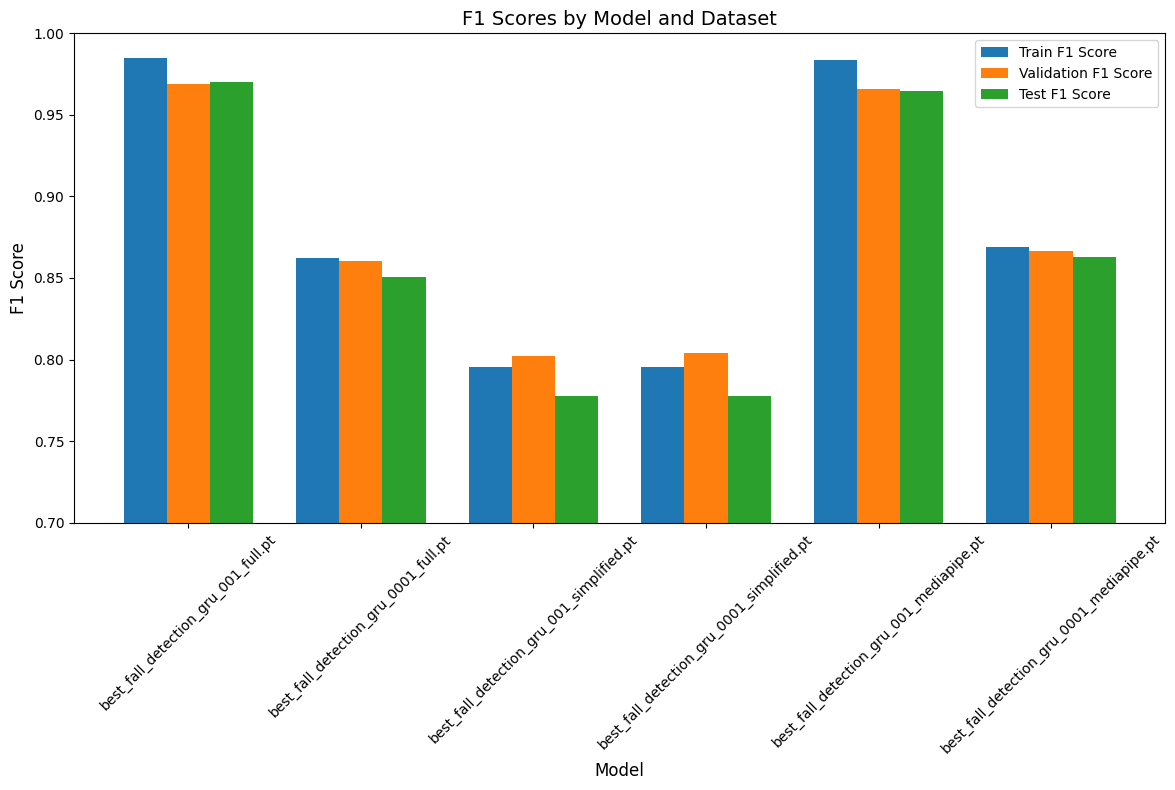

In [14]:
# 그래프용 데이터 변환
model_names = [result['Model'] for result in results]
train_scores = [result['Train'] for result in results]
val_scores = [result['Validation'] for result in results]
test_scores = [result['Test'] for result in results]

# 그래프 생성
plt.figure(figsize=(12, 8))
bar_width = 0.25
indices = range(len(model_names))

# 막대 그래프
plt.bar(indices, train_scores, bar_width, label="Train F1 Score")
plt.bar([i + bar_width for i in indices], val_scores, bar_width, label="Validation F1 Score")
plt.bar([i + 2 * bar_width for i in indices], test_scores, bar_width, label="Test F1 Score")

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Scores by Model and Dataset", fontsize=14)
plt.xticks([i + bar_width for i in indices], model_names, rotation=45, fontsize=10)
plt.ylim(0.7, 1.0)
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

In [15]:
# CNN 기반 낙상 감지 모델 정의
class FallDetectionCNN(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(FallDetectionCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=64, kernel_size=3, padding=1)  # mediapipe dataset을 공유하므로 in_channels은 22
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.transpose(1, 2)  # Conv1d의 형태를 맞추기 위함 (batch_size, channels, length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # tensor flattening
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
# 모델 준비
def create_cnn_model_for_dataset(dataset):
    if len(dataset) > 0:
        sample_sequence, sample_label = dataset[0]
        input_size = len(sample_sequence)  # CNN에서는 시퀀스 길이를 input size로 사용
        return FallDetectionCNN(input_size=input_size).to(device)
    else:
        print("데이터 없음")
        exit()

# 학습 및 검증 설정
cnn_model_configs = [
    ('best_fall_detection_cnn_mediapipe_001.pt', 0.001),
    ('best_fall_detection_cnn_mediapipe_0001.pt', 0.0001)
]

# 학습 파라미터 설정
num_epochs = 500
patience = 20

In [17]:
# 두 가지 학습률로 CNN 학습 진행
for cnn_model_name, learning_rate in cnn_model_configs:
    # 모델 생성
    model = create_cnn_model_for_dataset(train_mediapipe_dataset)
    model.to(device)

    # 손실 함수와 옵티마이저 정의
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0

    print(f"{cnn_model_name} 학습 시작 (lr={learning_rate})", flush=True)

    for epoch in range(num_epochs):
        model.train() # Training
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader_mediapipe, desc=f"Epoch {epoch + 1}/{num_epochs} (lr={learning_rate})"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()

            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader_mediapipe)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss (lr={learning_rate}): {avg_loss_train:.4f}')

        model.eval() # Validation
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader_mediapipe:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader_mediapipe)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss (lr={learning_rate}): {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), cnn_model_name)
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

best_fall_detection_cnn_mediapipe_001.pt 학습 시작 (lr=0.001)


Epoch 1/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 314.77it/s]


Epoch [1/500], Train Loss (lr=0.001): 0.8054
Epoch [1/500], Valid Loss (lr=0.001): 0.7021


Epoch 2/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.27it/s]


Epoch [2/500], Train Loss (lr=0.001): 0.6755
Epoch [2/500], Valid Loss (lr=0.001): 0.5468


Epoch 3/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.78it/s]


Epoch [3/500], Train Loss (lr=0.001): 0.5859
Epoch [3/500], Valid Loss (lr=0.001): 0.5359


Epoch 4/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 327.33it/s]


Epoch [4/500], Train Loss (lr=0.001): 0.5599
Epoch [4/500], Valid Loss (lr=0.001): 0.5215


Epoch 5/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 321.95it/s]


Epoch [5/500], Train Loss (lr=0.001): 0.5481
Epoch [5/500], Valid Loss (lr=0.001): 0.5025


Epoch 6/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 321.70it/s]


Epoch [6/500], Train Loss (lr=0.001): 0.5343
Epoch [6/500], Valid Loss (lr=0.001): 0.5146


Epoch 7/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.60it/s]


Epoch [7/500], Train Loss (lr=0.001): 0.5289
Epoch [7/500], Valid Loss (lr=0.001): 0.5168


Epoch 8/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.05it/s]


Epoch [8/500], Train Loss (lr=0.001): 0.5219
Epoch [8/500], Valid Loss (lr=0.001): 0.5468


Epoch 9/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.23it/s]


Epoch [9/500], Train Loss (lr=0.001): 0.5137
Epoch [9/500], Valid Loss (lr=0.001): 0.4843


Epoch 10/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.62it/s]


Epoch [10/500], Train Loss (lr=0.001): 0.5088
Epoch [10/500], Valid Loss (lr=0.001): 0.5744


Epoch 11/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.77it/s]


Epoch [11/500], Train Loss (lr=0.001): 0.5062
Epoch [11/500], Valid Loss (lr=0.001): 0.4808


Epoch 12/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.10it/s]


Epoch [12/500], Train Loss (lr=0.001): 0.5063
Epoch [12/500], Valid Loss (lr=0.001): 0.4791


Epoch 13/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 318.92it/s]


Epoch [13/500], Train Loss (lr=0.001): 0.4961
Epoch [13/500], Valid Loss (lr=0.001): 0.4853


Epoch 14/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.41it/s]


Epoch [14/500], Train Loss (lr=0.001): 0.4973
Epoch [14/500], Valid Loss (lr=0.001): 0.4674


Epoch 15/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.53it/s]


Epoch [15/500], Train Loss (lr=0.001): 0.4880
Epoch [15/500], Valid Loss (lr=0.001): 0.5350


Epoch 16/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.02it/s]


Epoch [16/500], Train Loss (lr=0.001): 0.4878
Epoch [16/500], Valid Loss (lr=0.001): 0.4635


Epoch 17/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.54it/s]


Epoch [17/500], Train Loss (lr=0.001): 0.4894
Epoch [17/500], Valid Loss (lr=0.001): 0.5052


Epoch 18/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.16it/s]


Epoch [18/500], Train Loss (lr=0.001): 0.4841
Epoch [18/500], Valid Loss (lr=0.001): 0.4985


Epoch 19/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 322.65it/s]


Epoch [19/500], Train Loss (lr=0.001): 0.4813
Epoch [19/500], Valid Loss (lr=0.001): 0.4670


Epoch 20/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.30it/s]


Epoch [20/500], Train Loss (lr=0.001): 0.4811
Epoch [20/500], Valid Loss (lr=0.001): 0.4598


Epoch 21/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.85it/s]


Epoch [21/500], Train Loss (lr=0.001): 0.4768
Epoch [21/500], Valid Loss (lr=0.001): 0.4940


Epoch 22/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.48it/s]


Epoch [22/500], Train Loss (lr=0.001): 0.4754
Epoch [22/500], Valid Loss (lr=0.001): 0.4703


Epoch 23/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.61it/s]


Epoch [23/500], Train Loss (lr=0.001): 0.4710
Epoch [23/500], Valid Loss (lr=0.001): 0.4697


Epoch 24/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.52it/s]


Epoch [24/500], Train Loss (lr=0.001): 0.4723
Epoch [24/500], Valid Loss (lr=0.001): 0.5041


Epoch 25/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.45it/s]


Epoch [25/500], Train Loss (lr=0.001): 0.4684
Epoch [25/500], Valid Loss (lr=0.001): 0.4564


Epoch 26/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.76it/s]


Epoch [26/500], Train Loss (lr=0.001): 0.4654
Epoch [26/500], Valid Loss (lr=0.001): 0.4688


Epoch 27/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.40it/s]


Epoch [27/500], Train Loss (lr=0.001): 0.4679
Epoch [27/500], Valid Loss (lr=0.001): 0.4680


Epoch 28/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.79it/s]


Epoch [28/500], Train Loss (lr=0.001): 0.4639
Epoch [28/500], Valid Loss (lr=0.001): 0.4480


Epoch 29/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 321.23it/s]


Epoch [29/500], Train Loss (lr=0.001): 0.4617
Epoch [29/500], Valid Loss (lr=0.001): 0.4928


Epoch 30/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.85it/s]


Epoch [30/500], Train Loss (lr=0.001): 0.4636
Epoch [30/500], Valid Loss (lr=0.001): 0.4359


Epoch 31/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.89it/s]


Epoch [31/500], Train Loss (lr=0.001): 0.4571
Epoch [31/500], Valid Loss (lr=0.001): 0.4637


Epoch 32/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.03it/s]


Epoch [32/500], Train Loss (lr=0.001): 0.4563
Epoch [32/500], Valid Loss (lr=0.001): 0.4627


Epoch 33/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.45it/s]


Epoch [33/500], Train Loss (lr=0.001): 0.4550
Epoch [33/500], Valid Loss (lr=0.001): 0.5432


Epoch 34/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.48it/s]


Epoch [34/500], Train Loss (lr=0.001): 0.4502
Epoch [34/500], Valid Loss (lr=0.001): 0.4256


Epoch 35/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.02it/s]


Epoch [35/500], Train Loss (lr=0.001): 0.4533
Epoch [35/500], Valid Loss (lr=0.001): 0.4692


Epoch 36/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.96it/s]


Epoch [36/500], Train Loss (lr=0.001): 0.4496
Epoch [36/500], Valid Loss (lr=0.001): 0.4364


Epoch 37/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.06it/s]


Epoch [37/500], Train Loss (lr=0.001): 0.4485
Epoch [37/500], Valid Loss (lr=0.001): 0.4415


Epoch 38/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.54it/s]


Epoch [38/500], Train Loss (lr=0.001): 0.4485
Epoch [38/500], Valid Loss (lr=0.001): 0.4233


Epoch 39/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.67it/s]


Epoch [39/500], Train Loss (lr=0.001): 0.4470
Epoch [39/500], Valid Loss (lr=0.001): 0.4626


Epoch 40/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.36it/s]


Epoch [40/500], Train Loss (lr=0.001): 0.4453
Epoch [40/500], Valid Loss (lr=0.001): 0.4668


Epoch 41/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.10it/s]


Epoch [41/500], Train Loss (lr=0.001): 0.4450
Epoch [41/500], Valid Loss (lr=0.001): 0.4393


Epoch 42/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 321.53it/s]


Epoch [42/500], Train Loss (lr=0.001): 0.4422
Epoch [42/500], Valid Loss (lr=0.001): 0.4279


Epoch 43/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.14it/s]


Epoch [43/500], Train Loss (lr=0.001): 0.4424
Epoch [43/500], Valid Loss (lr=0.001): 0.4244


Epoch 44/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.51it/s]


Epoch [44/500], Train Loss (lr=0.001): 0.4413
Epoch [44/500], Valid Loss (lr=0.001): 0.4302


Epoch 45/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.55it/s]


Epoch [45/500], Train Loss (lr=0.001): 0.3979
Epoch [45/500], Valid Loss (lr=0.001): 0.3986


Epoch 46/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.73it/s]


Epoch [46/500], Train Loss (lr=0.001): 0.3914
Epoch [46/500], Valid Loss (lr=0.001): 0.3932


Epoch 47/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.13it/s]


Epoch [47/500], Train Loss (lr=0.001): 0.3883
Epoch [47/500], Valid Loss (lr=0.001): 0.3891


Epoch 48/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.52it/s]


Epoch [48/500], Train Loss (lr=0.001): 0.3862
Epoch [48/500], Valid Loss (lr=0.001): 0.3875


Epoch 49/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.15it/s]


Epoch [49/500], Train Loss (lr=0.001): 0.3859
Epoch [49/500], Valid Loss (lr=0.001): 0.3892


Epoch 50/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.91it/s]


Epoch [50/500], Train Loss (lr=0.001): 0.3834
Epoch [50/500], Valid Loss (lr=0.001): 0.3851


Epoch 51/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.36it/s]


Epoch [51/500], Train Loss (lr=0.001): 0.3831
Epoch [51/500], Valid Loss (lr=0.001): 0.3877


Epoch 52/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.95it/s]


Epoch [52/500], Train Loss (lr=0.001): 0.3823
Epoch [52/500], Valid Loss (lr=0.001): 0.3853


Epoch 53/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.16it/s]


Epoch [53/500], Train Loss (lr=0.001): 0.3794
Epoch [53/500], Valid Loss (lr=0.001): 0.3850


Epoch 54/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.96it/s]


Epoch [54/500], Train Loss (lr=0.001): 0.3779
Epoch [54/500], Valid Loss (lr=0.001): 0.3832


Epoch 55/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.92it/s]


Epoch [55/500], Train Loss (lr=0.001): 0.3774
Epoch [55/500], Valid Loss (lr=0.001): 0.3803


Epoch 56/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.24it/s]


Epoch [56/500], Train Loss (lr=0.001): 0.3766
Epoch [56/500], Valid Loss (lr=0.001): 0.3814


Epoch 57/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.86it/s]


Epoch [57/500], Train Loss (lr=0.001): 0.3766
Epoch [57/500], Valid Loss (lr=0.001): 0.3791


Epoch 58/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.35it/s]


Epoch [58/500], Train Loss (lr=0.001): 0.3738
Epoch [58/500], Valid Loss (lr=0.001): 0.3801


Epoch 59/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.47it/s]


Epoch [59/500], Train Loss (lr=0.001): 0.3745
Epoch [59/500], Valid Loss (lr=0.001): 0.3762


Epoch 60/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.81it/s]


Epoch [60/500], Train Loss (lr=0.001): 0.3724
Epoch [60/500], Valid Loss (lr=0.001): 0.3771


Epoch 61/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.44it/s]


Epoch [61/500], Train Loss (lr=0.001): 0.3710
Epoch [61/500], Valid Loss (lr=0.001): 0.3745


Epoch 62/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.49it/s]


Epoch [62/500], Train Loss (lr=0.001): 0.3708
Epoch [62/500], Valid Loss (lr=0.001): 0.3822


Epoch 63/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.35it/s]


Epoch [63/500], Train Loss (lr=0.001): 0.3715
Epoch [63/500], Valid Loss (lr=0.001): 0.3752


Epoch 64/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.92it/s]


Epoch [64/500], Train Loss (lr=0.001): 0.3718
Epoch [64/500], Valid Loss (lr=0.001): 0.3731


Epoch 65/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.15it/s]


Epoch [65/500], Train Loss (lr=0.001): 0.3688
Epoch [65/500], Valid Loss (lr=0.001): 0.3743


Epoch 66/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.63it/s]


Epoch [66/500], Train Loss (lr=0.001): 0.3672
Epoch [66/500], Valid Loss (lr=0.001): 0.3718


Epoch 67/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.07it/s]


Epoch [67/500], Train Loss (lr=0.001): 0.3684
Epoch [67/500], Valid Loss (lr=0.001): 0.3688


Epoch 68/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.35it/s]


Epoch [68/500], Train Loss (lr=0.001): 0.3659
Epoch [68/500], Valid Loss (lr=0.001): 0.3749


Epoch 69/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.71it/s]


Epoch [69/500], Train Loss (lr=0.001): 0.3654
Epoch [69/500], Valid Loss (lr=0.001): 0.3753


Epoch 70/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.66it/s]


Epoch [70/500], Train Loss (lr=0.001): 0.3653
Epoch [70/500], Valid Loss (lr=0.001): 0.3668


Epoch 71/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.66it/s]


Epoch [71/500], Train Loss (lr=0.001): 0.3624
Epoch [71/500], Valid Loss (lr=0.001): 0.3671


Epoch 72/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.55it/s]


Epoch [72/500], Train Loss (lr=0.001): 0.3639
Epoch [72/500], Valid Loss (lr=0.001): 0.3703


Epoch 73/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.46it/s]


Epoch [73/500], Train Loss (lr=0.001): 0.3623
Epoch [73/500], Valid Loss (lr=0.001): 0.3730


Epoch 74/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 327.15it/s]


Epoch [74/500], Train Loss (lr=0.001): 0.3611
Epoch [74/500], Valid Loss (lr=0.001): 0.3647


Epoch 75/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.46it/s]


Epoch [75/500], Train Loss (lr=0.001): 0.3623
Epoch [75/500], Valid Loss (lr=0.001): 0.3626


Epoch 76/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.35it/s]


Epoch [76/500], Train Loss (lr=0.001): 0.3587
Epoch [76/500], Valid Loss (lr=0.001): 0.3690


Epoch 77/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.96it/s]


Epoch [77/500], Train Loss (lr=0.001): 0.3597
Epoch [77/500], Valid Loss (lr=0.001): 0.3625


Epoch 78/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.61it/s]


Epoch [78/500], Train Loss (lr=0.001): 0.3575
Epoch [78/500], Valid Loss (lr=0.001): 0.3634


Epoch 79/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.70it/s]


Epoch [79/500], Train Loss (lr=0.001): 0.3579
Epoch [79/500], Valid Loss (lr=0.001): 0.3611


Epoch 80/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.68it/s]


Epoch [80/500], Train Loss (lr=0.001): 0.3585
Epoch [80/500], Valid Loss (lr=0.001): 0.3675


Epoch 81/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.17it/s]


Epoch [81/500], Train Loss (lr=0.001): 0.3558
Epoch [81/500], Valid Loss (lr=0.001): 0.3586


Epoch 82/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.45it/s]


Epoch [82/500], Train Loss (lr=0.001): 0.3545
Epoch [82/500], Valid Loss (lr=0.001): 0.3602


Epoch 83/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.98it/s]


Epoch [83/500], Train Loss (lr=0.001): 0.3538
Epoch [83/500], Valid Loss (lr=0.001): 0.3608


Epoch 84/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.84it/s]


Epoch [84/500], Train Loss (lr=0.001): 0.3540
Epoch [84/500], Valid Loss (lr=0.001): 0.3623


Epoch 85/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.07it/s]


Epoch [85/500], Train Loss (lr=0.001): 0.3512
Epoch [85/500], Valid Loss (lr=0.001): 0.3551


Epoch 86/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.83it/s]


Epoch [86/500], Train Loss (lr=0.001): 0.3529
Epoch [86/500], Valid Loss (lr=0.001): 0.3540


Epoch 87/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.60it/s]


Epoch [87/500], Train Loss (lr=0.001): 0.3511
Epoch [87/500], Valid Loss (lr=0.001): 0.3540


Epoch 88/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.32it/s]


Epoch [88/500], Train Loss (lr=0.001): 0.3489
Epoch [88/500], Valid Loss (lr=0.001): 0.3532


Epoch 89/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.94it/s]


Epoch [89/500], Train Loss (lr=0.001): 0.3495
Epoch [89/500], Valid Loss (lr=0.001): 0.3578


Epoch 90/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.46it/s]


Epoch [90/500], Train Loss (lr=0.001): 0.3488
Epoch [90/500], Valid Loss (lr=0.001): 0.3509


Epoch 91/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.05it/s]


Epoch [91/500], Train Loss (lr=0.001): 0.3470
Epoch [91/500], Valid Loss (lr=0.001): 0.3496


Epoch 92/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.06it/s]


Epoch [92/500], Train Loss (lr=0.001): 0.3469
Epoch [92/500], Valid Loss (lr=0.001): 0.3613


Epoch 93/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.81it/s]


Epoch [93/500], Train Loss (lr=0.001): 0.3456
Epoch [93/500], Valid Loss (lr=0.001): 0.3543


Epoch 94/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.67it/s]


Epoch [94/500], Train Loss (lr=0.001): 0.3440
Epoch [94/500], Valid Loss (lr=0.001): 0.3496


Epoch 95/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.58it/s]


Epoch [95/500], Train Loss (lr=0.001): 0.3437
Epoch [95/500], Valid Loss (lr=0.001): 0.3509


Epoch 96/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.41it/s]


Epoch [96/500], Train Loss (lr=0.001): 0.3434
Epoch [96/500], Valid Loss (lr=0.001): 0.3464


Epoch 97/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.65it/s]


Epoch [97/500], Train Loss (lr=0.001): 0.3412
Epoch [97/500], Valid Loss (lr=0.001): 0.3468


Epoch 98/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.89it/s]


Epoch [98/500], Train Loss (lr=0.001): 0.3392
Epoch [98/500], Valid Loss (lr=0.001): 0.3526


Epoch 99/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.73it/s]


Epoch [99/500], Train Loss (lr=0.001): 0.3391
Epoch [99/500], Valid Loss (lr=0.001): 0.3460


Epoch 100/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.66it/s]


Epoch [100/500], Train Loss (lr=0.001): 0.3405
Epoch [100/500], Valid Loss (lr=0.001): 0.3541


Epoch 101/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.84it/s]


Epoch [101/500], Train Loss (lr=0.001): 0.3374
Epoch [101/500], Valid Loss (lr=0.001): 0.3451


Epoch 102/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.23it/s]


Epoch [102/500], Train Loss (lr=0.001): 0.3375
Epoch [102/500], Valid Loss (lr=0.001): 0.3458


Epoch 103/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.76it/s]


Epoch [103/500], Train Loss (lr=0.001): 0.3366
Epoch [103/500], Valid Loss (lr=0.001): 0.3389


Epoch 104/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.86it/s]


Epoch [104/500], Train Loss (lr=0.001): 0.3356
Epoch [104/500], Valid Loss (lr=0.001): 0.3421


Epoch 105/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.77it/s]


Epoch [105/500], Train Loss (lr=0.001): 0.3324
Epoch [105/500], Valid Loss (lr=0.001): 0.3482


Epoch 106/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.67it/s]


Epoch [106/500], Train Loss (lr=0.001): 0.3321
Epoch [106/500], Valid Loss (lr=0.001): 0.3418


Epoch 107/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.91it/s]


Epoch [107/500], Train Loss (lr=0.001): 0.3318
Epoch [107/500], Valid Loss (lr=0.001): 0.3428


Epoch 108/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.31it/s]


Epoch [108/500], Train Loss (lr=0.001): 0.3310
Epoch [108/500], Valid Loss (lr=0.001): 0.3465


Epoch 109/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.65it/s]


Epoch [109/500], Train Loss (lr=0.001): 0.3295
Epoch [109/500], Valid Loss (lr=0.001): 0.3381


Epoch 110/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.21it/s]


Epoch [110/500], Train Loss (lr=0.001): 0.3286
Epoch [110/500], Valid Loss (lr=0.001): 0.3359


Epoch 111/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.15it/s]


Epoch [111/500], Train Loss (lr=0.001): 0.3283
Epoch [111/500], Valid Loss (lr=0.001): 0.3440


Epoch 112/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.13it/s]


Epoch [112/500], Train Loss (lr=0.001): 0.3298
Epoch [112/500], Valid Loss (lr=0.001): 0.3331


Epoch 113/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.89it/s]


Epoch [113/500], Train Loss (lr=0.001): 0.3278
Epoch [113/500], Valid Loss (lr=0.001): 0.3341


Epoch 114/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.15it/s]


Epoch [114/500], Train Loss (lr=0.001): 0.3262
Epoch [114/500], Valid Loss (lr=0.001): 0.3284


Epoch 115/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.79it/s]


Epoch [115/500], Train Loss (lr=0.001): 0.3260
Epoch [115/500], Valid Loss (lr=0.001): 0.3324


Epoch 116/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.74it/s]


Epoch [116/500], Train Loss (lr=0.001): 0.3236
Epoch [116/500], Valid Loss (lr=0.001): 0.3322


Epoch 117/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.55it/s]


Epoch [117/500], Train Loss (lr=0.001): 0.3249
Epoch [117/500], Valid Loss (lr=0.001): 0.3302


Epoch 118/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.16it/s]


Epoch [118/500], Train Loss (lr=0.001): 0.3228
Epoch [118/500], Valid Loss (lr=0.001): 0.3351


Epoch 119/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.99it/s]


Epoch [119/500], Train Loss (lr=0.001): 0.3252
Epoch [119/500], Valid Loss (lr=0.001): 0.3419


Epoch 120/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 327.38it/s]


Epoch [120/500], Train Loss (lr=0.001): 0.3226
Epoch [120/500], Valid Loss (lr=0.001): 0.3290


Epoch 121/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.31it/s]


Epoch [121/500], Train Loss (lr=0.001): 0.3123
Epoch [121/500], Valid Loss (lr=0.001): 0.3261


Epoch 122/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 326.07it/s]


Epoch [122/500], Train Loss (lr=0.001): 0.3091
Epoch [122/500], Valid Loss (lr=0.001): 0.3247


Epoch 123/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 325.50it/s]


Epoch [123/500], Train Loss (lr=0.001): 0.3087
Epoch [123/500], Valid Loss (lr=0.001): 0.3247


Epoch 124/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.64it/s]


Epoch [124/500], Train Loss (lr=0.001): 0.3101
Epoch [124/500], Valid Loss (lr=0.001): 0.3248


Epoch 125/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.36it/s]


Epoch [125/500], Train Loss (lr=0.001): 0.3079
Epoch [125/500], Valid Loss (lr=0.001): 0.3226


Epoch 126/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.08it/s]


Epoch [126/500], Train Loss (lr=0.001): 0.3089
Epoch [126/500], Valid Loss (lr=0.001): 0.3241


Epoch 127/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.53it/s]


Epoch [127/500], Train Loss (lr=0.001): 0.3078
Epoch [127/500], Valid Loss (lr=0.001): 0.3218


Epoch 128/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.40it/s]


Epoch [128/500], Train Loss (lr=0.001): 0.3079
Epoch [128/500], Valid Loss (lr=0.001): 0.3225


Epoch 129/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.00it/s]


Epoch [129/500], Train Loss (lr=0.001): 0.3074
Epoch [129/500], Valid Loss (lr=0.001): 0.3221


Epoch 130/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.45it/s]


Epoch [130/500], Train Loss (lr=0.001): 0.3066
Epoch [130/500], Valid Loss (lr=0.001): 0.3231


Epoch 131/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 322.65it/s]


Epoch [131/500], Train Loss (lr=0.001): 0.3072
Epoch [131/500], Valid Loss (lr=0.001): 0.3242


Epoch 132/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 319.88it/s]


Epoch [132/500], Train Loss (lr=0.001): 0.3065
Epoch [132/500], Valid Loss (lr=0.001): 0.3228


Epoch 133/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 320.30it/s]


Epoch [133/500], Train Loss (lr=0.001): 0.3082
Epoch [133/500], Valid Loss (lr=0.001): 0.3225


Epoch 134/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 320.49it/s]


Epoch [134/500], Train Loss (lr=0.001): 0.3050
Epoch [134/500], Valid Loss (lr=0.001): 0.3222


Epoch 135/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.21it/s]


Epoch [135/500], Train Loss (lr=0.001): 0.3069
Epoch [135/500], Valid Loss (lr=0.001): 0.3224


Epoch 136/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 322.11it/s]


Epoch [136/500], Train Loss (lr=0.001): 0.3051
Epoch [136/500], Valid Loss (lr=0.001): 0.3222


Epoch 137/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 320.39it/s]


Epoch [137/500], Train Loss (lr=0.001): 0.3039
Epoch [137/500], Valid Loss (lr=0.001): 0.3223


Epoch 138/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.18it/s]


Epoch [138/500], Train Loss (lr=0.001): 0.3062
Epoch [138/500], Valid Loss (lr=0.001): 0.3223


Epoch 139/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 321.01it/s]


Epoch [139/500], Train Loss (lr=0.001): 0.3033
Epoch [139/500], Valid Loss (lr=0.001): 0.3225


Epoch 140/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 322.75it/s]


Epoch [140/500], Train Loss (lr=0.001): 0.3041
Epoch [140/500], Valid Loss (lr=0.001): 0.3225


Epoch 141/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 322.50it/s]


Epoch [141/500], Train Loss (lr=0.001): 0.3054
Epoch [141/500], Valid Loss (lr=0.001): 0.3225


Epoch 142/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 321.82it/s]


Epoch [142/500], Train Loss (lr=0.001): 0.3050
Epoch [142/500], Valid Loss (lr=0.001): 0.3225


Epoch 143/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 322.42it/s]


Epoch [143/500], Train Loss (lr=0.001): 0.3050
Epoch [143/500], Valid Loss (lr=0.001): 0.3224


Epoch 144/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 324.02it/s]


Epoch [144/500], Train Loss (lr=0.001): 0.3044
Epoch [144/500], Valid Loss (lr=0.001): 0.3224


Epoch 145/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 321.91it/s]


Epoch [145/500], Train Loss (lr=0.001): 0.3056
Epoch [145/500], Valid Loss (lr=0.001): 0.3224


Epoch 146/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 323.63it/s]


Epoch [146/500], Train Loss (lr=0.001): 0.3053
Epoch [146/500], Valid Loss (lr=0.001): 0.3224


Epoch 147/500 (lr=0.001): 100%|██████████| 1972/1972 [00:06<00:00, 322.03it/s]


Epoch [147/500], Train Loss (lr=0.001): 0.3046
Epoch [147/500], Valid Loss (lr=0.001): 0.3224
Early stopping
best_fall_detection_cnn_mediapipe_0001.pt 학습 시작 (lr=0.0001)


Epoch 1/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.76it/s]


Epoch [1/500], Train Loss (lr=0.0001): 0.8266
Epoch [1/500], Valid Loss (lr=0.0001): 0.7565


Epoch 2/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.75it/s]


Epoch [2/500], Train Loss (lr=0.0001): 0.7706
Epoch [2/500], Valid Loss (lr=0.0001): 0.7334


Epoch 3/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.04it/s]


Epoch [3/500], Train Loss (lr=0.0001): 0.7311
Epoch [3/500], Valid Loss (lr=0.0001): 0.7039


Epoch 4/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.92it/s]


Epoch [4/500], Train Loss (lr=0.0001): 0.6460
Epoch [4/500], Valid Loss (lr=0.0001): 0.5858


Epoch 5/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.69it/s]


Epoch [5/500], Train Loss (lr=0.0001): 0.5803
Epoch [5/500], Valid Loss (lr=0.0001): 0.5332


Epoch 6/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.68it/s]


Epoch [6/500], Train Loss (lr=0.0001): 0.5501
Epoch [6/500], Valid Loss (lr=0.0001): 0.5229


Epoch 7/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 328.38it/s]


Epoch [7/500], Train Loss (lr=0.0001): 0.5338
Epoch [7/500], Valid Loss (lr=0.0001): 0.5448


Epoch 8/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.30it/s]


Epoch [8/500], Train Loss (lr=0.0001): 0.5203
Epoch [8/500], Valid Loss (lr=0.0001): 0.4960


Epoch 9/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.51it/s]


Epoch [9/500], Train Loss (lr=0.0001): 0.5150
Epoch [9/500], Valid Loss (lr=0.0001): 0.4992


Epoch 10/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 328.83it/s]


Epoch [10/500], Train Loss (lr=0.0001): 0.5091
Epoch [10/500], Valid Loss (lr=0.0001): 0.5091


Epoch 11/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.89it/s]


Epoch [11/500], Train Loss (lr=0.0001): 0.4975
Epoch [11/500], Valid Loss (lr=0.0001): 0.4708


Epoch 12/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:05<00:00, 328.83it/s]


Epoch [12/500], Train Loss (lr=0.0001): 0.4902
Epoch [12/500], Valid Loss (lr=0.0001): 0.4630


Epoch 13/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 328.29it/s]


Epoch [13/500], Train Loss (lr=0.0001): 0.4881
Epoch [13/500], Valid Loss (lr=0.0001): 0.4828


Epoch 14/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.51it/s]


Epoch [14/500], Train Loss (lr=0.0001): 0.4807
Epoch [14/500], Valid Loss (lr=0.0001): 0.4577


Epoch 15/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.48it/s]


Epoch [15/500], Train Loss (lr=0.0001): 0.4759
Epoch [15/500], Valid Loss (lr=0.0001): 0.4717


Epoch 16/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.80it/s]


Epoch [16/500], Train Loss (lr=0.0001): 0.4718
Epoch [16/500], Valid Loss (lr=0.0001): 0.4496


Epoch 17/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.95it/s]


Epoch [17/500], Train Loss (lr=0.0001): 0.4653
Epoch [17/500], Valid Loss (lr=0.0001): 0.4588


Epoch 18/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.44it/s]


Epoch [18/500], Train Loss (lr=0.0001): 0.4580
Epoch [18/500], Valid Loss (lr=0.0001): 0.4780


Epoch 19/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.37it/s]


Epoch [19/500], Train Loss (lr=0.0001): 0.4556
Epoch [19/500], Valid Loss (lr=0.0001): 0.4812


Epoch 20/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.94it/s]


Epoch [20/500], Train Loss (lr=0.0001): 0.4500
Epoch [20/500], Valid Loss (lr=0.0001): 0.4467


Epoch 21/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.83it/s]


Epoch [21/500], Train Loss (lr=0.0001): 0.4467
Epoch [21/500], Valid Loss (lr=0.0001): 0.4571


Epoch 22/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.97it/s]


Epoch [22/500], Train Loss (lr=0.0001): 0.4462
Epoch [22/500], Valid Loss (lr=0.0001): 0.4275


Epoch 23/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.17it/s]


Epoch [23/500], Train Loss (lr=0.0001): 0.4434
Epoch [23/500], Valid Loss (lr=0.0001): 0.4542


Epoch 24/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.40it/s]


Epoch [24/500], Train Loss (lr=0.0001): 0.4397
Epoch [24/500], Valid Loss (lr=0.0001): 0.4238


Epoch 25/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.09it/s]


Epoch [25/500], Train Loss (lr=0.0001): 0.4355
Epoch [25/500], Valid Loss (lr=0.0001): 0.4324


Epoch 26/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.97it/s]


Epoch [26/500], Train Loss (lr=0.0001): 0.4326
Epoch [26/500], Valid Loss (lr=0.0001): 0.4371


Epoch 27/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.84it/s]


Epoch [27/500], Train Loss (lr=0.0001): 0.4314
Epoch [27/500], Valid Loss (lr=0.0001): 0.4158


Epoch 28/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.84it/s]


Epoch [28/500], Train Loss (lr=0.0001): 0.4291
Epoch [28/500], Valid Loss (lr=0.0001): 0.4241


Epoch 29/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.00it/s]


Epoch [29/500], Train Loss (lr=0.0001): 0.4245
Epoch [29/500], Valid Loss (lr=0.0001): 0.4252


Epoch 30/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.84it/s]


Epoch [30/500], Train Loss (lr=0.0001): 0.4258
Epoch [30/500], Valid Loss (lr=0.0001): 0.4060


Epoch 31/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.14it/s]


Epoch [31/500], Train Loss (lr=0.0001): 0.4203
Epoch [31/500], Valid Loss (lr=0.0001): 0.4336


Epoch 32/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.68it/s]


Epoch [32/500], Train Loss (lr=0.0001): 0.4179
Epoch [32/500], Valid Loss (lr=0.0001): 0.4171


Epoch 33/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.76it/s]


Epoch [33/500], Train Loss (lr=0.0001): 0.4140
Epoch [33/500], Valid Loss (lr=0.0001): 0.4325


Epoch 34/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.65it/s]


Epoch [34/500], Train Loss (lr=0.0001): 0.4092
Epoch [34/500], Valid Loss (lr=0.0001): 0.4233


Epoch 35/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.16it/s]


Epoch [35/500], Train Loss (lr=0.0001): 0.4091
Epoch [35/500], Valid Loss (lr=0.0001): 0.4022


Epoch 36/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.74it/s]


Epoch [36/500], Train Loss (lr=0.0001): 0.4062
Epoch [36/500], Valid Loss (lr=0.0001): 0.4080


Epoch 37/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.38it/s]


Epoch [37/500], Train Loss (lr=0.0001): 0.4054
Epoch [37/500], Valid Loss (lr=0.0001): 0.4084


Epoch 38/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.41it/s]


Epoch [38/500], Train Loss (lr=0.0001): 0.3991
Epoch [38/500], Valid Loss (lr=0.0001): 0.4007


Epoch 39/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.96it/s]


Epoch [39/500], Train Loss (lr=0.0001): 0.3979
Epoch [39/500], Valid Loss (lr=0.0001): 0.4466


Epoch 40/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.73it/s]


Epoch [40/500], Train Loss (lr=0.0001): 0.3966
Epoch [40/500], Valid Loss (lr=0.0001): 0.3887


Epoch 41/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.01it/s]


Epoch [41/500], Train Loss (lr=0.0001): 0.3932
Epoch [41/500], Valid Loss (lr=0.0001): 0.4065


Epoch 42/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.93it/s]


Epoch [42/500], Train Loss (lr=0.0001): 0.3916
Epoch [42/500], Valid Loss (lr=0.0001): 0.4122


Epoch 43/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.97it/s]


Epoch [43/500], Train Loss (lr=0.0001): 0.3883
Epoch [43/500], Valid Loss (lr=0.0001): 0.3934


Epoch 44/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.07it/s]


Epoch [44/500], Train Loss (lr=0.0001): 0.3893
Epoch [44/500], Valid Loss (lr=0.0001): 0.4542


Epoch 45/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.62it/s]


Epoch [45/500], Train Loss (lr=0.0001): 0.3875
Epoch [45/500], Valid Loss (lr=0.0001): 0.3883


Epoch 46/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.23it/s]


Epoch [46/500], Train Loss (lr=0.0001): 0.3834
Epoch [46/500], Valid Loss (lr=0.0001): 0.3752


Epoch 47/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.69it/s]


Epoch [47/500], Train Loss (lr=0.0001): 0.3850
Epoch [47/500], Valid Loss (lr=0.0001): 0.3753


Epoch 48/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 328.20it/s]


Epoch [48/500], Train Loss (lr=0.0001): 0.3799
Epoch [48/500], Valid Loss (lr=0.0001): 0.3725


Epoch 49/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.72it/s]


Epoch [49/500], Train Loss (lr=0.0001): 0.3791
Epoch [49/500], Valid Loss (lr=0.0001): 0.4185


Epoch 50/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.11it/s]


Epoch [50/500], Train Loss (lr=0.0001): 0.3767
Epoch [50/500], Valid Loss (lr=0.0001): 0.3962


Epoch 51/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.74it/s]


Epoch [51/500], Train Loss (lr=0.0001): 0.3737
Epoch [51/500], Valid Loss (lr=0.0001): 0.4021


Epoch 52/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.98it/s]


Epoch [52/500], Train Loss (lr=0.0001): 0.3734
Epoch [52/500], Valid Loss (lr=0.0001): 0.3733


Epoch 53/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.56it/s]


Epoch [53/500], Train Loss (lr=0.0001): 0.3689
Epoch [53/500], Valid Loss (lr=0.0001): 0.3721


Epoch 54/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.23it/s]


Epoch [54/500], Train Loss (lr=0.0001): 0.3691
Epoch [54/500], Valid Loss (lr=0.0001): 0.3905


Epoch 55/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.21it/s]


Epoch [55/500], Train Loss (lr=0.0001): 0.3675
Epoch [55/500], Valid Loss (lr=0.0001): 0.3682


Epoch 56/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.40it/s]


Epoch [56/500], Train Loss (lr=0.0001): 0.3639
Epoch [56/500], Valid Loss (lr=0.0001): 0.3931


Epoch 57/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.24it/s]


Epoch [57/500], Train Loss (lr=0.0001): 0.3619
Epoch [57/500], Valid Loss (lr=0.0001): 0.3554


Epoch 58/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.48it/s]


Epoch [58/500], Train Loss (lr=0.0001): 0.3635
Epoch [58/500], Valid Loss (lr=0.0001): 0.3786


Epoch 59/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.60it/s]


Epoch [59/500], Train Loss (lr=0.0001): 0.3614
Epoch [59/500], Valid Loss (lr=0.0001): 0.3772


Epoch 60/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.69it/s]


Epoch [60/500], Train Loss (lr=0.0001): 0.3590
Epoch [60/500], Valid Loss (lr=0.0001): 0.3640


Epoch 61/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.43it/s]


Epoch [61/500], Train Loss (lr=0.0001): 0.3548
Epoch [61/500], Valid Loss (lr=0.0001): 0.3453


Epoch 62/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.78it/s]


Epoch [62/500], Train Loss (lr=0.0001): 0.3536
Epoch [62/500], Valid Loss (lr=0.0001): 0.3972


Epoch 63/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.96it/s]


Epoch [63/500], Train Loss (lr=0.0001): 0.3527
Epoch [63/500], Valid Loss (lr=0.0001): 0.3632


Epoch 64/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.30it/s]


Epoch [64/500], Train Loss (lr=0.0001): 0.3490
Epoch [64/500], Valid Loss (lr=0.0001): 0.3912


Epoch 65/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.30it/s]


Epoch [65/500], Train Loss (lr=0.0001): 0.3507
Epoch [65/500], Valid Loss (lr=0.0001): 0.3459


Epoch 66/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.17it/s]


Epoch [66/500], Train Loss (lr=0.0001): 0.3473
Epoch [66/500], Valid Loss (lr=0.0001): 0.3608


Epoch 67/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.69it/s]


Epoch [67/500], Train Loss (lr=0.0001): 0.3455
Epoch [67/500], Valid Loss (lr=0.0001): 0.3482


Epoch 68/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.17it/s]


Epoch [68/500], Train Loss (lr=0.0001): 0.3086
Epoch [68/500], Valid Loss (lr=0.0001): 0.3233


Epoch 69/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 327.09it/s]


Epoch [69/500], Train Loss (lr=0.0001): 0.3012
Epoch [69/500], Valid Loss (lr=0.0001): 0.3196


Epoch 70/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.78it/s]


Epoch [70/500], Train Loss (lr=0.0001): 0.2993
Epoch [70/500], Valid Loss (lr=0.0001): 0.3152


Epoch 71/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.91it/s]


Epoch [71/500], Train Loss (lr=0.0001): 0.2982
Epoch [71/500], Valid Loss (lr=0.0001): 0.3164


Epoch 72/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.29it/s]


Epoch [72/500], Train Loss (lr=0.0001): 0.2974
Epoch [72/500], Valid Loss (lr=0.0001): 0.3126


Epoch 73/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.91it/s]


Epoch [73/500], Train Loss (lr=0.0001): 0.2953
Epoch [73/500], Valid Loss (lr=0.0001): 0.3137


Epoch 74/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.03it/s]


Epoch [74/500], Train Loss (lr=0.0001): 0.2947
Epoch [74/500], Valid Loss (lr=0.0001): 0.3162


Epoch 75/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.34it/s]


Epoch [75/500], Train Loss (lr=0.0001): 0.2946
Epoch [75/500], Valid Loss (lr=0.0001): 0.3121


Epoch 76/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.41it/s]


Epoch [76/500], Train Loss (lr=0.0001): 0.2943
Epoch [76/500], Valid Loss (lr=0.0001): 0.3132


Epoch 77/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.26it/s]


Epoch [77/500], Train Loss (lr=0.0001): 0.2911
Epoch [77/500], Valid Loss (lr=0.0001): 0.3100


Epoch 78/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.61it/s]


Epoch [78/500], Train Loss (lr=0.0001): 0.2908
Epoch [78/500], Valid Loss (lr=0.0001): 0.3063


Epoch 79/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.34it/s]


Epoch [79/500], Train Loss (lr=0.0001): 0.2913
Epoch [79/500], Valid Loss (lr=0.0001): 0.3097


Epoch 80/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.28it/s]


Epoch [80/500], Train Loss (lr=0.0001): 0.2909
Epoch [80/500], Valid Loss (lr=0.0001): 0.3088


Epoch 81/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.71it/s]


Epoch [81/500], Train Loss (lr=0.0001): 0.2894
Epoch [81/500], Valid Loss (lr=0.0001): 0.3086


Epoch 82/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.77it/s]


Epoch [82/500], Train Loss (lr=0.0001): 0.2888
Epoch [82/500], Valid Loss (lr=0.0001): 0.3079


Epoch 83/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.72it/s]


Epoch [83/500], Train Loss (lr=0.0001): 0.2891
Epoch [83/500], Valid Loss (lr=0.0001): 0.3091


Epoch 84/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.56it/s]


Epoch [84/500], Train Loss (lr=0.0001): 0.2860
Epoch [84/500], Valid Loss (lr=0.0001): 0.3073


Epoch 85/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.90it/s]


Epoch [85/500], Train Loss (lr=0.0001): 0.2831
Epoch [85/500], Valid Loss (lr=0.0001): 0.3044


Epoch 86/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.82it/s]


Epoch [86/500], Train Loss (lr=0.0001): 0.2813
Epoch [86/500], Valid Loss (lr=0.0001): 0.3037


Epoch 87/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.87it/s]


Epoch [87/500], Train Loss (lr=0.0001): 0.2818
Epoch [87/500], Valid Loss (lr=0.0001): 0.3033


Epoch 88/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.12it/s]


Epoch [88/500], Train Loss (lr=0.0001): 0.2816
Epoch [88/500], Valid Loss (lr=0.0001): 0.3036


Epoch 89/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.16it/s]


Epoch [89/500], Train Loss (lr=0.0001): 0.2803
Epoch [89/500], Valid Loss (lr=0.0001): 0.3038


Epoch 90/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.50it/s]


Epoch [90/500], Train Loss (lr=0.0001): 0.2815
Epoch [90/500], Valid Loss (lr=0.0001): 0.3041


Epoch 91/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.58it/s]


Epoch [91/500], Train Loss (lr=0.0001): 0.2815
Epoch [91/500], Valid Loss (lr=0.0001): 0.3029


Epoch 92/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.98it/s]


Epoch [92/500], Train Loss (lr=0.0001): 0.2812
Epoch [92/500], Valid Loss (lr=0.0001): 0.3032


Epoch 93/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.07it/s]


Epoch [93/500], Train Loss (lr=0.0001): 0.2792
Epoch [93/500], Valid Loss (lr=0.0001): 0.3023


Epoch 94/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.93it/s]


Epoch [94/500], Train Loss (lr=0.0001): 0.2811
Epoch [94/500], Valid Loss (lr=0.0001): 0.3033


Epoch 95/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.92it/s]


Epoch [95/500], Train Loss (lr=0.0001): 0.2807
Epoch [95/500], Valid Loss (lr=0.0001): 0.3025


Epoch 96/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.97it/s]


Epoch [96/500], Train Loss (lr=0.0001): 0.2814
Epoch [96/500], Valid Loss (lr=0.0001): 0.3026


Epoch 97/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.97it/s]


Epoch [97/500], Train Loss (lr=0.0001): 0.2815
Epoch [97/500], Valid Loss (lr=0.0001): 0.3030


Epoch 98/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.08it/s]


Epoch [98/500], Train Loss (lr=0.0001): 0.2804
Epoch [98/500], Valid Loss (lr=0.0001): 0.3039


Epoch 99/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.70it/s]


Epoch [99/500], Train Loss (lr=0.0001): 0.2800
Epoch [99/500], Valid Loss (lr=0.0001): 0.3028


Epoch 100/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.72it/s]


Epoch [100/500], Train Loss (lr=0.0001): 0.2799
Epoch [100/500], Valid Loss (lr=0.0001): 0.3024


Epoch 101/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 320.89it/s]


Epoch [101/500], Train Loss (lr=0.0001): 0.2796
Epoch [101/500], Valid Loss (lr=0.0001): 0.3023


Epoch 102/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.55it/s]


Epoch [102/500], Train Loss (lr=0.0001): 0.2797
Epoch [102/500], Valid Loss (lr=0.0001): 0.3022


Epoch 103/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.97it/s]


Epoch [103/500], Train Loss (lr=0.0001): 0.2800
Epoch [103/500], Valid Loss (lr=0.0001): 0.3021


Epoch 104/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.78it/s]


Epoch [104/500], Train Loss (lr=0.0001): 0.2799
Epoch [104/500], Valid Loss (lr=0.0001): 0.3021


Epoch 105/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.78it/s]


Epoch [105/500], Train Loss (lr=0.0001): 0.2793
Epoch [105/500], Valid Loss (lr=0.0001): 0.3022


Epoch 106/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.03it/s]


Epoch [106/500], Train Loss (lr=0.0001): 0.2792
Epoch [106/500], Valid Loss (lr=0.0001): 0.3022


Epoch 107/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.34it/s]


Epoch [107/500], Train Loss (lr=0.0001): 0.2797
Epoch [107/500], Valid Loss (lr=0.0001): 0.3022


Epoch 108/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.78it/s]


Epoch [108/500], Train Loss (lr=0.0001): 0.2801
Epoch [108/500], Valid Loss (lr=0.0001): 0.3021


Epoch 109/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.98it/s]


Epoch [109/500], Train Loss (lr=0.0001): 0.2801
Epoch [109/500], Valid Loss (lr=0.0001): 0.3022


Epoch 110/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.52it/s]


Epoch [110/500], Train Loss (lr=0.0001): 0.2799
Epoch [110/500], Valid Loss (lr=0.0001): 0.3022


Epoch 111/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.83it/s]


Epoch [111/500], Train Loss (lr=0.0001): 0.2797
Epoch [111/500], Valid Loss (lr=0.0001): 0.3022


Epoch 112/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.68it/s]


Epoch [112/500], Train Loss (lr=0.0001): 0.2804
Epoch [112/500], Valid Loss (lr=0.0001): 0.3022


Epoch 113/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.15it/s]


Epoch [113/500], Train Loss (lr=0.0001): 0.2801
Epoch [113/500], Valid Loss (lr=0.0001): 0.3022


Epoch 114/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.71it/s]


Epoch [114/500], Train Loss (lr=0.0001): 0.2797
Epoch [114/500], Valid Loss (lr=0.0001): 0.3022


Epoch 115/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.92it/s]


Epoch [115/500], Train Loss (lr=0.0001): 0.2801
Epoch [115/500], Valid Loss (lr=0.0001): 0.3021


Epoch 116/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.27it/s]


Epoch [116/500], Train Loss (lr=0.0001): 0.2787
Epoch [116/500], Valid Loss (lr=0.0001): 0.3021


Epoch 117/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.05it/s]


Epoch [117/500], Train Loss (lr=0.0001): 0.2797
Epoch [117/500], Valid Loss (lr=0.0001): 0.3021


Epoch 118/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.57it/s]


Epoch [118/500], Train Loss (lr=0.0001): 0.2792
Epoch [118/500], Valid Loss (lr=0.0001): 0.3021


Epoch 119/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.63it/s]


Epoch [119/500], Train Loss (lr=0.0001): 0.2807
Epoch [119/500], Valid Loss (lr=0.0001): 0.3021


Epoch 120/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.94it/s]


Epoch [120/500], Train Loss (lr=0.0001): 0.2799
Epoch [120/500], Valid Loss (lr=0.0001): 0.3021


Epoch 121/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.89it/s]


Epoch [121/500], Train Loss (lr=0.0001): 0.2803
Epoch [121/500], Valid Loss (lr=0.0001): 0.3021


Epoch 122/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.18it/s]


Epoch [122/500], Train Loss (lr=0.0001): 0.2797
Epoch [122/500], Valid Loss (lr=0.0001): 0.3021


Epoch 123/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.18it/s]


Epoch [123/500], Train Loss (lr=0.0001): 0.2809
Epoch [123/500], Valid Loss (lr=0.0001): 0.3021


Epoch 124/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.02it/s]


Epoch [124/500], Train Loss (lr=0.0001): 0.2802
Epoch [124/500], Valid Loss (lr=0.0001): 0.3021


Epoch 125/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.45it/s]


Epoch [125/500], Train Loss (lr=0.0001): 0.2808
Epoch [125/500], Valid Loss (lr=0.0001): 0.3021


Epoch 126/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.27it/s]


Epoch [126/500], Train Loss (lr=0.0001): 0.2785
Epoch [126/500], Valid Loss (lr=0.0001): 0.3021


Epoch 127/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.16it/s]


Epoch [127/500], Train Loss (lr=0.0001): 0.2798
Epoch [127/500], Valid Loss (lr=0.0001): 0.3021


Epoch 128/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.99it/s]


Epoch [128/500], Train Loss (lr=0.0001): 0.2786
Epoch [128/500], Valid Loss (lr=0.0001): 0.3021


Epoch 129/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.82it/s]


Epoch [129/500], Train Loss (lr=0.0001): 0.2793
Epoch [129/500], Valid Loss (lr=0.0001): 0.3021


Epoch 130/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.37it/s]


Epoch [130/500], Train Loss (lr=0.0001): 0.2784
Epoch [130/500], Valid Loss (lr=0.0001): 0.3021


Epoch 131/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.05it/s]


Epoch [131/500], Train Loss (lr=0.0001): 0.2784
Epoch [131/500], Valid Loss (lr=0.0001): 0.3020


Epoch 132/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.35it/s]


Epoch [132/500], Train Loss (lr=0.0001): 0.2788
Epoch [132/500], Valid Loss (lr=0.0001): 0.3020


Epoch 133/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.11it/s]


Epoch [133/500], Train Loss (lr=0.0001): 0.2808
Epoch [133/500], Valid Loss (lr=0.0001): 0.3020


Epoch 134/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.54it/s]


Epoch [134/500], Train Loss (lr=0.0001): 0.2791
Epoch [134/500], Valid Loss (lr=0.0001): 0.3020


Epoch 135/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.03it/s]


Epoch [135/500], Train Loss (lr=0.0001): 0.2777
Epoch [135/500], Valid Loss (lr=0.0001): 0.3020


Epoch 136/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.23it/s]


Epoch [136/500], Train Loss (lr=0.0001): 0.2810
Epoch [136/500], Valid Loss (lr=0.0001): 0.3020


Epoch 137/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.08it/s]


Epoch [137/500], Train Loss (lr=0.0001): 0.2798
Epoch [137/500], Valid Loss (lr=0.0001): 0.3020


Epoch 138/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.16it/s]


Epoch [138/500], Train Loss (lr=0.0001): 0.2790
Epoch [138/500], Valid Loss (lr=0.0001): 0.3020


Epoch 139/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.66it/s]


Epoch [139/500], Train Loss (lr=0.0001): 0.2808
Epoch [139/500], Valid Loss (lr=0.0001): 0.3020


Epoch 140/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.75it/s]


Epoch [140/500], Train Loss (lr=0.0001): 0.2793
Epoch [140/500], Valid Loss (lr=0.0001): 0.3020


Epoch 141/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.29it/s]


Epoch [141/500], Train Loss (lr=0.0001): 0.2786
Epoch [141/500], Valid Loss (lr=0.0001): 0.3020


Epoch 142/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.42it/s]


Epoch [142/500], Train Loss (lr=0.0001): 0.2795
Epoch [142/500], Valid Loss (lr=0.0001): 0.3020


Epoch 143/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.60it/s]


Epoch [143/500], Train Loss (lr=0.0001): 0.2799
Epoch [143/500], Valid Loss (lr=0.0001): 0.3020


Epoch 144/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.81it/s]


Epoch [144/500], Train Loss (lr=0.0001): 0.2820
Epoch [144/500], Valid Loss (lr=0.0001): 0.3020


Epoch 145/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.61it/s]


Epoch [145/500], Train Loss (lr=0.0001): 0.2788
Epoch [145/500], Valid Loss (lr=0.0001): 0.3020


Epoch 146/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.28it/s]


Epoch [146/500], Train Loss (lr=0.0001): 0.2803
Epoch [146/500], Valid Loss (lr=0.0001): 0.3020


Epoch 147/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.64it/s]


Epoch [147/500], Train Loss (lr=0.0001): 0.2791
Epoch [147/500], Valid Loss (lr=0.0001): 0.3020


Epoch 148/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.49it/s]


Epoch [148/500], Train Loss (lr=0.0001): 0.2791
Epoch [148/500], Valid Loss (lr=0.0001): 0.3020


Epoch 149/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.48it/s]


Epoch [149/500], Train Loss (lr=0.0001): 0.2808
Epoch [149/500], Valid Loss (lr=0.0001): 0.3020


Epoch 150/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.83it/s]


Epoch [150/500], Train Loss (lr=0.0001): 0.2801
Epoch [150/500], Valid Loss (lr=0.0001): 0.3020


Epoch 151/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.64it/s]


Epoch [151/500], Train Loss (lr=0.0001): 0.2802
Epoch [151/500], Valid Loss (lr=0.0001): 0.3020


Epoch 152/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.33it/s]


Epoch [152/500], Train Loss (lr=0.0001): 0.2791
Epoch [152/500], Valid Loss (lr=0.0001): 0.3020


Epoch 153/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.64it/s]


Epoch [153/500], Train Loss (lr=0.0001): 0.2793
Epoch [153/500], Valid Loss (lr=0.0001): 0.3020


Epoch 154/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.78it/s]


Epoch [154/500], Train Loss (lr=0.0001): 0.2799
Epoch [154/500], Valid Loss (lr=0.0001): 0.3019


Epoch 155/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.26it/s]


Epoch [155/500], Train Loss (lr=0.0001): 0.2802
Epoch [155/500], Valid Loss (lr=0.0001): 0.3020


Epoch 156/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.62it/s]


Epoch [156/500], Train Loss (lr=0.0001): 0.2798
Epoch [156/500], Valid Loss (lr=0.0001): 0.3019


Epoch 157/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.47it/s]


Epoch [157/500], Train Loss (lr=0.0001): 0.2791
Epoch [157/500], Valid Loss (lr=0.0001): 0.3019


Epoch 158/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.14it/s]


Epoch [158/500], Train Loss (lr=0.0001): 0.2806
Epoch [158/500], Valid Loss (lr=0.0001): 0.3019


Epoch 159/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.52it/s]


Epoch [159/500], Train Loss (lr=0.0001): 0.2803
Epoch [159/500], Valid Loss (lr=0.0001): 0.3019


Epoch 160/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.27it/s]


Epoch [160/500], Train Loss (lr=0.0001): 0.2800
Epoch [160/500], Valid Loss (lr=0.0001): 0.3019


Epoch 161/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.67it/s]


Epoch [161/500], Train Loss (lr=0.0001): 0.2807
Epoch [161/500], Valid Loss (lr=0.0001): 0.3019


Epoch 162/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.65it/s]


Epoch [162/500], Train Loss (lr=0.0001): 0.2800
Epoch [162/500], Valid Loss (lr=0.0001): 0.3019


Epoch 163/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.86it/s]


Epoch [163/500], Train Loss (lr=0.0001): 0.2798
Epoch [163/500], Valid Loss (lr=0.0001): 0.3019


Epoch 164/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.20it/s]


Epoch [164/500], Train Loss (lr=0.0001): 0.2788
Epoch [164/500], Valid Loss (lr=0.0001): 0.3019


Epoch 165/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.63it/s]


Epoch [165/500], Train Loss (lr=0.0001): 0.2793
Epoch [165/500], Valid Loss (lr=0.0001): 0.3019


Epoch 166/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.03it/s]


Epoch [166/500], Train Loss (lr=0.0001): 0.2794
Epoch [166/500], Valid Loss (lr=0.0001): 0.3019


Epoch 167/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.32it/s]


Epoch [167/500], Train Loss (lr=0.0001): 0.2815
Epoch [167/500], Valid Loss (lr=0.0001): 0.3019


Epoch 168/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.05it/s]


Epoch [168/500], Train Loss (lr=0.0001): 0.2782
Epoch [168/500], Valid Loss (lr=0.0001): 0.3019


Epoch 169/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.28it/s]


Epoch [169/500], Train Loss (lr=0.0001): 0.2799
Epoch [169/500], Valid Loss (lr=0.0001): 0.3019


Epoch 170/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.10it/s]


Epoch [170/500], Train Loss (lr=0.0001): 0.2794
Epoch [170/500], Valid Loss (lr=0.0001): 0.3019


Epoch 171/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.61it/s]


Epoch [171/500], Train Loss (lr=0.0001): 0.2789
Epoch [171/500], Valid Loss (lr=0.0001): 0.3019


Epoch 172/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.67it/s]


Epoch [172/500], Train Loss (lr=0.0001): 0.2800
Epoch [172/500], Valid Loss (lr=0.0001): 0.3019


Epoch 173/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.18it/s]


Epoch [173/500], Train Loss (lr=0.0001): 0.2799
Epoch [173/500], Valid Loss (lr=0.0001): 0.3019


Epoch 174/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.02it/s]


Epoch [174/500], Train Loss (lr=0.0001): 0.2796
Epoch [174/500], Valid Loss (lr=0.0001): 0.3019


Epoch 175/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.30it/s]


Epoch [175/500], Train Loss (lr=0.0001): 0.2795
Epoch [175/500], Valid Loss (lr=0.0001): 0.3019


Epoch 176/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.59it/s]


Epoch [176/500], Train Loss (lr=0.0001): 0.2793
Epoch [176/500], Valid Loss (lr=0.0001): 0.3019


Epoch 177/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.07it/s]


Epoch [177/500], Train Loss (lr=0.0001): 0.2795
Epoch [177/500], Valid Loss (lr=0.0001): 0.3019


Epoch 178/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.42it/s]


Epoch [178/500], Train Loss (lr=0.0001): 0.2793
Epoch [178/500], Valid Loss (lr=0.0001): 0.3019


Epoch 179/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.65it/s]


Epoch [179/500], Train Loss (lr=0.0001): 0.2814
Epoch [179/500], Valid Loss (lr=0.0001): 0.3019


Epoch 180/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.09it/s]


Epoch [180/500], Train Loss (lr=0.0001): 0.2786
Epoch [180/500], Valid Loss (lr=0.0001): 0.3019


Epoch 181/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.28it/s]


Epoch [181/500], Train Loss (lr=0.0001): 0.2794
Epoch [181/500], Valid Loss (lr=0.0001): 0.3019


Epoch 182/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.06it/s]


Epoch [182/500], Train Loss (lr=0.0001): 0.2802
Epoch [182/500], Valid Loss (lr=0.0001): 0.3019


Epoch 183/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.52it/s]


Epoch [183/500], Train Loss (lr=0.0001): 0.2798
Epoch [183/500], Valid Loss (lr=0.0001): 0.3019


Epoch 184/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.08it/s]


Epoch [184/500], Train Loss (lr=0.0001): 0.2804
Epoch [184/500], Valid Loss (lr=0.0001): 0.3019


Epoch 185/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.68it/s]


Epoch [185/500], Train Loss (lr=0.0001): 0.2807
Epoch [185/500], Valid Loss (lr=0.0001): 0.3019


Epoch 186/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.91it/s]


Epoch [186/500], Train Loss (lr=0.0001): 0.2785
Epoch [186/500], Valid Loss (lr=0.0001): 0.3019


Epoch 187/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.27it/s]


Epoch [187/500], Train Loss (lr=0.0001): 0.2795
Epoch [187/500], Valid Loss (lr=0.0001): 0.3019


Epoch 188/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.44it/s]


Epoch [188/500], Train Loss (lr=0.0001): 0.2798
Epoch [188/500], Valid Loss (lr=0.0001): 0.3019


Epoch 189/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.25it/s]


Epoch [189/500], Train Loss (lr=0.0001): 0.2784
Epoch [189/500], Valid Loss (lr=0.0001): 0.3019


Epoch 190/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.03it/s]


Epoch [190/500], Train Loss (lr=0.0001): 0.2796
Epoch [190/500], Valid Loss (lr=0.0001): 0.3019


Epoch 191/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.04it/s]


Epoch [191/500], Train Loss (lr=0.0001): 0.2792
Epoch [191/500], Valid Loss (lr=0.0001): 0.3019


Epoch 192/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.29it/s]


Epoch [192/500], Train Loss (lr=0.0001): 0.2805
Epoch [192/500], Valid Loss (lr=0.0001): 0.3019


Epoch 193/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.05it/s]


Epoch [193/500], Train Loss (lr=0.0001): 0.2803
Epoch [193/500], Valid Loss (lr=0.0001): 0.3019


Epoch 194/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 316.69it/s]


Epoch [194/500], Train Loss (lr=0.0001): 0.2790
Epoch [194/500], Valid Loss (lr=0.0001): 0.3019


Epoch 195/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 318.68it/s]


Epoch [195/500], Train Loss (lr=0.0001): 0.2795
Epoch [195/500], Valid Loss (lr=0.0001): 0.3019


Epoch 196/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 320.64it/s]


Epoch [196/500], Train Loss (lr=0.0001): 0.2791
Epoch [196/500], Valid Loss (lr=0.0001): 0.3019


Epoch 197/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.97it/s]


Epoch [197/500], Train Loss (lr=0.0001): 0.2785
Epoch [197/500], Valid Loss (lr=0.0001): 0.3019


Epoch 198/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 320.39it/s]


Epoch [198/500], Train Loss (lr=0.0001): 0.2792
Epoch [198/500], Valid Loss (lr=0.0001): 0.3019


Epoch 199/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 311.60it/s]


Epoch [199/500], Train Loss (lr=0.0001): 0.2806
Epoch [199/500], Valid Loss (lr=0.0001): 0.3019


Epoch 200/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 320.38it/s]


Epoch [200/500], Train Loss (lr=0.0001): 0.2797
Epoch [200/500], Valid Loss (lr=0.0001): 0.3019


Epoch 201/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.13it/s]


Epoch [201/500], Train Loss (lr=0.0001): 0.2790
Epoch [201/500], Valid Loss (lr=0.0001): 0.3019


Epoch 202/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.80it/s]


Epoch [202/500], Train Loss (lr=0.0001): 0.2798
Epoch [202/500], Valid Loss (lr=0.0001): 0.3019


Epoch 203/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.81it/s]


Epoch [203/500], Train Loss (lr=0.0001): 0.2802
Epoch [203/500], Valid Loss (lr=0.0001): 0.3019


Epoch 204/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.81it/s]


Epoch [204/500], Train Loss (lr=0.0001): 0.2795
Epoch [204/500], Valid Loss (lr=0.0001): 0.3019


Epoch 205/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.54it/s]


Epoch [205/500], Train Loss (lr=0.0001): 0.2810
Epoch [205/500], Valid Loss (lr=0.0001): 0.3018


Epoch 206/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.69it/s]


Epoch [206/500], Train Loss (lr=0.0001): 0.2800
Epoch [206/500], Valid Loss (lr=0.0001): 0.3019


Epoch 207/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.13it/s]


Epoch [207/500], Train Loss (lr=0.0001): 0.2805
Epoch [207/500], Valid Loss (lr=0.0001): 0.3019


Epoch 208/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.75it/s]


Epoch [208/500], Train Loss (lr=0.0001): 0.2795
Epoch [208/500], Valid Loss (lr=0.0001): 0.3019


Epoch 209/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.64it/s]


Epoch [209/500], Train Loss (lr=0.0001): 0.2795
Epoch [209/500], Valid Loss (lr=0.0001): 0.3019


Epoch 210/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.58it/s]


Epoch [210/500], Train Loss (lr=0.0001): 0.2802
Epoch [210/500], Valid Loss (lr=0.0001): 0.3019


Epoch 211/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.36it/s]


Epoch [211/500], Train Loss (lr=0.0001): 0.2792
Epoch [211/500], Valid Loss (lr=0.0001): 0.3018


Epoch 212/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.08it/s]


Epoch [212/500], Train Loss (lr=0.0001): 0.2798
Epoch [212/500], Valid Loss (lr=0.0001): 0.3019


Epoch 213/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.13it/s]


Epoch [213/500], Train Loss (lr=0.0001): 0.2798
Epoch [213/500], Valid Loss (lr=0.0001): 0.3019


Epoch 214/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.65it/s]


Epoch [214/500], Train Loss (lr=0.0001): 0.2802
Epoch [214/500], Valid Loss (lr=0.0001): 0.3019


Epoch 215/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.10it/s]


Epoch [215/500], Train Loss (lr=0.0001): 0.2807
Epoch [215/500], Valid Loss (lr=0.0001): 0.3019


Epoch 216/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.98it/s]


Epoch [216/500], Train Loss (lr=0.0001): 0.2801
Epoch [216/500], Valid Loss (lr=0.0001): 0.3019


Epoch 217/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.00it/s]


Epoch [217/500], Train Loss (lr=0.0001): 0.2805
Epoch [217/500], Valid Loss (lr=0.0001): 0.3019


Epoch 218/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.81it/s]


Epoch [218/500], Train Loss (lr=0.0001): 0.2803
Epoch [218/500], Valid Loss (lr=0.0001): 0.3018


Epoch 219/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.15it/s]


Epoch [219/500], Train Loss (lr=0.0001): 0.2791
Epoch [219/500], Valid Loss (lr=0.0001): 0.3018


Epoch 220/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.57it/s]


Epoch [220/500], Train Loss (lr=0.0001): 0.2803
Epoch [220/500], Valid Loss (lr=0.0001): 0.3019


Epoch 221/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.68it/s]


Epoch [221/500], Train Loss (lr=0.0001): 0.2793
Epoch [221/500], Valid Loss (lr=0.0001): 0.3018


Epoch 222/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.41it/s]


Epoch [222/500], Train Loss (lr=0.0001): 0.2799
Epoch [222/500], Valid Loss (lr=0.0001): 0.3018


Epoch 223/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.58it/s]


Epoch [223/500], Train Loss (lr=0.0001): 0.2807
Epoch [223/500], Valid Loss (lr=0.0001): 0.3018


Epoch 224/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.11it/s]


Epoch [224/500], Train Loss (lr=0.0001): 0.2800
Epoch [224/500], Valid Loss (lr=0.0001): 0.3018


Epoch 225/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.34it/s]


Epoch [225/500], Train Loss (lr=0.0001): 0.2804
Epoch [225/500], Valid Loss (lr=0.0001): 0.3018


Epoch 226/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.35it/s]


Epoch [226/500], Train Loss (lr=0.0001): 0.2774
Epoch [226/500], Valid Loss (lr=0.0001): 0.3018


Epoch 227/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.45it/s]


Epoch [227/500], Train Loss (lr=0.0001): 0.2801
Epoch [227/500], Valid Loss (lr=0.0001): 0.3018


Epoch 228/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.98it/s]


Epoch [228/500], Train Loss (lr=0.0001): 0.2776
Epoch [228/500], Valid Loss (lr=0.0001): 0.3019


Epoch 229/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.41it/s]


Epoch [229/500], Train Loss (lr=0.0001): 0.2794
Epoch [229/500], Valid Loss (lr=0.0001): 0.3019


Epoch 230/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.32it/s]


Epoch [230/500], Train Loss (lr=0.0001): 0.2784
Epoch [230/500], Valid Loss (lr=0.0001): 0.3019


Epoch 231/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.54it/s]


Epoch [231/500], Train Loss (lr=0.0001): 0.2791
Epoch [231/500], Valid Loss (lr=0.0001): 0.3019


Epoch 232/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.81it/s]


Epoch [232/500], Train Loss (lr=0.0001): 0.2808
Epoch [232/500], Valid Loss (lr=0.0001): 0.3019


Epoch 233/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.21it/s]


Epoch [233/500], Train Loss (lr=0.0001): 0.2794
Epoch [233/500], Valid Loss (lr=0.0001): 0.3018


Epoch 234/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.11it/s]


Epoch [234/500], Train Loss (lr=0.0001): 0.2793
Epoch [234/500], Valid Loss (lr=0.0001): 0.3018


Epoch 235/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.54it/s]


Epoch [235/500], Train Loss (lr=0.0001): 0.2799
Epoch [235/500], Valid Loss (lr=0.0001): 0.3018


Epoch 236/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.25it/s]


Epoch [236/500], Train Loss (lr=0.0001): 0.2798
Epoch [236/500], Valid Loss (lr=0.0001): 0.3018


Epoch 237/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.69it/s]


Epoch [237/500], Train Loss (lr=0.0001): 0.2795
Epoch [237/500], Valid Loss (lr=0.0001): 0.3018


Epoch 238/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.51it/s]


Epoch [238/500], Train Loss (lr=0.0001): 0.2789
Epoch [238/500], Valid Loss (lr=0.0001): 0.3018


Epoch 239/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.97it/s]


Epoch [239/500], Train Loss (lr=0.0001): 0.2790
Epoch [239/500], Valid Loss (lr=0.0001): 0.3018


Epoch 240/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.12it/s]


Epoch [240/500], Train Loss (lr=0.0001): 0.2792
Epoch [240/500], Valid Loss (lr=0.0001): 0.3018


Epoch 241/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 326.12it/s]


Epoch [241/500], Train Loss (lr=0.0001): 0.2804
Epoch [241/500], Valid Loss (lr=0.0001): 0.3018


Epoch 242/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.44it/s]


Epoch [242/500], Train Loss (lr=0.0001): 0.2804
Epoch [242/500], Valid Loss (lr=0.0001): 0.3018


Epoch 243/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.95it/s]


Epoch [243/500], Train Loss (lr=0.0001): 0.2804
Epoch [243/500], Valid Loss (lr=0.0001): 0.3018


Epoch 244/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.10it/s]


Epoch [244/500], Train Loss (lr=0.0001): 0.2801
Epoch [244/500], Valid Loss (lr=0.0001): 0.3018


Epoch 245/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.10it/s]


Epoch [245/500], Train Loss (lr=0.0001): 0.2803
Epoch [245/500], Valid Loss (lr=0.0001): 0.3018


Epoch 246/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.94it/s]


Epoch [246/500], Train Loss (lr=0.0001): 0.2797
Epoch [246/500], Valid Loss (lr=0.0001): 0.3018


Epoch 247/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.03it/s]


Epoch [247/500], Train Loss (lr=0.0001): 0.2797
Epoch [247/500], Valid Loss (lr=0.0001): 0.3018


Epoch 248/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.78it/s]


Epoch [248/500], Train Loss (lr=0.0001): 0.2795
Epoch [248/500], Valid Loss (lr=0.0001): 0.3018


Epoch 249/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.42it/s]


Epoch [249/500], Train Loss (lr=0.0001): 0.2811
Epoch [249/500], Valid Loss (lr=0.0001): 0.3018


Epoch 250/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.92it/s]


Epoch [250/500], Train Loss (lr=0.0001): 0.2817
Epoch [250/500], Valid Loss (lr=0.0001): 0.3018


Epoch 251/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.84it/s]


Epoch [251/500], Train Loss (lr=0.0001): 0.2804
Epoch [251/500], Valid Loss (lr=0.0001): 0.3018


Epoch 252/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.71it/s]


Epoch [252/500], Train Loss (lr=0.0001): 0.2809
Epoch [252/500], Valid Loss (lr=0.0001): 0.3018


Epoch 253/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.99it/s]


Epoch [253/500], Train Loss (lr=0.0001): 0.2797
Epoch [253/500], Valid Loss (lr=0.0001): 0.3017


Epoch 254/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.52it/s]


Epoch [254/500], Train Loss (lr=0.0001): 0.2789
Epoch [254/500], Valid Loss (lr=0.0001): 0.3018


Epoch 255/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.10it/s]


Epoch [255/500], Train Loss (lr=0.0001): 0.2774
Epoch [255/500], Valid Loss (lr=0.0001): 0.3018


Epoch 256/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.53it/s]


Epoch [256/500], Train Loss (lr=0.0001): 0.2793
Epoch [256/500], Valid Loss (lr=0.0001): 0.3018


Epoch 257/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.81it/s]


Epoch [257/500], Train Loss (lr=0.0001): 0.2795
Epoch [257/500], Valid Loss (lr=0.0001): 0.3018


Epoch 258/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.17it/s]


Epoch [258/500], Train Loss (lr=0.0001): 0.2783
Epoch [258/500], Valid Loss (lr=0.0001): 0.3018


Epoch 259/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.87it/s]


Epoch [259/500], Train Loss (lr=0.0001): 0.2788
Epoch [259/500], Valid Loss (lr=0.0001): 0.3018


Epoch 260/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.59it/s]


Epoch [260/500], Train Loss (lr=0.0001): 0.2809
Epoch [260/500], Valid Loss (lr=0.0001): 0.3018


Epoch 261/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.73it/s]


Epoch [261/500], Train Loss (lr=0.0001): 0.2791
Epoch [261/500], Valid Loss (lr=0.0001): 0.3018


Epoch 262/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.66it/s]


Epoch [262/500], Train Loss (lr=0.0001): 0.2802
Epoch [262/500], Valid Loss (lr=0.0001): 0.3018


Epoch 263/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 322.89it/s]


Epoch [263/500], Train Loss (lr=0.0001): 0.2784
Epoch [263/500], Valid Loss (lr=0.0001): 0.3018


Epoch 264/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.01it/s]


Epoch [264/500], Train Loss (lr=0.0001): 0.2796
Epoch [264/500], Valid Loss (lr=0.0001): 0.3018


Epoch 265/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.74it/s]


Epoch [265/500], Train Loss (lr=0.0001): 0.2776
Epoch [265/500], Valid Loss (lr=0.0001): 0.3018


Epoch 266/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 323.83it/s]


Epoch [266/500], Train Loss (lr=0.0001): 0.2785
Epoch [266/500], Valid Loss (lr=0.0001): 0.3018


Epoch 267/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 316.48it/s]


Epoch [267/500], Train Loss (lr=0.0001): 0.2785
Epoch [267/500], Valid Loss (lr=0.0001): 0.3018


Epoch 268/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 321.33it/s]


Epoch [268/500], Train Loss (lr=0.0001): 0.2783
Epoch [268/500], Valid Loss (lr=0.0001): 0.3018


Epoch 269/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.40it/s]


Epoch [269/500], Train Loss (lr=0.0001): 0.2790
Epoch [269/500], Valid Loss (lr=0.0001): 0.3018


Epoch 270/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.26it/s]


Epoch [270/500], Train Loss (lr=0.0001): 0.2790
Epoch [270/500], Valid Loss (lr=0.0001): 0.3018


Epoch 271/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.07it/s]


Epoch [271/500], Train Loss (lr=0.0001): 0.2801
Epoch [271/500], Valid Loss (lr=0.0001): 0.3018


Epoch 272/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 324.46it/s]


Epoch [272/500], Train Loss (lr=0.0001): 0.2791
Epoch [272/500], Valid Loss (lr=0.0001): 0.3018


Epoch 273/500 (lr=0.0001): 100%|██████████| 1972/1972 [00:06<00:00, 325.72it/s]


Epoch [273/500], Train Loss (lr=0.0001): 0.2794
Epoch [273/500], Valid Loss (lr=0.0001): 0.3018
Early stopping


In [18]:
# 학습, 검증, 테스트 데이터셋 평가
results = []
for cnn_model_name, _ in cnn_model_configs:
    # 모델 생성 (각 모델의 input에 맞게 dataset 전달)
    model = create_cnn_model_for_dataset(train_mediapipe_dataset)
    model.load_state_dict(torch.load(cnn_model_name, weights_only=True))
    model.to(device)

    # 데이터셋별 평가
    scores = {'Model': cnn_model_name}
    for loader_name, data_loader in [('Train', train_loader_mediapipe), ('Validation', valid_loader_mediapipe), ('Test', test_loader_mediapipe)]:
        f1, cm = calculate_metrics(model, data_loader)
        print(f"{cnn_model_name} ({loader_name}): F1 Score: {f1:.4f}")
        print(f"Confusion Matrix ({loader_name}):\n{cm}")
        scores[loader_name] = f1
    results.append(scores)

best_fall_detection_cnn_mediapipe_001.pt (Train): F1 Score: 0.9010
Confusion Matrix (Train):
[[32120  2687  1654]
 [  404  4077   387]
 [  562   945 20263]]
best_fall_detection_cnn_mediapipe_001.pt (Validation): F1 Score: 0.8900
Confusion Matrix (Validation):
[[6009  532  339]
 [ 102  824   91]
 [ 183  203 4223]]
best_fall_detection_cnn_mediapipe_001.pt (Test): F1 Score: 0.8943
Confusion Matrix (Test):
[[6900  557  407]
 [  92  775   75]
 [ 139  177 3782]]
best_fall_detection_cnn_mediapipe_0001.pt (Train): F1 Score: 0.9163
Confusion Matrix (Train):
[[32820  2479  1162]
 [  431  4046   391]
 [  352   803 20615]]
best_fall_detection_cnn_mediapipe_0001.pt (Validation): F1 Score: 0.9046
Confusion Matrix (Validation):
[[6112  486  282]
 [ 116  810   91]
 [ 108  172 4329]]
best_fall_detection_cnn_mediapipe_0001.pt (Test): F1 Score: 0.9068
Confusion Matrix (Test):
[[6966  573  325]
 [  78  782   82]
 [  84  141 3873]]


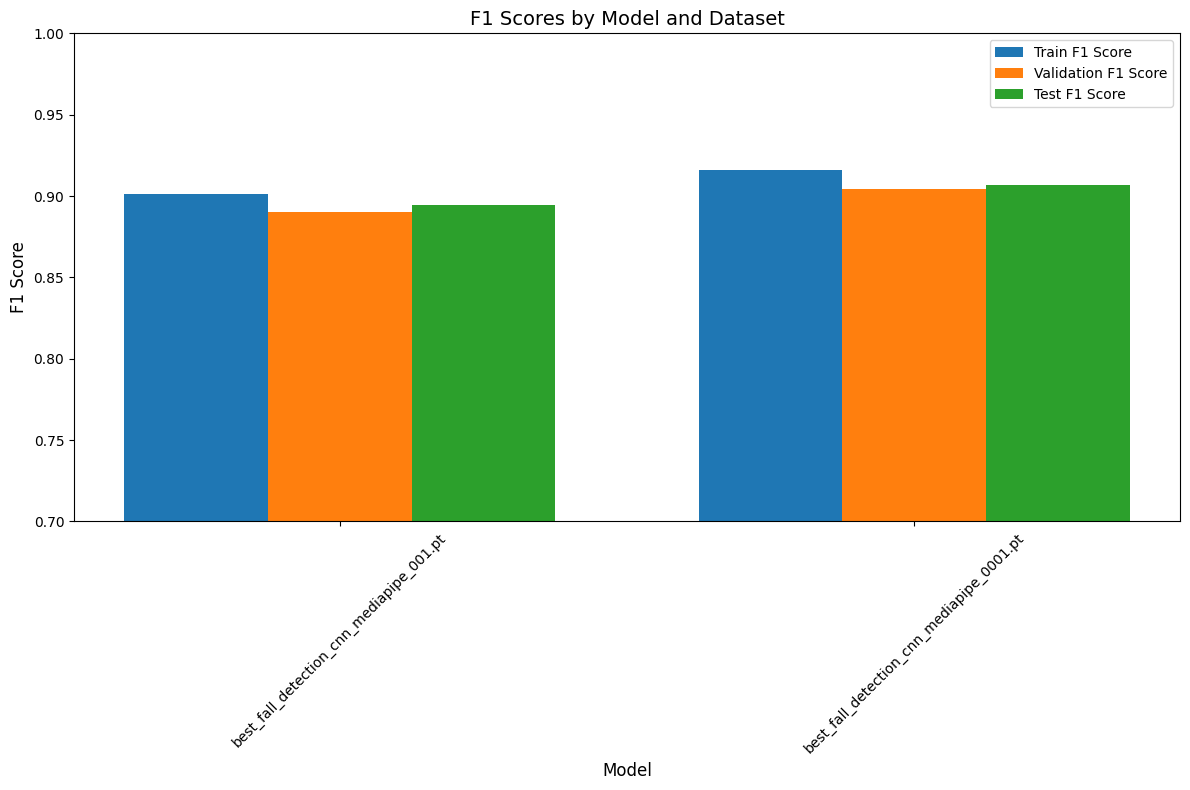

In [19]:
# 그래프용 데이터 변환
model_names = [result['Model'] for result in results]
train_scores = [result['Train'] for result in results]
val_scores = [result['Validation'] for result in results]
test_scores = [result['Test'] for result in results]

# 그래프 생성
plt.figure(figsize=(12, 8))
bar_width = 0.25
indices = range(len(model_names))

# 막대 그래프
plt.bar(indices, train_scores, bar_width, label="Train F1 Score")
plt.bar([i + bar_width for i in indices], val_scores, bar_width, label="Validation F1 Score")
plt.bar([i + 2 * bar_width for i in indices], test_scores, bar_width, label="Test F1 Score")

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Scores by Model and Dataset", fontsize=14)
plt.xticks([i + bar_width for i in indices], model_names, rotation=45, fontsize=10)
plt.ylim(0.7, 1.0)
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

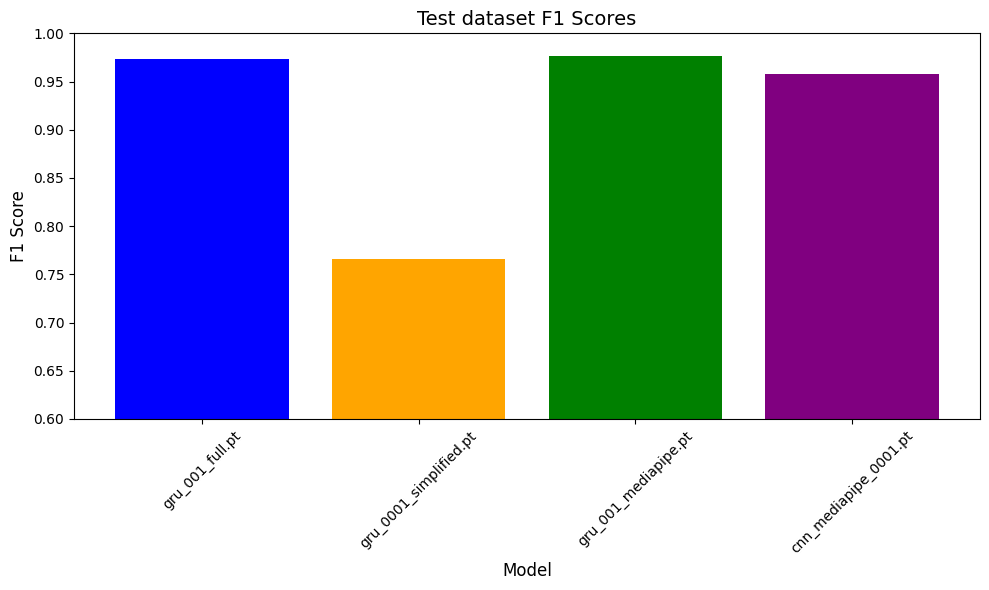

In [20]:
model_f1_scores = [
    ('best_fall_detection_gru_001_full.pt', 0.9729),
    ('best_fall_detection_gru_0001_simplified.pt', 0.7662),
    ('best_fall_detection_gru_001_mediapipe.pt', 0.9761),
    ('best_fall_detection_cnn_mediapipe_0001.pt', 0.9576)
]

# 모델명과 Test F1 Scores를 분리하여 리스트로 저장
model_names = [name.split('best_fall_detection_')[1] for name, _ in model_f1_scores]
train_f1_scores = [x[1] for x in model_f1_scores]

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(model_names, train_f1_scores, color=['blue', 'orange', 'green', 'purple'])

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("Test dataset F1 Scores", fontsize=14)
plt.ylim(0.6, 1.0)

# x축 라벨의 가독성을 위해 회전 추가
plt.xticks(rotation=45, fontsize=10)

# 그래프 출력
plt.tight_layout()
plt.show()

### (돌려놓고 자기 위해 7번 코드도 밑에 임시로 붙임)

In [21]:
import os
import cv2
import torch
import mediapipe as mp
import numpy as np
import torch.nn as nn
from ultralytics import YOLO
from scipy.spatial import distance
from torch.nn.functional import softmax
from collections import defaultdict
from tqdm import tqdm

# Load YOLOv8s model
yolo_model = YOLO('D:\\Falldown\\code-git\\runs\\detect\\human_fall_s30\\weights\\best.pt')

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False)

# 랜드마크 인덱스 정의 # 11개
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]

# GRU 기반 낙상 감지 모델 정의
class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=3):
        super(FallDetectionGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(2, x.size(0), 128).to(x.device)  # 초기 은닉 상태 정의
        out, _ = self.gru(x, h_0)
        out = self.fc(out[:, -1, :])  # 마지막 time step의 출력을 사용
        return out

def load_gru_model(model_path):
    # 모델을 생성할 때 올바른 input_size를 사용
    if "full" in model_path:
        input_size = 25
    elif "simplified" in model_path:
        input_size = 3
    elif "mediapipe" in model_path:
        input_size = 22
    else:
        raise ValueError("Unknown model type in filename. Please check the model name.")

    # FallDetectionGRU 모델 생성 및 가중치 로드
    gru_model = FallDetectionGRU(input_size=input_size, hidden_size=128, num_layers=2, num_classes=3)
    gru_model.load_state_dict(torch.load(model_path, map_location='cpu'))
    gru_model.eval()

    return gru_model, input_size

def bbox_ratio_class(ratio):
    return 0 if ratio < 0.7 else 1 # 0.7 이상은 Normal일 확률이 높음

def calculate_yolo_xy_ratio(bbox):
    # bbox가 비어 있지 않고, 폭(width)이 0이 아닌 경우에만 계산
    if len(bbox) > 0 and (bbox[2] - bbox[0]) != 0:
        return round((bbox[3] - bbox[1]) / (bbox[2] - bbox[0]), 3)
    return 0.0

# Head and upper body speed calculation
def calculate_head_upper_body_speed(sequence):
    speeds = []
    for j in range(1, len(sequence)):
        keypoints = sequence[j]
        prev_keypoints = sequence[j - 1]
        h = np.array([keypoints[0][0], keypoints[0][1]])  # Head
        l = np.array([keypoints[11][0], keypoints[11][1]])  # Left shoulder
        r = np.array([keypoints[12][0], keypoints[12][1]])  # Right shoulder

        prev_h = np.array([prev_keypoints[0][0], prev_keypoints[0][1]])
        prev_l = np.array([prev_keypoints[11][0], prev_keypoints[11][1]])
        prev_r = np.array([prev_keypoints[12][0], prev_keypoints[12][1]])

        center_new = (h + l + r) / 3
        center_prev = (prev_h + prev_l + prev_r) / 3

        speeds.append(distance.euclidean(center_new, center_prev))

    return sum(speeds) / len(speeds) if speeds else 0.0

# 바운딩 박스 크기 조절(20% 확대)
def adjust_bbox(bbox, scale_factor, frame_shape):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    new_width = width * scale_factor
    new_height = height * scale_factor
    
    new_x1 = max(0, int(center_x - new_width / 2))
    new_y1 = max(0, int(center_y - new_height / 2))
    new_x2 = min(int(center_x + new_width / 2), frame_shape[1])  # 우측 하단 x 좌표를 조정, 이미지 폭(frame_shape[1]) 초과 방지
    new_y2 = min(int(center_y + new_height / 2), frame_shape[0])  # 우측 하단 y 좌표를 조정, 이미지 높이(frame_shape[0]) 초과 방지
    
    return [new_x1, new_y1, new_x2, new_y2]

# 샘플 Video를 분석하는 함수
def process_video(video_path, output_path, model_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    gru_model, input_size = load_gru_model(model_path)

    frame_idx = 0
    joint_sequence = []  # 속도 계산을 위함
    previous_pred_class = -1  # 이전 프레임의 예측 클래스

    with tqdm(total=total_frames, desc=f"Processing {os.path.basename(video_path)}", unit="frame") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            if frame_idx % 6 == 0:
                # YOLO inference
                results = yolo_model(frame)
                bbox = []

                # 바운딩 박스 추출 및 크기 조정
                for result in results[0].boxes:
                    x1, y1, x2, y2 = map(int, result.xyxy[0])
                    adjusted_bbox = adjust_bbox([x1, y1, x2, y2], scale_factor=1.2, frame_shape=frame.shape)
                    bbox.append((adjusted_bbox[0], adjusted_bbox[1], adjusted_bbox[2], adjusted_bbox[3]))

                # MediaPipe inference
                joint_coords = []
                if len(bbox) > 0:
                    # 조정된 바운딩 박스 사용
                    person_image = frame[bbox[0][1]:bbox[0][3], bbox[0][0]:bbox[0][2]]
                    person_image_rgb = cv2.cvtColor(person_image, cv2.COLOR_BGR2RGB)
                    results_pose = pose.process(person_image_rgb)

                    if results_pose.pose_landmarks:
                        for landmark in results_pose.pose_landmarks.landmark:
                            # 조정된 바운딩 박스 내의 좌표를 전체 프레임의 좌표로 변환
                            global_x = (bbox[0][0] + landmark.x * person_image.shape[1]) / width
                            global_y = (bbox[0][1] + landmark.y * person_image.shape[0]) / height
                            joint_coords.append((global_x * width, global_y * height))
                        joint_sequence.append(joint_coords)

                # Prepare input for GRU
                input_features = []

                if input_size == 25 and len(joint_coords) >= 11 and len(bbox) > 0:
                    # 11개의 랜드마크 정보 추가 (각각 x, y 좌표를 사용)
                    joint_array = []
                    for landmark_idx in LANDMARKS:
                        if landmark_idx < len(joint_coords):
                            x, y = joint_coords[landmark_idx]
                            joint_array.extend([x, y])  # 각 랜드마크의 x, y 좌표 추가
                        else:
                            # 랜드마크가 존재하지 않는 경우, (0, 0)을 추가
                            joint_array.extend([0.0, 0.0])

                    # 추가적인 특징 추가
                    yolo_xy_ratio = calculate_yolo_xy_ratio(bbox[0])  # 바운딩 박스의 정보로부터 계산
                    ratio_class = bbox_ratio_class(yolo_xy_ratio)
                    speed = calculate_head_upper_body_speed(joint_sequence)

                    # 모든 특징들을 하나의 배열로 결합 (총 25개가 되어야 함)
                    input_features = np.array(joint_array)  # 총 22개의 관절 좌표 정보
                    input_features = np.concatenate((input_features, [yolo_xy_ratio, ratio_class, speed]))  # 22 + 3 = 25개의 특징

                    # 길이 확인
                    if len(input_features) != 25:
                        raise ValueError(f"Expected input_features length to be 25, but got {len(input_features)}. Please check the feature extraction.")

                elif input_size == 22 and len(joint_coords) >= 11:
                    # 11개의 랜드마크 좌표만 사용하는 경우 (각각 x, y 좌표)
                    joint_array = []
                    for landmark_idx in LANDMARKS:
                        if landmark_idx < len(joint_coords):
                            x, y = joint_coords[landmark_idx]
                            joint_array.extend([x, y])  # 각 랜드마크의 x, y 좌표 추가
                        else:
                            # 랜드마크가 누락된 경우, (0, 0) 추가
                            joint_array.extend([0.0, 0.0])
                    input_features = np.array(joint_array)

                    # 길이 확인
                    if len(input_features) != 22:
                        raise ValueError(f"Expected input_features length to be 22, but got {len(input_features)}. Please check the joint coordinates.")

                elif input_size == 3 and len(bbox) > 0:
                    # 간소화된 바운딩 박스 정보만 사용하는 경우
                    yolo_xy_ratio = calculate_yolo_xy_ratio(bbox[0])
                    ratio_class = bbox_ratio_class(yolo_xy_ratio)
                    speed = calculate_head_upper_body_speed(joint_sequence)

                    # 3개의 특징으로 구성
                    input_features = np.array([yolo_xy_ratio, ratio_class, speed])

                    # 길이 확인
                    if len(input_features) != 3:
                        raise ValueError(f"Expected input_features length to be 3, but got {len(input_features)}. Please check the bbox features.")

                else:
                    pred_class = previous_pred_class  # 감지되지 않는 경우 이전 예측 클래스를 유지
                    input_features = None

                if input_features is not None:
                    # 입력 텐서의 형태: [input_size] -> [1, 1, input_size]로 변환
                    input_tensor = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, input_size]

                    # GRU 모델에 전달 (sequence_length=1, batch_size=1, input_size=25)
                    output = gru_model(input_tensor)
                    pred_class = torch.argmax(softmax(output, dim=1), dim=1).item()
                    previous_pred_class = pred_class  # 이전 예측 클래스 업데이트
                else:
                    pred_class = previous_pred_class

            # Visualization (클래스에 따른 색상 설정)
            color_map = {
                0: (0, 255, 0),      # Normal: 초록색
                1: (0, 165, 255),    # Danger: 주황색
                2: (0, 0, 255)       # Fall: 빨간색
            }
            label_map = {
                0: 'Normal',    # 비낙상
                1: 'Danger',    # 낙상 위험
                2: 'Fall'       # 완전 낙상
            }
            color = color_map.get(previous_pred_class, (255, 255, 255))  # 기본값은 흰색 (클래스가 없는 경우)
            label_text = label_map.get(previous_pred_class, 'Unknown')   # 기본값은 'Unknown' (클래스가 없는 경우)

            # 바운딩 박스 그리기
            for box in bbox:
                x1, y1, x2, y2 = box
                label = f"Class: {label_text}"  # 클래스 이름을 직접 출력
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness=3)  # 바운딩 박스 테두리 두께를 3으로 설정
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, thickness=3)  # 글자 크기 및 두께 설정

            out.write(frame) # frame 저장
            pbar.update(1) # tqdm 업데이트
            frame_idx += 1

    cap.release()
    out.release()


model_group = ['best_fall_detection_gru_001_full.pt', 'best_fall_detection_gru_001_mediapipe.pt',
               'best_fall_detection_gru_0001_simplified.pt', 'best_fall_detection_cnn_mediapipe_0001.pt']

video_group = ['D:\\Falldown\\Dataset\\Video_Dataset\\Video\Test\\00028_H_A_FY_C1.mp4', #1
               'D:\\Falldown\\Dataset\\Video_Dataset\\Video\Test\\00130_H_A_FY_C2.mp4', #2
               'D:\\Falldown\\Dataset\\Video_Dataset\\Video\Test\\00712_H_D_BY_C3.mp4', #3
               'D:\\Falldown\\Dataset\\Video_Dataset\\Video\Test\\02900_Y_C_BY_C4.mp4', #4
               'D:\\Falldown\\Dataset\\Video_Dataset\\Video\Test\\02087_H_A_SY_C5.mp4', #5
               'D:\\Falldown\\Dataset\\Video_Dataset\\Video\Test\\01757_Y_E_SY_C6.mp4', #6
               'D:\\Falldown\\Dataset\\Video_Dataset\\Video\Test\\00690_H_D_N_C7.mp4', #7
               'D:\\Falldown\\Dataset\\Video_Dataset\\Video\Test\\00799_O_E_N_C8.mp4'  #8
]

output_directory = 'D:\\Falldown\\code-git'

# Video 샘플 처리
for model_path in model_group:
    for video_path in video_group:
        suffix = f"_{model_path.split('_')[3]}_{model_path.split('_')[5].replace('.pt', '')}.mp4" if '_gru_' in model_path else f"_{model_path.split('_')[3]}.mp4" # suffix를 사용하여 각 파일에 따라 구분되는 파일명 만들기
        video_name, _ = os.path.splitext(os.path.basename(video_path)) # 비디오 파일명 추출
        output_filename = f"{video_name}{suffix}"
        output_path = os.path.join(output_directory, output_filename)

        process_video(video_path, output_path, model_path) # 비디오 처리 함수 호출

Processing 00028_H_A_FY_C1.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 72.0ms
Speed: 4.0ms preprocess, 72.0ms inference, 42.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   1%|          | 4/600 [00:01<03:37,  2.74frame/s]


0: 384x640 1 Non_Fall, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   2%|▏         | 10/600 [00:02<01:14,  7.96frame/s]


0: 384x640 1 Non_Fall, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   3%|▎         | 16/600 [00:02<00:43, 13.37frame/s]


0: 384x640 1 Non_Fall, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


c:\Users\CHO\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Processing 00028_H_A_FY_C1.mp4:   4%|▎         | 22/600 [00:02<00:33, 17.37frame/s]


0: 384x640 1 Non_Fall, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   5%|▍         | 28/600 [00:02<00:28, 20.03frame/s]


0: 384x640 1 Non_Fall, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   6%|▌         | 34/600 [00:03<00:27, 20.73frame/s]


0: 384x640 1 Non_Fall, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   7%|▋         | 40/600 [00:03<00:25, 21.96frame/s]


0: 384x640 1 Non_Fall, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   8%|▊         | 46/600 [00:03<00:24, 22.68frame/s]


0: 384x640 1 Non_Fall, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   9%|▊         | 52/600 [00:03<00:24, 22.77frame/s]


0: 384x640 1 Non_Fall, 19.0ms
Speed: 3.0ms preprocess, 19.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  10%|▉         | 58/600 [00:04<00:23, 22.68frame/s]


0: 384x640 1 Non_Fall, 20.0ms
Speed: 2.0ms preprocess, 20.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  11%|█         | 64/600 [00:04<00:23, 22.57frame/s]


0: 384x640 1 Non_Fall, 23.0ms
Speed: 2.0ms preprocess, 23.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  12%|█▏        | 70/600 [00:04<00:23, 22.68frame/s]


0: 384x640 1 Non_Fall, 26.0ms
Speed: 1.0ms preprocess, 26.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  13%|█▎        | 76/600 [00:05<00:23, 21.88frame/s]


0: 384x640 1 Non_Fall, 38.0ms
Speed: 2.0ms preprocess, 38.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  14%|█▎        | 82/600 [00:05<00:23, 21.58frame/s]


0: 384x640 1 Non_Fall, 38.0ms
Speed: 4.0ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  15%|█▍        | 88/600 [00:05<00:23, 21.63frame/s]


0: 384x640 1 Non_Fall, 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  16%|█▌        | 94/600 [00:05<00:23, 21.76frame/s]


0: 384x640 1 Non_Fall, 41.0ms
Speed: 3.0ms preprocess, 41.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  17%|█▋        | 100/600 [00:06<00:24, 20.42frame/s]


0: 384x640 1 Non_Fall, 42.0ms
Speed: 3.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  18%|█▊        | 106/600 [00:06<00:23, 21.09frame/s]


0: 384x640 1 Non_Fall, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  19%|█▊        | 112/600 [00:06<00:23, 20.95frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  20%|█▉        | 118/600 [00:07<00:24, 19.98frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  21%|██        | 124/600 [00:07<00:24, 19.78frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  22%|██▏       | 130/600 [00:07<00:23, 20.35frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  23%|██▎       | 136/600 [00:08<00:23, 19.41frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  24%|██▎       | 142/600 [00:08<00:22, 20.00frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  25%|██▍       | 148/600 [00:08<00:22, 19.93frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  26%|██▌       | 154/600 [00:09<00:22, 19.42frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  27%|██▋       | 160/600 [00:09<00:22, 19.71frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  28%|██▊       | 166/600 [00:09<00:21, 20.20frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  29%|██▊       | 172/600 [00:10<00:22, 19.16frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  30%|██▉       | 178/600 [00:10<00:21, 19.76frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  31%|███       | 184/600 [00:10<00:21, 19.78frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 6.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  32%|███▏      | 190/600 [00:11<00:20, 20.04frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  33%|███▎      | 196/600 [00:11<00:20, 19.38frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  34%|███▎      | 202/600 [00:11<00:20, 19.87frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  35%|███▍      | 208/600 [00:12<00:19, 19.93frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 5.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  36%|███▌      | 214/600 [00:12<00:19, 19.59frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  37%|███▋      | 220/600 [00:12<00:19, 19.63frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  38%|███▊      | 226/600 [00:13<00:18, 20.02frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  39%|███▊      | 232/600 [00:13<00:18, 19.64frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  40%|███▉      | 238/600 [00:13<00:17, 20.18frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  41%|████      | 244/600 [00:13<00:18, 19.71frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  42%|████▏     | 250/600 [00:14<00:17, 20.21frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  43%|████▎     | 256/600 [00:14<00:17, 20.20frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  44%|████▎     | 262/600 [00:14<00:16, 20.52frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  45%|████▍     | 268/600 [00:15<00:16, 19.88frame/s]


0: 384x640 1 Fall, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  46%|████▌     | 274/600 [00:15<00:15, 20.58frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  47%|████▋     | 280/600 [00:15<00:15, 20.51frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  48%|████▊     | 286/600 [00:16<00:15, 19.85frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  49%|████▊     | 292/600 [00:16<00:15, 20.04frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  50%|████▉     | 298/600 [00:16<00:14, 20.72frame/s]


0: 384x640 1 Fall, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  51%|█████     | 304/600 [00:17<00:15, 19.71frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  52%|█████▏    | 310/600 [00:17<00:14, 20.27frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  53%|█████▎    | 316/600 [00:17<00:13, 20.33frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  54%|█████▎    | 322/600 [00:18<00:13, 20.63frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  55%|█████▍    | 328/600 [00:18<00:13, 19.79frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  56%|█████▌    | 334/600 [00:18<00:13, 20.28frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  57%|█████▋    | 340/600 [00:19<00:12, 20.21frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  58%|█████▊    | 346/600 [00:19<00:12, 20.26frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  59%|█████▊    | 352/600 [00:19<00:12, 20.30frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  60%|█████▉    | 358/600 [00:19<00:12, 20.07frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  61%|██████    | 364/600 [00:20<00:11, 19.91frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  62%|██████▏   | 371/600 [00:20<00:10, 21.23frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  63%|██████▎   | 377/600 [00:20<00:10, 20.91frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  64%|██████▍   | 383/600 [00:21<00:10, 20.40frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  65%|██████▍   | 389/600 [00:21<00:10, 20.43frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  66%|██████▌   | 395/600 [00:21<00:09, 20.66frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  67%|██████▋   | 401/600 [00:22<00:10, 19.67frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  68%|██████▊   | 407/600 [00:22<00:09, 20.37frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  69%|██████▉   | 413/600 [00:22<00:09, 20.36frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  70%|██████▉   | 419/600 [00:23<00:09, 20.03frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  71%|███████   | 425/600 [00:23<00:08, 19.71frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  72%|███████▏  | 431/600 [00:23<00:08, 20.12frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  73%|███████▎  | 437/600 [00:24<00:08, 20.14frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  74%|███████▍  | 443/600 [00:24<00:07, 19.91frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  75%|███████▍  | 449/600 [00:24<00:07, 19.98frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  76%|███████▌  | 455/600 [00:25<00:07, 20.40frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  77%|███████▋  | 461/600 [00:25<00:06, 20.36frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  78%|███████▊  | 467/600 [00:25<00:06, 20.59frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  79%|███████▉  | 473/600 [00:25<00:06, 20.24frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  80%|███████▉  | 479/600 [00:26<00:06, 19.52frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  81%|████████  | 485/600 [00:26<00:05, 20.00frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  82%|████████▏ | 491/600 [00:26<00:05, 20.61frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  83%|████████▎ | 497/600 [00:27<00:05, 19.79frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  84%|████████▍ | 503/600 [00:27<00:04, 20.36frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  85%|████████▍ | 509/600 [00:27<00:04, 20.42frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  86%|████████▌ | 515/600 [00:28<00:04, 19.85frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 57.0ms
Speed: 5.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  87%|████████▋ | 521/600 [00:28<00:03, 20.10frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  88%|████████▊ | 527/600 [00:28<00:03, 20.61frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  89%|████████▉ | 533/600 [00:29<00:03, 19.49frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  90%|████████▉ | 539/600 [00:29<00:03, 20.20frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  91%|█████████ | 545/600 [00:29<00:02, 20.26frame/s]


0: 384x640 1 Non_Fall, 63.3ms
Speed: 3.0ms preprocess, 63.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  92%|█████████▏| 551/600 [00:30<00:02, 20.47frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  93%|█████████▎| 557/600 [00:30<00:02, 19.78frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  94%|█████████▍| 563/600 [00:30<00:01, 20.39frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  95%|█████████▍| 569/600 [00:31<00:01, 20.23frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  96%|█████████▌| 575/600 [00:31<00:01, 20.43frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  97%|█████████▋| 581/600 [00:31<00:00, 20.16frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  98%|█████████▊| 587/600 [00:31<00:00, 20.49frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  99%|█████████▉| 593/600 [00:32<00:00, 20.04frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 4.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   1%|          | 4/600 [00:00<00:41, 14.32frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   2%|▏         | 11/600 [00:00<00:30, 19.01frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   3%|▎         | 17/600 [00:00<00:29, 19.77frame/s]


0: 384x640 1 Non_Fall, 69.0ms
Speed: 3.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   4%|▍         | 23/600 [00:01<00:28, 20.22frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   5%|▍         | 29/600 [00:01<00:28, 20.21frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   6%|▌         | 35/600 [00:01<00:27, 20.32frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   7%|▋         | 41/600 [00:02<00:27, 20.32frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   8%|▊         | 47/600 [00:02<00:27, 20.12frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   9%|▉         | 53/600 [00:02<00:26, 20.34frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  10%|▉         | 59/600 [00:03<00:25, 20.89frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  11%|█         | 65/600 [00:03<00:26, 19.82frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  12%|█▏        | 71/600 [00:03<00:25, 20.36frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  13%|█▎        | 77/600 [00:04<00:25, 20.48frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  14%|█▍        | 83/600 [00:04<00:26, 19.72frame/s]


0: 384x640 1 Non_Fall, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  15%|█▍        | 89/600 [00:04<00:25, 20.23frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  16%|█▌        | 95/600 [00:05<00:24, 20.57frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  17%|█▋        | 101/600 [00:05<00:24, 20.31frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  18%|█▊        | 107/600 [00:05<00:24, 20.00frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  19%|█▉        | 113/600 [00:05<00:23, 20.31frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  20%|█▉        | 119/600 [00:06<00:23, 20.55frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  21%|██        | 125/600 [00:06<00:24, 19.28frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  22%|██▏       | 132/600 [00:06<00:22, 20.97frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 5.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  23%|██▎       | 138/600 [00:07<00:21, 21.08frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  24%|██▎       | 141/600 [00:07<00:25, 17.95frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  25%|██▍       | 148/600 [00:07<00:22, 19.76frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  26%|██▌       | 154/600 [00:08<00:21, 20.51frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  27%|██▋       | 160/600 [00:08<00:22, 19.60frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  28%|██▊       | 166/600 [00:08<00:21, 20.26frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  29%|██▊       | 172/600 [00:09<00:21, 20.15frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  30%|██▉       | 178/600 [00:09<00:21, 19.61frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  31%|███       | 184/600 [00:09<00:20, 20.04frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  32%|███▏      | 190/600 [00:10<00:19, 20.51frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  33%|███▎      | 196/600 [00:10<00:19, 20.30frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  34%|███▎      | 202/600 [00:10<00:19, 20.03frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  35%|███▍      | 208/600 [00:10<00:19, 20.21frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  36%|███▌      | 214/600 [00:11<00:18, 20.35frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  37%|███▋      | 220/600 [00:11<00:19, 19.68frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  38%|███▊      | 226/600 [00:11<00:18, 20.25frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  39%|███▊      | 232/600 [00:12<00:18, 20.35frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  40%|███▉      | 238/600 [00:12<00:17, 20.60frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  41%|████      | 244/600 [00:12<00:17, 20.24frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  42%|████▏     | 250/600 [00:13<00:16, 20.64frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  43%|████▎     | 256/600 [00:13<00:17, 20.20frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  44%|████▎     | 262/600 [00:13<00:16, 20.82frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  45%|████▍     | 268/600 [00:14<00:16, 20.70frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  46%|████▌     | 274/600 [00:14<00:16, 19.72frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  47%|████▋     | 280/600 [00:14<00:15, 20.01frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  48%|████▊     | 286/600 [00:15<00:15, 20.46frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  49%|████▊     | 292/600 [00:15<00:15, 19.74frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  50%|████▉     | 298/600 [00:15<00:15, 20.06frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  51%|█████     | 304/600 [00:16<00:14, 20.35frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  52%|█████▏    | 310/600 [00:16<00:14, 20.62frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  53%|█████▎    | 316/600 [00:16<00:14, 19.69frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  54%|█████▎    | 322/600 [00:16<00:13, 20.28frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 6.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  55%|█████▍    | 328/600 [00:17<00:13, 20.11frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  56%|█████▌    | 334/600 [00:17<00:13, 20.17frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 5.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  57%|█████▋    | 340/600 [00:17<00:12, 20.15frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  58%|█████▊    | 346/600 [00:18<00:12, 20.70frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  59%|█████▊    | 352/600 [00:18<00:12, 20.23frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  60%|█████▉    | 358/600 [00:18<00:11, 20.23frame/s]


0: 384x640 1 Non_Fall, 60.3ms
Speed: 4.0ms preprocess, 60.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  61%|██████    | 364/600 [00:19<00:11, 20.43frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  62%|██████▏   | 370/600 [00:19<00:11, 19.90frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  63%|██████▎   | 376/600 [00:19<00:11, 20.18frame/s]


0: 384x640 1 Non_Fall, 64.1ms
Speed: 3.0ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  64%|██████▍   | 383/600 [00:20<00:10, 21.35frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  65%|██████▍   | 389/600 [00:20<00:10, 19.98frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  66%|██████▌   | 396/600 [00:20<00:09, 21.22frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  67%|██████▋   | 402/600 [00:21<00:09, 21.05frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  68%|██████▊   | 408/600 [00:21<00:09, 20.35frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  69%|██████▉   | 414/600 [00:21<00:09, 20.53frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  70%|███████   | 420/600 [00:22<00:08, 20.94frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  71%|███████   | 426/600 [00:22<00:08, 20.81frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  72%|███████▏  | 432/600 [00:22<00:08, 20.97frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  73%|███████▎  | 438/600 [00:22<00:07, 20.68frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  74%|███████▍  | 444/600 [00:23<00:07, 20.98frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  75%|███████▌  | 450/600 [00:23<00:07, 20.41frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  76%|███████▌  | 456/600 [00:23<00:06, 20.86frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  77%|███████▋  | 462/600 [00:24<00:06, 20.85frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  78%|███████▊  | 468/600 [00:24<00:06, 20.02frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 4.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  79%|███████▉  | 474/600 [00:24<00:06, 20.41frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  80%|████████  | 480/600 [00:25<00:05, 20.41frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  81%|████████  | 486/600 [00:25<00:05, 19.62frame/s]


0: 384x640 1 Non_Fall, 61.4ms
Speed: 3.0ms preprocess, 61.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  82%|████████▏ | 492/600 [00:25<00:05, 20.53frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  83%|████████▎ | 498/600 [00:26<00:04, 20.62frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  84%|████████▍ | 504/600 [00:26<00:04, 21.00frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 4.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  85%|████████▌ | 510/600 [00:26<00:04, 20.69frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  86%|████████▌ | 516/600 [00:26<00:04, 20.84frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  87%|████████▋ | 522/600 [00:27<00:03, 20.78frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  88%|████████▊ | 528/600 [00:27<00:03, 20.39frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  89%|████████▉ | 534/600 [00:27<00:03, 20.64frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  90%|█████████ | 540/600 [00:28<00:02, 21.00frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  91%|█████████ | 546/600 [00:28<00:02, 20.12frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  92%|█████████▏| 552/600 [00:28<00:02, 20.78frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  93%|█████████▎| 558/600 [00:29<00:02, 20.70frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 4.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  94%|█████████▍| 564/600 [00:29<00:01, 19.78frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 5.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  95%|█████████▌| 570/600 [00:29<00:01, 20.02frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  96%|█████████▌| 576/600 [00:30<00:01, 20.70frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  97%|█████████▋| 582/600 [00:30<00:00, 20.32frame/s]


0: 384x640 1 Non_Fall, 63.3ms
Speed: 4.0ms preprocess, 63.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  98%|█████████▊| 588/600 [00:30<00:00, 20.32frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  99%|█████████▉| 594/600 [00:31<00:00, 20.58frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   1%|          | 4/600 [00:00<00:39, 15.11frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   2%|▏         | 11/600 [00:00<00:28, 20.68frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   3%|▎         | 18/600 [00:00<00:28, 20.56frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   4%|▎         | 21/600 [00:01<00:30, 18.74frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   5%|▍         | 29/600 [00:01<00:26, 21.21frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   6%|▌         | 36/600 [00:01<00:25, 21.70frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   6%|▋         | 39/600 [00:02<00:29, 19.07frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   8%|▊         | 47/600 [00:02<00:25, 21.68frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   9%|▉         | 54/600 [00:02<00:24, 22.30frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  10%|█         | 60/600 [00:03<00:25, 21.31frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  10%|█         | 63/600 [00:03<00:27, 19.21frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  12%|█▏        | 71/600 [00:03<00:24, 21.76frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  13%|█▎        | 78/600 [00:03<00:23, 22.27frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  14%|█▎        | 81/600 [00:04<00:26, 19.60frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  15%|█▍        | 89/600 [00:04<00:23, 21.58frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  16%|█▌        | 95/600 [00:04<00:23, 21.28frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  17%|█▋        | 102/600 [00:05<00:23, 21.56frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  18%|█▊        | 105/600 [00:05<00:25, 19.66frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  19%|█▉        | 113/600 [00:05<00:22, 21.47frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  20%|█▉        | 119/600 [00:06<00:23, 20.83frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  21%|██        | 126/600 [00:06<00:21, 21.86frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  22%|██▏       | 129/600 [00:06<00:23, 19.87frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  23%|██▎       | 137/600 [00:06<00:21, 21.65frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  24%|██▍       | 144/600 [00:07<00:20, 22.52frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  24%|██▍       | 147/600 [00:07<00:22, 19.77frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  26%|██▌       | 155/600 [00:07<00:20, 21.51frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  27%|██▋       | 162/600 [00:08<00:20, 21.51frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  28%|██▊       | 165/600 [00:08<00:22, 19.69frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  29%|██▉       | 173/600 [00:08<00:19, 21.62frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  30%|██▉       | 179/600 [00:08<00:19, 21.38frame/s]


0: 384x640 1 Fall, 59.3ms
Speed: 3.0ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  31%|███       | 186/600 [00:09<00:18, 21.80frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  32%|███▏      | 189/600 [00:09<00:20, 19.84frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  33%|███▎      | 197/600 [00:09<00:18, 21.57frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  34%|███▍      | 204/600 [00:10<00:17, 22.19frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  34%|███▍      | 207/600 [00:10<00:20, 19.55frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  36%|███▌      | 215/600 [00:10<00:18, 21.34frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  37%|███▋      | 221/600 [00:11<00:18, 20.57frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  38%|███▊      | 228/600 [00:11<00:17, 21.84frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  38%|███▊      | 231/600 [00:11<00:19, 19.34frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  40%|███▉      | 239/600 [00:11<00:17, 20.79frame/s]


0: 384x640 1 Fall, 63.3ms
Speed: 3.0ms preprocess, 63.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  41%|████      | 246/600 [00:12<00:16, 21.32frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  42%|████▏     | 249/600 [00:12<00:17, 19.53frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  43%|████▎     | 257/600 [00:12<00:16, 21.21frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  44%|████▍     | 264/600 [00:13<00:15, 22.09frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  44%|████▍     | 267/600 [00:13<00:17, 19.57frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  46%|████▌     | 274/600 [00:13<00:15, 20.62frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  47%|████▋     | 280/600 [00:14<00:15, 20.15frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  48%|████▊     | 287/600 [00:14<00:14, 21.34frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  49%|████▉     | 294/600 [00:14<00:13, 21.97frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  50%|█████     | 300/600 [00:15<00:14, 20.60frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  50%|█████     | 303/600 [00:15<00:16, 18.53frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  52%|█████▏    | 311/600 [00:15<00:13, 21.34frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  53%|█████▎    | 317/600 [00:15<00:13, 21.23frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  54%|█████▍    | 324/600 [00:16<00:12, 22.05frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  55%|█████▍    | 327/600 [00:16<00:13, 19.51frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  56%|█████▌    | 335/600 [00:16<00:12, 21.46frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  57%|█████▋    | 342/600 [00:17<00:11, 21.61frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  57%|█████▊    | 345/600 [00:17<00:12, 19.74frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  59%|█████▊    | 352/600 [00:17<00:12, 20.63frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  60%|█████▉    | 358/600 [00:17<00:11, 20.92frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  61%|██████    | 365/600 [00:18<00:10, 21.55frame/s]


0: 384x640 1 Fall, 68.0ms
Speed: 4.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  62%|██████▏   | 372/600 [00:18<00:10, 22.33frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  62%|██████▎   | 375/600 [00:18<00:11, 19.77frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 4.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  64%|██████▍   | 383/600 [00:19<00:09, 21.71frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  65%|██████▌   | 390/600 [00:19<00:09, 22.10frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  66%|██████▌   | 393/600 [00:19<00:10, 19.57frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  67%|██████▋   | 400/600 [00:20<00:09, 20.21frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  68%|██████▊   | 407/600 [00:20<00:08, 21.86frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  69%|██████▉   | 414/600 [00:20<00:08, 22.31frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  70%|███████   | 420/600 [00:21<00:08, 21.10frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  70%|███████   | 423/600 [00:21<00:09, 18.66frame/s]


0: 384x640 1 Fall, 69.0ms
Speed: 3.0ms preprocess, 69.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  72%|███████▏  | 431/600 [00:21<00:07, 21.17frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  73%|███████▎  | 438/600 [00:21<00:07, 21.90frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  74%|███████▎  | 441/600 [00:22<00:08, 19.84frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  75%|███████▍  | 449/600 [00:22<00:06, 21.68frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  76%|███████▌  | 456/600 [00:22<00:06, 22.04frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  76%|███████▋  | 459/600 [00:23<00:07, 18.87frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  78%|███████▊  | 467/600 [00:23<00:06, 21.54frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  79%|███████▉  | 474/600 [00:23<00:05, 21.95frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  80%|████████  | 480/600 [00:24<00:05, 21.02frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  80%|████████  | 483/600 [00:24<00:06, 18.93frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  82%|████████▏ | 491/600 [00:24<00:05, 21.58frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  83%|████████▎ | 498/600 [00:24<00:04, 22.09frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  84%|████████▎ | 501/600 [00:25<00:05, 19.72frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  85%|████████▍ | 509/600 [00:25<00:04, 21.55frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  86%|████████▌ | 516/600 [00:25<00:03, 21.96frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  86%|████████▋ | 519/600 [00:26<00:04, 18.49frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  88%|████████▊ | 527/600 [00:26<00:03, 21.20frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  89%|████████▉ | 534/600 [00:26<00:03, 21.90frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  90%|█████████ | 540/600 [00:27<00:02, 20.93frame/s]


0: 384x640 1 Fall, 59.3ms
Speed: 3.0ms preprocess, 59.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  90%|█████████ | 543/600 [00:27<00:03, 18.91frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  92%|█████████▏| 551/600 [00:27<00:02, 21.49frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  93%|█████████▎| 558/600 [00:27<00:01, 22.09frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  94%|█████████▎| 561/600 [00:28<00:01, 19.65frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  95%|█████████▍| 569/600 [00:28<00:01, 21.52frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  96%|█████████▌| 576/600 [00:28<00:01, 21.96frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  96%|█████████▋| 579/600 [00:29<00:01, 18.64frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  98%|█████████▊| 587/600 [00:29<00:00, 21.29frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  99%|█████████▉| 594/600 [00:29<00:00, 22.02frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   1%|          | 4/600 [00:00<00:41, 14.25frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   2%|▏         | 11/600 [00:00<00:29, 20.03frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   3%|▎         | 17/600 [00:00<00:30, 19.31frame/s]


0: 384x640 1 Fall, 68.3ms
Speed: 3.0ms preprocess, 68.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   4%|▍         | 24/600 [00:01<00:27, 21.07frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   5%|▌         | 30/600 [00:01<00:27, 20.77frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   6%|▌         | 36/600 [00:01<00:28, 19.65frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   7%|▋         | 42/600 [00:02<00:27, 20.24frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   8%|▊         | 48/600 [00:02<00:26, 21.09frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   9%|▉         | 54/600 [00:02<00:26, 20.40frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  10%|▉         | 57/600 [00:03<00:29, 18.31frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  11%|█         | 64/600 [00:03<00:27, 19.68frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  12%|█▏        | 71/600 [00:03<00:24, 21.23frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  13%|█▎        | 78/600 [00:04<00:24, 21.31frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  14%|█▎        | 81/600 [00:04<00:26, 19.41frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  15%|█▍        | 88/600 [00:04<00:25, 20.38frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  16%|█▌        | 94/600 [00:04<00:26, 19.24frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  17%|█▋        | 100/600 [00:05<00:25, 19.92frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  18%|█▊        | 107/600 [00:05<00:23, 21.32frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  19%|█▉        | 113/600 [00:05<00:24, 20.18frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  20%|██        | 120/600 [00:06<00:22, 21.40frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  21%|██        | 126/600 [00:06<00:22, 20.96frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  22%|██▏       | 132/600 [00:06<00:23, 20.20frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  22%|██▎       | 135/600 [00:07<00:25, 18.04frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  24%|██▍       | 143/600 [00:07<00:21, 20.78frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  25%|██▍       | 149/600 [00:07<00:21, 20.67frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 4.0ms preprocess, 66.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  26%|██▌       | 156/600 [00:08<00:21, 21.00frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  26%|██▋       | 159/600 [00:08<00:23, 18.62frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  28%|██▊       | 167/600 [00:08<00:20, 21.05frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  29%|██▉       | 174/600 [00:09<00:20, 21.16frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  30%|███       | 180/600 [00:09<00:19, 21.29frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  31%|███       | 186/600 [00:09<00:19, 20.88frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  32%|███▏      | 192/600 [00:09<00:19, 20.41frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  33%|███▎      | 198/600 [00:10<00:19, 20.50frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  34%|███▍      | 204/600 [00:10<00:18, 20.95frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  35%|███▌      | 210/600 [00:10<00:19, 19.58frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  36%|███▌      | 213/600 [00:11<00:21, 17.59frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  37%|███▋      | 220/600 [00:11<00:19, 19.52frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  38%|███▊      | 227/600 [00:11<00:17, 21.17frame/s]


0: 384x640 1 Fall, 61.8ms
Speed: 5.0ms preprocess, 61.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  39%|███▉      | 234/600 [00:12<00:17, 20.92frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  40%|███▉      | 237/600 [00:12<00:19, 19.05frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  41%|████      | 244/600 [00:12<00:17, 20.26frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  42%|████▏     | 250/600 [00:13<00:16, 20.60frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  43%|████▎     | 256/600 [00:13<00:16, 20.57frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  44%|████▍     | 263/600 [00:13<00:15, 21.66frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  45%|████▌     | 270/600 [00:14<00:15, 21.25frame/s]


0: 384x640 1 Fall, 61.3ms
Speed: 3.0ms preprocess, 61.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  46%|████▌     | 273/600 [00:14<00:17, 18.70frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  47%|████▋     | 280/600 [00:14<00:16, 19.95frame/s]


0: 384x640 1 Fall, 66.3ms
Speed: 2.0ms preprocess, 66.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  48%|████▊     | 286/600 [00:14<00:15, 19.75frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  49%|████▊     | 292/600 [00:15<00:15, 20.32frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  50%|████▉     | 299/600 [00:15<00:13, 21.68frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  51%|█████     | 305/600 [00:15<00:14, 20.45frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  52%|█████▏    | 312/600 [00:16<00:13, 21.27frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  52%|█████▎    | 315/600 [00:16<00:15, 18.81frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  54%|█████▍    | 323/600 [00:16<00:13, 21.19frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  55%|█████▌    | 330/600 [00:17<00:12, 21.42frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  56%|█████▌    | 333/600 [00:17<00:14, 18.75frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  57%|█████▋    | 340/600 [00:17<00:13, 20.00frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  58%|█████▊    | 346/600 [00:17<00:12, 20.35frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  59%|█████▊    | 352/600 [00:18<00:12, 20.44frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  60%|█████▉    | 359/600 [00:18<00:11, 21.83frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 6.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  61%|██████    | 365/600 [00:18<00:11, 20.14frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  62%|██████▏   | 372/600 [00:19<00:10, 21.63frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  62%|██████▎   | 375/600 [00:19<00:11, 19.05frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  64%|██████▍   | 383/600 [00:19<00:10, 21.41frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  65%|██████▌   | 390/600 [00:20<00:10, 20.90frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  66%|██████▌   | 396/600 [00:20<00:09, 20.73frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  66%|██████▋   | 399/600 [00:20<00:10, 18.43frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  68%|██████▊   | 407/600 [00:21<00:09, 20.94frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  69%|██████▉   | 414/600 [00:21<00:08, 21.54frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  70%|██████▉   | 417/600 [00:21<00:09, 19.46frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  71%|███████   | 424/600 [00:21<00:08, 19.99frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  72%|███████▏  | 431/600 [00:22<00:07, 21.40frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  73%|███████▎  | 438/600 [00:22<00:07, 21.65frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  74%|███████▍  | 444/600 [00:22<00:07, 20.65frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  74%|███████▍  | 447/600 [00:23<00:08, 18.41frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  76%|███████▌  | 454/600 [00:23<00:07, 19.85frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  77%|███████▋  | 460/600 [00:23<00:06, 20.26frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 6.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  78%|███████▊  | 466/600 [00:24<00:06, 20.03frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  79%|███████▉  | 473/600 [00:24<00:06, 21.03frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  80%|████████  | 480/600 [00:24<00:05, 21.92frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  80%|████████  | 483/600 [00:25<00:06, 19.05frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  82%|████████▏ | 491/600 [00:25<00:05, 21.18frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  83%|████████▎ | 498/600 [00:25<00:04, 21.55frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  84%|████████▎ | 501/600 [00:25<00:05, 18.68frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  85%|████████▍ | 508/600 [00:26<00:04, 20.01frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  86%|████████▌ | 514/600 [00:26<00:04, 20.25frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  87%|████████▋ | 520/600 [00:26<00:04, 19.57frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  88%|████████▊ | 526/600 [00:27<00:03, 20.46frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  89%|████████▊ | 532/600 [00:27<00:03, 20.58frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  90%|████████▉ | 539/600 [00:27<00:02, 21.24frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  91%|█████████ | 546/600 [00:28<00:02, 20.68frame/s]


0: 384x640 1 Fall, 62.8ms
Speed: 3.0ms preprocess, 62.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  92%|█████████▏| 549/600 [00:28<00:02, 18.95frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  93%|█████████▎| 556/600 [00:28<00:02, 20.22frame/s]


0: 384x640 1 Fall, 56.0ms
Speed: 4.0ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  94%|█████████▍| 563/600 [00:29<00:01, 21.14frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  95%|█████████▌| 570/600 [00:29<00:01, 21.51frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  96%|█████████▌| 576/600 [00:29<00:01, 21.03frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  96%|█████████▋| 579/600 [00:29<00:01, 18.30frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  98%|█████████▊| 587/600 [00:30<00:00, 21.10frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  99%|█████████▉| 594/600 [00:30<00:00, 21.69frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   1%|          | 4/600 [00:00<00:42, 14.07frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   2%|▏         | 11/600 [00:00<00:29, 20.19frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   3%|▎         | 17/600 [00:00<00:28, 20.12frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 4.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   4%|▍         | 23/600 [00:01<00:28, 20.50frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   5%|▍         | 29/600 [00:01<00:27, 20.60frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   6%|▌         | 35/600 [00:01<00:27, 20.35frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   7%|▋         | 41/600 [00:02<00:27, 20.63frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   8%|▊         | 47/600 [00:02<00:26, 21.04frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   9%|▉         | 53/600 [00:02<00:27, 19.86frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  10%|▉         | 59/600 [00:03<00:26, 20.72frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 5.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  11%|█         | 66/600 [00:03<00:24, 21.69frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  12%|█▏        | 72/600 [00:03<00:24, 21.13frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  12%|█▎        | 75/600 [00:03<00:28, 18.45frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  14%|█▍        | 83/600 [00:04<00:24, 21.03frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  15%|█▍        | 89/600 [00:04<00:24, 21.02frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  16%|█▌        | 95/600 [00:04<00:24, 20.82frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  17%|█▋        | 101/600 [00:05<00:23, 20.97frame/s]


0: 384x640 1 Non_Fall, 61.2ms
Speed: 2.0ms preprocess, 61.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  18%|█▊        | 107/600 [00:05<00:23, 21.12frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  19%|█▉        | 113/600 [00:05<00:24, 20.07frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  20%|█▉        | 119/600 [00:06<00:23, 20.73frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  21%|██        | 126/600 [00:06<00:22, 21.34frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  22%|██▏       | 132/600 [00:06<00:22, 20.52frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  23%|██▎       | 138/600 [00:07<00:22, 20.79frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  24%|██▎       | 141/600 [00:07<00:24, 18.87frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  25%|██▍       | 148/600 [00:07<00:22, 20.27frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  26%|██▌       | 154/600 [00:07<00:21, 20.52frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  27%|██▋       | 160/600 [00:08<00:21, 20.75frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  28%|██▊       | 166/600 [00:08<00:20, 21.00frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  29%|██▊       | 172/600 [00:08<00:20, 20.55frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  30%|██▉       | 179/600 [00:09<00:19, 21.84frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  31%|███       | 185/600 [00:09<00:19, 21.28frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  32%|███▏      | 191/600 [00:09<00:20, 20.14frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  33%|███▎      | 197/600 [00:10<00:19, 20.55frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  34%|███▍      | 203/600 [00:10<00:18, 21.01frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  35%|███▍      | 209/600 [00:10<00:19, 20.29frame/s]


0: 384x640 1 Non_Fall, 61.3ms
Speed: 3.0ms preprocess, 61.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  36%|███▌      | 215/600 [00:11<00:18, 20.58frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  37%|███▋      | 221/600 [00:11<00:18, 20.70frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  38%|███▊      | 227/600 [00:11<00:17, 20.88frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  39%|███▉      | 233/600 [00:11<00:17, 20.87frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  40%|███▉      | 239/600 [00:12<00:17, 20.63frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  41%|████      | 245/600 [00:12<00:17, 20.39frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  42%|████▏     | 252/600 [00:12<00:16, 21.22frame/s]


0: 384x640 1 Non_Fall, 62.4ms
Speed: 3.0ms preprocess, 62.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  42%|████▎     | 255/600 [00:13<00:18, 18.83frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  44%|████▍     | 263/600 [00:13<00:15, 21.16frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  45%|████▍     | 269/600 [00:13<00:16, 19.90frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  46%|████▌     | 275/600 [00:14<00:15, 20.58frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  47%|████▋     | 281/600 [00:14<00:15, 20.65frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  48%|████▊     | 287/600 [00:14<00:15, 20.53frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  49%|████▉     | 293/600 [00:15<00:15, 20.30frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  50%|████▉     | 299/600 [00:15<00:14, 20.88frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  51%|█████     | 305/600 [00:15<00:14, 20.74frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  52%|█████▏    | 311/600 [00:15<00:13, 20.88frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  53%|█████▎    | 317/600 [00:16<00:13, 20.94frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 5.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  54%|█████▍    | 323/600 [00:16<00:13, 21.05frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  55%|█████▍    | 329/600 [00:16<00:13, 20.39frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  56%|█████▌    | 335/600 [00:17<00:12, 20.70frame/s]


0: 384x640 1 Fall, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  57%|█████▋    | 341/600 [00:17<00:12, 21.03frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  58%|█████▊    | 347/600 [00:17<00:12, 20.11frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  59%|█████▉    | 353/600 [00:18<00:12, 20.55frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  60%|█████▉    | 359/600 [00:18<00:11, 20.64frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  61%|██████    | 365/600 [00:18<00:11, 20.41frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 5.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  62%|██████▏   | 371/600 [00:19<00:11, 20.55frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  63%|██████▎   | 378/600 [00:19<00:10, 21.45frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  64%|██████▍   | 384/600 [00:19<00:10, 21.59frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  64%|██████▍   | 387/600 [00:19<00:11, 18.90frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  66%|██████▌   | 395/600 [00:20<00:09, 21.44frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  67%|██████▋   | 401/600 [00:20<00:09, 21.38frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  68%|██████▊   | 407/600 [00:20<00:09, 20.57frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  69%|██████▉   | 414/600 [00:21<00:08, 21.45frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  70%|██████▉   | 417/600 [00:21<00:09, 19.52frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  71%|███████   | 424/600 [00:21<00:08, 20.71frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  72%|███████▏  | 431/600 [00:22<00:07, 21.14frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  73%|███████▎  | 437/600 [00:22<00:07, 21.06frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  74%|███████▍  | 443/600 [00:22<00:07, 21.22frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  75%|███████▍  | 449/600 [00:22<00:07, 20.96frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  76%|███████▌  | 456/600 [00:23<00:06, 21.86frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  77%|███████▋  | 462/600 [00:23<00:06, 21.48frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  78%|███████▊  | 468/600 [00:23<00:06, 20.63frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  79%|███████▉  | 474/600 [00:24<00:06, 20.73frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  80%|████████  | 480/600 [00:24<00:05, 20.80frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  81%|████████  | 486/600 [00:24<00:05, 20.07frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  82%|████████▏ | 489/600 [00:25<00:06, 18.29frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  83%|████████▎ | 496/600 [00:25<00:05, 19.74frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  84%|████████▎ | 502/600 [00:25<00:04, 20.56frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.3ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  85%|████████▍ | 508/600 [00:26<00:04, 19.96frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  86%|████████▌ | 514/600 [00:26<00:04, 20.63frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  87%|████████▋ | 520/600 [00:26<00:03, 20.81frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  88%|████████▊ | 526/600 [00:26<00:03, 20.84frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  89%|████████▊ | 532/600 [00:27<00:03, 20.79frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 6.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  90%|████████▉ | 539/600 [00:27<00:02, 21.59frame/s]


0: 384x640 1 Fall, 70.0ms
Speed: 3.0ms preprocess, 70.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  91%|█████████ | 545/600 [00:27<00:02, 20.62frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  92%|█████████▏| 552/600 [00:28<00:02, 21.73frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  93%|█████████▎| 558/600 [00:28<00:01, 21.36frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  94%|█████████▍| 564/600 [00:28<00:01, 20.45frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  94%|█████████▍| 567/600 [00:29<00:01, 18.31frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  96%|█████████▌| 575/600 [00:29<00:01, 20.87frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  97%|█████████▋| 581/600 [00:29<00:00, 20.18frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  98%|█████████▊| 587/600 [00:30<00:00, 20.26frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  99%|█████████▉| 594/600 [00:30<00:00, 21.17frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   1%|          | 4/600 [00:00<00:40, 14.71frame/s]


0: 384x640 1 Non_Fall, 61.8ms
Speed: 3.0ms preprocess, 61.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   2%|▏         | 11/600 [00:00<00:28, 20.56frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   3%|▎         | 17/600 [00:00<00:29, 19.89frame/s]


0: 384x640 1 Non_Fall, 69.0ms
Speed: 6.0ms preprocess, 69.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   4%|▍         | 24/600 [00:01<00:26, 21.51frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   5%|▌         | 30/600 [00:01<00:26, 21.17frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   6%|▌         | 36/600 [00:01<00:27, 20.84frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   6%|▋         | 39/600 [00:02<00:30, 18.24frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   8%|▊         | 47/600 [00:02<00:25, 21.34frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   9%|▉         | 54/600 [00:02<00:24, 21.92frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  10%|▉         | 57/600 [00:03<00:28, 19.04frame/s]


0: 384x640 1 Non_Fall, 60.3ms
Speed: 3.0ms preprocess, 60.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  11%|█         | 64/600 [00:03<00:26, 20.50frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  12%|█▏        | 71/600 [00:03<00:24, 21.83frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  13%|█▎        | 77/600 [00:03<00:25, 20.41frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  14%|█▍        | 83/600 [00:04<00:24, 21.14frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  15%|█▌        | 90/600 [00:04<00:23, 21.76frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  16%|█▌        | 96/600 [00:04<00:24, 20.98frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 6.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  16%|█▋        | 99/600 [00:05<00:27, 18.35frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  18%|█▊        | 107/600 [00:05<00:23, 21.22frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  19%|█▉        | 114/600 [00:05<00:22, 21.89frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  20%|█▉        | 117/600 [00:06<00:25, 19.31frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  21%|██        | 125/600 [00:06<00:22, 21.28frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  22%|██▏       | 132/600 [00:06<00:20, 22.37frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  23%|██▎       | 138/600 [00:07<00:22, 20.80frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  24%|██▎       | 141/600 [00:07<00:23, 19.13frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  25%|██▍       | 148/600 [00:07<00:21, 20.57frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  26%|██▌       | 154/600 [00:07<00:21, 20.79frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  27%|██▋       | 161/600 [00:08<00:21, 20.75frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  28%|██▊       | 168/600 [00:08<00:19, 21.90frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  28%|██▊       | 171/600 [00:08<00:22, 19.48frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  30%|██▉       | 179/600 [00:09<00:19, 21.37frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  31%|███       | 186/600 [00:09<00:19, 21.68frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  32%|███▏      | 189/600 [00:09<00:20, 19.62frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  33%|███▎      | 196/600 [00:10<00:20, 19.68frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  34%|███▎      | 202/600 [00:10<00:19, 20.57frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  35%|███▍      | 208/600 [00:10<00:18, 20.80frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  36%|███▌      | 214/600 [00:10<00:19, 20.15frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  37%|███▋      | 220/600 [00:11<00:18, 20.12frame/s]


0: 384x640 1 Fall, 59.3ms
Speed: 3.0ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  38%|███▊      | 227/600 [00:11<00:17, 21.63frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  39%|███▉      | 233/600 [00:11<00:17, 21.37frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  40%|████      | 240/600 [00:12<00:16, 21.58frame/s]


0: 384x640 1 Fall, 61.4ms
Speed: 3.0ms preprocess, 61.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  40%|████      | 243/600 [00:12<00:18, 19.10frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 4.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  42%|████▏     | 251/600 [00:12<00:16, 21.36frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  43%|████▎     | 257/600 [00:13<00:16, 20.70frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  44%|████▍     | 263/600 [00:13<00:15, 21.19frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  45%|████▍     | 269/600 [00:13<00:15, 20.98frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  46%|████▌     | 275/600 [00:14<00:16, 19.81frame/s]


0: 384x640 1 Non_Fall, 63.3ms
Speed: 3.0ms preprocess, 63.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  47%|████▋     | 282/600 [00:14<00:15, 21.01frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  48%|████▊     | 285/600 [00:14<00:16, 19.16frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  49%|████▊     | 292/600 [00:14<00:15, 20.32frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  50%|████▉     | 299/600 [00:15<00:14, 21.00frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  51%|█████     | 305/600 [00:15<00:14, 20.84frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  52%|█████▏    | 311/600 [00:15<00:13, 21.07frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  53%|█████▎    | 317/600 [00:16<00:13, 20.74frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  54%|█████▍    | 324/600 [00:16<00:12, 21.83frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  55%|█████▌    | 330/600 [00:16<00:12, 21.01frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  56%|█████▌    | 333/600 [00:17<00:14, 17.95frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  57%|█████▋    | 341/600 [00:17<00:12, 20.57frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  58%|█████▊    | 348/600 [00:17<00:11, 21.92frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  59%|█████▉    | 354/600 [00:18<00:11, 20.84frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  60%|█████▉    | 357/600 [00:18<00:12, 19.12frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  61%|██████    | 365/600 [00:18<00:11, 21.26frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  62%|██████▏   | 372/600 [00:18<00:10, 21.89frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  62%|██████▎   | 375/600 [00:19<00:11, 18.94frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  64%|██████▍   | 383/600 [00:19<00:10, 21.46frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  65%|██████▌   | 390/600 [00:19<00:09, 22.05frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  66%|██████▌   | 393/600 [00:20<00:10, 18.94frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  67%|██████▋   | 400/600 [00:20<00:09, 20.28frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  68%|██████▊   | 407/600 [00:20<00:08, 21.71frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  69%|██████▉   | 413/600 [00:21<00:09, 20.44frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  70%|███████   | 420/600 [00:21<00:08, 21.75frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  70%|███████   | 423/600 [00:21<00:09, 19.10frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  72%|███████▏  | 431/600 [00:21<00:07, 21.15frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  73%|███████▎  | 438/600 [00:22<00:07, 21.27frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  74%|███████▎  | 441/600 [00:22<00:08, 19.43frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  75%|███████▍  | 448/600 [00:22<00:07, 20.76frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  76%|███████▌  | 454/600 [00:23<00:07, 20.57frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  77%|███████▋  | 461/600 [00:23<00:06, 21.36frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  78%|███████▊  | 468/600 [00:23<00:05, 22.26frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  78%|███████▊  | 471/600 [00:23<00:06, 18.80frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  80%|███████▉  | 479/600 [00:24<00:05, 21.13frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  81%|████████  | 486/600 [00:24<00:05, 21.76frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  82%|████████▏ | 492/600 [00:24<00:05, 20.78frame/s]


0: 384x640 1 Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  82%|████████▎ | 495/600 [00:25<00:05, 18.43frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  84%|████████▍ | 503/600 [00:25<00:04, 21.08frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  85%|████████▌ | 510/600 [00:25<00:04, 21.49frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 5.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  86%|████████▌ | 516/600 [00:26<00:04, 20.87frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  86%|████████▋ | 519/600 [00:26<00:04, 18.60frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  88%|████████▊ | 527/600 [00:26<00:03, 21.22frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 6.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  89%|████████▉ | 534/600 [00:27<00:03, 21.32frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  90%|████████▉ | 537/600 [00:27<00:03, 19.44frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  91%|█████████ | 545/600 [00:27<00:02, 21.29frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  92%|█████████▏| 551/600 [00:28<00:02, 20.50frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  93%|█████████▎| 558/600 [00:28<00:01, 21.13frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  94%|█████████▎| 561/600 [00:28<00:02, 19.16frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  95%|█████████▍| 568/600 [00:28<00:01, 20.49frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  96%|█████████▌| 574/600 [00:29<00:01, 19.95frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  97%|█████████▋| 580/600 [00:29<00:00, 20.38frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  98%|█████████▊| 587/600 [00:29<00:00, 21.69frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  99%|█████████▉| 594/600 [00:30<00:00, 21.38frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   1%|          | 4/600 [00:00<00:41, 14.50frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   2%|▏         | 10/600 [00:00<00:33, 17.50frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   3%|▎         | 16/600 [00:00<00:29, 19.54frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   4%|▎         | 22/600 [00:01<00:28, 20.25frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   5%|▍         | 28/600 [00:01<00:28, 20.03frame/s]


0: 384x640 1 Fall, 58.3ms
Speed: 3.0ms preprocess, 58.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   6%|▌         | 34/600 [00:01<00:28, 20.13frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   7%|▋         | 40/600 [00:02<00:27, 20.36frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   8%|▊         | 47/600 [00:02<00:25, 21.27frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   9%|▉         | 53/600 [00:02<00:26, 20.88frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  10%|▉         | 59/600 [00:03<00:25, 21.02frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  11%|█         | 65/600 [00:03<00:26, 20.29frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 7.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  12%|█▏        | 71/600 [00:03<00:25, 20.69frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  13%|█▎        | 77/600 [00:04<00:25, 20.69frame/s]


0: 384x640 1 Fall, 70.0ms
Speed: 3.0ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  14%|█▍        | 83/600 [00:04<00:26, 19.80frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  15%|█▍        | 89/600 [00:04<00:25, 20.34frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  16%|█▌        | 95/600 [00:05<00:24, 20.38frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 5.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  17%|█▋        | 101/600 [00:05<00:25, 19.56frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  18%|█▊        | 107/600 [00:05<00:24, 20.32frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  19%|█▉        | 113/600 [00:05<00:23, 20.59frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  20%|█▉        | 119/600 [00:06<00:23, 20.86frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  21%|██        | 125/600 [00:06<00:23, 20.41frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  22%|██▏       | 131/600 [00:06<00:22, 20.89frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  23%|██▎       | 137/600 [00:07<00:22, 20.94frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  24%|██▍       | 144/600 [00:07<00:21, 21.30frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  24%|██▍       | 147/600 [00:07<00:23, 18.99frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  26%|██▌       | 154/600 [00:08<00:22, 20.04frame/s]


0: 384x640 1 Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  27%|██▋       | 160/600 [00:08<00:22, 19.32frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  28%|██▊       | 167/600 [00:08<00:20, 20.92frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  29%|██▉       | 173/600 [00:09<00:20, 20.71frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  30%|██▉       | 179/600 [00:09<00:20, 20.09frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  31%|███       | 185/600 [00:09<00:20, 20.59frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  32%|███▏      | 191/600 [00:10<00:19, 20.68frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  33%|███▎      | 197/600 [00:10<00:19, 20.70frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  34%|███▍      | 204/600 [00:10<00:18, 21.05frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  34%|███▍      | 207/600 [00:10<00:20, 18.72frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  36%|███▌      | 214/600 [00:11<00:19, 20.03frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  37%|███▋      | 221/600 [00:11<00:18, 21.02frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  38%|███▊      | 228/600 [00:11<00:16, 21.91frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  38%|███▊      | 231/600 [00:12<00:19, 19.35frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  40%|███▉      | 238/600 [00:12<00:18, 19.52frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  41%|████      | 245/600 [00:12<00:17, 20.77frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  42%|████▏     | 252/600 [00:13<00:15, 21.76frame/s]


0: 384x640 1 Non_Fall, 62.4ms
Speed: 3.0ms preprocess, 62.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  43%|████▎     | 258/600 [00:13<00:16, 20.45frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  44%|████▎     | 261/600 [00:13<00:18, 18.71frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  45%|████▍     | 269/600 [00:14<00:15, 21.03frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  46%|████▌     | 275/600 [00:14<00:15, 20.81frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  47%|████▋     | 282/600 [00:14<00:15, 20.61frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  48%|████▊     | 285/600 [00:14<00:16, 19.00frame/s]


0: 384x640 1 Non_Fall, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  49%|████▊     | 292/600 [00:15<00:15, 20.26frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  50%|████▉     | 299/600 [00:15<00:14, 21.37frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  51%|█████     | 306/600 [00:15<00:13, 21.76frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  52%|█████▏    | 309/600 [00:16<00:14, 19.73frame/s]


0: 384x640 1 Non_Fall, 65.8ms
Speed: 3.0ms preprocess, 65.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  53%|█████▎    | 316/600 [00:16<00:14, 19.78frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  54%|█████▍    | 323/600 [00:16<00:12, 21.40frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  55%|█████▌    | 330/600 [00:17<00:12, 21.92frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  56%|█████▌    | 336/600 [00:17<00:12, 20.43frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  56%|█████▋    | 339/600 [00:17<00:14, 18.47frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  58%|█████▊    | 347/600 [00:17<00:12, 20.96frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  59%|█████▉    | 354/600 [00:18<00:11, 21.08frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 4.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  60%|█████▉    | 357/600 [00:18<00:12, 19.08frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  61%|██████    | 365/600 [00:18<00:11, 21.12frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  62%|██████▏   | 372/600 [00:19<00:10, 22.11frame/s]


0: 384x640 1 Non_Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  62%|██████▎   | 375/600 [00:19<00:11, 18.94frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  64%|██████▍   | 383/600 [00:19<00:10, 21.38frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  65%|██████▌   | 390/600 [00:20<00:09, 21.92frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 6.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  66%|██████▌   | 396/600 [00:20<00:10, 20.04frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  66%|██████▋   | 399/600 [00:20<00:11, 18.23frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  68%|██████▊   | 407/600 [00:21<00:09, 20.86frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  69%|██████▉   | 413/600 [00:21<00:09, 20.59frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  70%|███████   | 420/600 [00:21<00:08, 21.49frame/s]


0: 384x640 1 Non_Fall, 60.3ms
Speed: 2.0ms preprocess, 60.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  70%|███████   | 423/600 [00:21<00:09, 19.22frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  72%|███████▏  | 431/600 [00:22<00:07, 21.41frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  73%|███████▎  | 438/600 [00:22<00:07, 21.66frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  74%|███████▎  | 441/600 [00:22<00:08, 19.67frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  75%|███████▍  | 448/600 [00:23<00:07, 20.67frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  76%|███████▌  | 454/600 [00:23<00:07, 19.79frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  77%|███████▋  | 461/600 [00:23<00:06, 21.02frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  78%|███████▊  | 468/600 [00:24<00:05, 22.09frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  79%|███████▉  | 474/600 [00:24<00:06, 20.58frame/s]


0: 384x640 1 Non_Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  80%|███████▉  | 477/600 [00:24<00:06, 18.71frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  81%|████████  | 484/600 [00:24<00:05, 20.07frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  82%|████████▏ | 490/600 [00:25<00:05, 20.70frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  83%|████████▎ | 496/600 [00:25<00:05, 20.19frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 4.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  84%|████████▍ | 503/600 [00:25<00:04, 21.71frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  85%|████████▌ | 510/600 [00:26<00:04, 21.95frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  86%|████████▌ | 513/600 [00:26<00:04, 18.78frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  87%|████████▋ | 520/600 [00:26<00:03, 20.31frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  88%|████████▊ | 527/600 [00:27<00:03, 21.70frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  89%|████████▉ | 533/600 [00:27<00:03, 20.47frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  90%|█████████ | 540/600 [00:27<00:02, 21.77frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  90%|█████████ | 543/600 [00:27<00:02, 19.21frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  92%|█████████▏| 551/600 [00:28<00:02, 20.87frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  93%|█████████▎| 557/600 [00:28<00:02, 20.54frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  94%|█████████▍| 564/600 [00:28<00:01, 21.64frame/s]


0: 384x640 1 Non_Fall, 63.4ms
Speed: 3.0ms preprocess, 63.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  95%|█████████▌| 570/600 [00:29<00:01, 21.18frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  96%|█████████▌| 576/600 [00:29<00:01, 20.63frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  97%|█████████▋| 582/600 [00:29<00:00, 20.90frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  98%|█████████▊| 585/600 [00:30<00:00, 18.79frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  99%|█████████▊| 592/600 [00:30<00:00, 19.93frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   1%|          | 4/600 [00:00<00:41, 14.50frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   2%|▏         | 11/600 [00:00<00:28, 20.39frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   3%|▎         | 17/600 [00:00<00:28, 20.28frame/s]


0: 384x640 1 Non_Fall, 73.0ms
Speed: 3.0ms preprocess, 73.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   4%|▍         | 24/600 [00:01<00:27, 21.29frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   5%|▌         | 30/600 [00:01<00:27, 20.46frame/s]


0: 384x640 1 Non_Fall, 62.4ms
Speed: 3.0ms preprocess, 62.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   6%|▌         | 33/600 [00:01<00:30, 18.67frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   7%|▋         | 40/600 [00:02<00:27, 20.22frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   8%|▊         | 46/600 [00:02<00:27, 19.99frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   9%|▊         | 52/600 [00:02<00:26, 20.47frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  10%|▉         | 58/600 [00:03<00:26, 20.66frame/s]


0: 384x640 1 Non_Fall, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  11%|█         | 64/600 [00:03<00:25, 21.01frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  12%|█▏        | 70/600 [00:03<00:25, 20.51frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 4.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  13%|█▎        | 76/600 [00:03<00:25, 20.86frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  14%|█▎        | 82/600 [00:04<00:24, 21.31frame/s]


0: 384x640 1 Non_Fall, 61.3ms
Speed: 3.0ms preprocess, 61.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  15%|█▍        | 88/600 [00:04<00:24, 20.81frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  16%|█▌        | 94/600 [00:04<00:24, 21.05frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  17%|█▋        | 100/600 [00:05<00:24, 20.43frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  18%|█▊        | 106/600 [00:05<00:24, 20.19frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  19%|█▊        | 112/600 [00:05<00:23, 20.39frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  20%|█▉        | 119/600 [00:06<00:22, 21.55frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  21%|██        | 125/600 [00:06<00:23, 19.89frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  22%|██▏       | 131/600 [00:06<00:22, 20.84frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 6.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  23%|██▎       | 137/600 [00:07<00:22, 20.73frame/s]


0: 384x640 1 Non_Fall, 62.7ms
Speed: 2.0ms preprocess, 62.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  24%|██▍       | 143/600 [00:07<00:21, 20.86frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  25%|██▍       | 149/600 [00:07<00:22, 20.26frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  26%|██▌       | 155/600 [00:08<00:21, 20.85frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  27%|██▋       | 161/600 [00:08<00:21, 20.64frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  28%|██▊       | 167/600 [00:08<00:20, 21.01frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  29%|██▉       | 173/600 [00:08<00:20, 20.88frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  30%|██▉       | 179/600 [00:09<00:19, 21.08frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  31%|███       | 185/600 [00:09<00:20, 20.42frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  32%|███▏      | 191/600 [00:09<00:19, 20.85frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  33%|███▎      | 197/600 [00:10<00:19, 20.75frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  34%|███▍      | 203/600 [00:10<00:19, 19.94frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  35%|███▍      | 209/600 [00:10<00:19, 20.14frame/s]


0: 384x640 1 Non_Fall, 65.4ms
Speed: 3.0ms preprocess, 65.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  36%|███▌      | 215/600 [00:11<00:18, 20.54frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  37%|███▋      | 221/600 [00:11<00:19, 19.67frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  38%|███▊      | 227/600 [00:11<00:18, 20.28frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  39%|███▉      | 233/600 [00:12<00:17, 20.50frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  40%|███▉      | 239/600 [00:12<00:17, 20.25frame/s]


0: 384x640 1 Non_Fall, 56.0ms
Speed: 6.0ms preprocess, 56.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  41%|████      | 245/600 [00:12<00:17, 19.80frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  42%|████▏     | 252/600 [00:13<00:16, 21.40frame/s]


0: 384x640 1 Non_Fall, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  43%|████▎     | 258/600 [00:13<00:16, 21.24frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  44%|████▍     | 264/600 [00:13<00:15, 21.01frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  45%|████▌     | 270/600 [00:13<00:15, 20.92frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  46%|████▌     | 276/600 [00:14<00:15, 21.15frame/s]


0: 384x640 1 Non_Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  47%|████▋     | 282/600 [00:14<00:15, 20.02frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  48%|████▊     | 288/600 [00:14<00:15, 20.46frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  49%|████▉     | 294/600 [00:15<00:15, 20.32frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  50%|█████     | 300/600 [00:15<00:15, 19.62frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  51%|█████     | 306/600 [00:15<00:14, 20.03frame/s]


0: 384x640 1 Non_Fall, 61.4ms
Speed: 3.0ms preprocess, 61.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  52%|█████▏    | 312/600 [00:16<00:13, 20.62frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  53%|█████▎    | 318/600 [00:16<00:14, 19.68frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  54%|█████▍    | 324/600 [00:16<00:13, 20.24frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  55%|█████▌    | 330/600 [00:17<00:13, 20.28frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  56%|█████▌    | 336/600 [00:17<00:12, 20.43frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 4.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  57%|█████▋    | 342/600 [00:17<00:12, 20.31frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  58%|█████▊    | 348/600 [00:18<00:12, 20.80frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  59%|█████▉    | 354/600 [00:18<00:11, 20.63frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  60%|██████    | 360/600 [00:18<00:12, 19.98frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  60%|██████    | 363/600 [00:18<00:13, 17.91frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  62%|██████▏   | 371/600 [00:19<00:11, 20.65frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  63%|██████▎   | 377/600 [00:19<00:11, 19.95frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  64%|██████▍   | 383/600 [00:19<00:10, 20.62frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  65%|██████▍   | 389/600 [00:20<00:10, 20.54frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  66%|██████▌   | 395/600 [00:20<00:10, 19.84frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  67%|██████▋   | 401/600 [00:20<00:09, 20.43frame/s]


0: 384x640 1 Non_Fall, 56.3ms
Speed: 4.0ms preprocess, 56.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  68%|██████▊   | 407/600 [00:21<00:09, 20.85frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  69%|██████▉   | 413/600 [00:21<00:09, 20.42frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  70%|██████▉   | 419/600 [00:21<00:08, 20.32frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  71%|███████   | 425/600 [00:22<00:08, 20.05frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  72%|███████▏  | 431/600 [00:22<00:08, 20.68frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  73%|███████▎  | 437/600 [00:22<00:07, 20.48frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  74%|███████▍  | 443/600 [00:22<00:07, 20.79frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  75%|███████▍  | 449/600 [00:23<00:07, 20.64frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  76%|███████▌  | 455/600 [00:23<00:07, 20.50frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  77%|███████▋  | 461/600 [00:23<00:06, 20.45frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 5.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  78%|███████▊  | 467/600 [00:24<00:06, 20.66frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  79%|███████▉  | 473/600 [00:24<00:06, 19.68frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  80%|███████▉  | 479/600 [00:24<00:06, 19.92frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  81%|████████  | 485/600 [00:25<00:05, 20.22frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  82%|████████▏ | 491/600 [00:25<00:05, 19.41frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  83%|████████▎ | 497/600 [00:25<00:05, 20.01frame/s]


0: 384x640 1 Non_Fall, 62.3ms
Speed: 3.0ms preprocess, 62.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  84%|████████▍ | 503/600 [00:26<00:04, 20.68frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  85%|████████▍ | 509/600 [00:26<00:04, 20.34frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  86%|████████▌ | 515/600 [00:26<00:04, 20.31frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  87%|████████▋ | 521/600 [00:27<00:03, 20.44frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  88%|████████▊ | 527/600 [00:27<00:03, 20.48frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  89%|████████▉ | 533/600 [00:27<00:03, 20.32frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  90%|████████▉ | 539/600 [00:27<00:02, 20.70frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  91%|█████████ | 545/600 [00:28<00:02, 20.59frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  92%|█████████▏| 551/600 [00:28<00:02, 20.42frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  93%|█████████▎| 557/600 [00:28<00:02, 20.48frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  94%|█████████▍| 563/600 [00:29<00:01, 20.66frame/s]


0: 384x640 1 Non_Fall, 70.0ms
Speed: 3.0ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  95%|█████████▍| 569/600 [00:29<00:01, 19.58frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  96%|█████████▌| 575/600 [00:29<00:01, 20.39frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  97%|█████████▋| 581/600 [00:30<00:00, 20.40frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  98%|█████████▊| 587/600 [00:30<00:00, 19.69frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  99%|█████████▉| 593/600 [00:30<00:00, 20.17frame/s]


0: 384x640 1 Non_Fall, 61.4ms
Speed: 3.0ms preprocess, 61.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   1%|          | 4/600 [00:00<00:45, 13.09frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   2%|▏         | 10/600 [00:00<00:32, 18.18frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   3%|▎         | 16/600 [00:00<00:30, 19.45frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 6.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   4%|▎         | 22/600 [00:01<00:30, 18.88frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   5%|▍         | 28/600 [00:01<00:29, 19.21frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   6%|▌         | 34/600 [00:01<00:29, 19.31frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   7%|▋         | 40/600 [00:02<00:29, 19.09frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   8%|▊         | 46/600 [00:02<00:27, 19.94frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   9%|▊         | 52/600 [00:02<00:27, 19.93frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 5.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  10%|▉         | 58/600 [00:03<00:28, 19.22frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  11%|█         | 64/600 [00:03<00:27, 19.59frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  12%|█▏        | 70/600 [00:03<00:26, 20.13frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  13%|█▎        | 76/600 [00:04<00:27, 19.21frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  14%|█▎        | 82/600 [00:04<00:25, 19.94frame/s]


0: 384x640 1 Non_Fall, 57.3ms
Speed: 3.0ms preprocess, 57.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  15%|█▍        | 88/600 [00:04<00:25, 20.19frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  16%|█▌        | 94/600 [00:05<00:24, 20.47frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  17%|█▋        | 100/600 [00:05<00:26, 18.96frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  18%|█▊        | 106/600 [00:05<00:24, 19.81frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  19%|█▊        | 112/600 [00:06<00:24, 19.78frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  20%|█▉        | 118/600 [00:06<00:24, 19.47frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  21%|██        | 124/600 [00:06<00:24, 19.50frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  22%|██▏       | 130/600 [00:07<00:23, 20.25frame/s]


0: 384x640 1 Non_Fall, 65.3ms
Speed: 3.0ms preprocess, 65.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  23%|██▎       | 136/600 [00:07<00:23, 19.38frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  24%|██▎       | 142/600 [00:07<00:23, 19.67frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  25%|██▍       | 148/600 [00:08<00:22, 19.81frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  26%|██▌       | 154/600 [00:08<00:22, 19.89frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  27%|██▋       | 160/600 [00:08<00:22, 19.99frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  28%|██▊       | 166/600 [00:09<00:21, 20.14frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  29%|██▊       | 172/600 [00:09<00:21, 19.79frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  30%|██▉       | 178/600 [00:09<00:21, 19.82frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 9.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  31%|███       | 184/600 [00:09<00:21, 19.59frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  32%|███▏      | 190/600 [00:10<00:20, 19.70frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  33%|███▎      | 196/600 [00:10<00:20, 19.82frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  34%|███▎      | 202/600 [00:10<00:19, 20.09frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  35%|███▍      | 208/600 [00:11<00:20, 19.32frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  36%|███▌      | 214/600 [00:11<00:19, 19.88frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  37%|███▋      | 220/600 [00:11<00:19, 19.65frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  38%|███▊      | 226/600 [00:12<00:19, 19.05frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  39%|███▊      | 232/600 [00:12<00:18, 19.60frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  40%|███▉      | 238/600 [00:12<00:17, 20.19frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  41%|████      | 244/600 [00:13<00:18, 18.81frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  42%|████▏     | 250/600 [00:13<00:17, 19.79frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  43%|████▎     | 256/600 [00:13<00:17, 20.09frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  44%|████▎     | 262/600 [00:14<00:17, 19.67frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  45%|████▍     | 268/600 [00:14<00:16, 19.63frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 4.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  46%|████▌     | 274/600 [00:14<00:15, 20.43frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  47%|████▋     | 280/600 [00:15<00:15, 20.33frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  48%|████▊     | 286/600 [00:15<00:15, 19.90frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  49%|████▊     | 292/600 [00:15<00:15, 20.15frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  50%|████▉     | 298/600 [00:16<00:14, 20.56frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  51%|█████     | 304/600 [00:16<00:14, 20.10frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  52%|█████▏    | 310/600 [00:16<00:14, 20.65frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  53%|█████▎    | 316/600 [00:16<00:13, 20.51frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  54%|█████▎    | 322/600 [00:17<00:13, 20.17frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  55%|█████▍    | 328/600 [00:17<00:13, 20.23frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  56%|█████▌    | 334/600 [00:17<00:12, 20.75frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  57%|█████▋    | 340/600 [00:18<00:13, 19.55frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  58%|█████▊    | 346/600 [00:18<00:12, 20.15frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  59%|█████▊    | 352/600 [00:18<00:12, 20.19frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 6.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  60%|█████▉    | 358/600 [00:19<00:12, 18.82frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  61%|██████    | 364/600 [00:19<00:12, 19.61frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  62%|██████▏   | 370/600 [00:19<00:11, 20.23frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  63%|██████▎   | 376/600 [00:20<00:11, 19.23frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  64%|██████▎   | 382/600 [00:20<00:10, 20.27frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  65%|██████▍   | 388/600 [00:20<00:10, 20.17frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  66%|██████▌   | 394/600 [00:21<00:10, 20.59frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  67%|██████▋   | 400/600 [00:21<00:10, 19.63frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  68%|██████▊   | 406/600 [00:21<00:09, 20.30frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  69%|██████▊   | 412/600 [00:22<00:09, 20.21frame/s]


0: 384x640 1 Fall, 57.3ms
Speed: 4.0ms preprocess, 57.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  70%|██████▉   | 418/600 [00:22<00:09, 20.09frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  71%|███████   | 424/600 [00:22<00:08, 20.01frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  72%|███████▏  | 430/600 [00:23<00:08, 20.53frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  73%|███████▎  | 436/600 [00:23<00:08, 20.08frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  74%|███████▎  | 442/600 [00:23<00:07, 20.59frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  75%|███████▍  | 448/600 [00:23<00:07, 20.23frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  76%|███████▌  | 454/600 [00:24<00:07, 19.29frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  77%|███████▋  | 460/600 [00:24<00:07, 19.76frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  78%|███████▊  | 466/600 [00:24<00:06, 20.19frame/s]


0: 384x640 1 Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  79%|███████▊  | 472/600 [00:25<00:06, 19.28frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 6.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  80%|███████▉  | 478/600 [00:25<00:06, 19.50frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  81%|████████  | 484/600 [00:25<00:05, 20.11frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  82%|████████▏ | 490/600 [00:26<00:05, 19.19frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  83%|████████▎ | 496/600 [00:26<00:05, 19.84frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  84%|████████▎ | 502/600 [00:26<00:04, 20.44frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  85%|████████▍ | 508/600 [00:27<00:04, 19.67frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  86%|████████▌ | 514/600 [00:27<00:04, 20.04frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  87%|████████▋ | 520/600 [00:27<00:03, 20.02frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  88%|████████▊ | 526/600 [00:28<00:03, 20.30frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  89%|████████▊ | 532/600 [00:28<00:03, 19.63frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  90%|████████▉ | 538/600 [00:28<00:03, 20.21frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  91%|█████████ | 544/600 [00:29<00:02, 20.21frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  92%|█████████▏| 550/600 [00:29<00:02, 20.01frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  93%|█████████▎| 556/600 [00:29<00:02, 20.20frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  94%|█████████▎| 562/600 [00:30<00:01, 20.35frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  95%|█████████▍| 568/600 [00:30<00:01, 20.04frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  96%|█████████▌| 574/600 [00:30<00:01, 20.34frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  97%|█████████▋| 580/600 [00:30<00:00, 20.35frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  98%|█████████▊| 586/600 [00:31<00:00, 19.91frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  99%|█████████▊| 592/600 [00:31<00:00, 20.13frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   1%|          | 4/600 [00:00<00:42, 13.95frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   2%|▏         | 10/600 [00:00<00:31, 18.79frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   3%|▎         | 16/600 [00:00<00:29, 19.75frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   4%|▎         | 22/600 [00:01<00:28, 20.07frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   5%|▍         | 28/600 [00:01<00:28, 20.16frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   6%|▌         | 34/600 [00:01<00:28, 20.02frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   7%|▋         | 40/600 [00:02<00:28, 19.72frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   8%|▊         | 46/600 [00:02<00:27, 20.14frame/s]


0: 384x640 1 Non_Fall, 58.5ms
Speed: 3.0ms preprocess, 58.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   9%|▊         | 52/600 [00:02<00:26, 20.41frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  10%|▉         | 58/600 [00:03<00:27, 19.47frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  11%|█         | 64/600 [00:03<00:27, 19.65frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  12%|█▏        | 70/600 [00:03<00:26, 20.18frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  13%|█▎        | 76/600 [00:04<00:27, 19.25frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  14%|█▎        | 82/600 [00:04<00:25, 20.09frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  15%|█▍        | 88/600 [00:04<00:25, 20.13frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  16%|█▌        | 94/600 [00:05<00:25, 20.07frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  17%|█▋        | 100/600 [00:05<00:25, 19.62frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  18%|█▊        | 106/600 [00:05<00:24, 20.40frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  19%|█▊        | 112/600 [00:06<00:23, 20.37frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  20%|█▉        | 118/600 [00:06<00:24, 19.90frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  21%|██        | 124/600 [00:06<00:24, 19.39frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  22%|██▏       | 130/600 [00:06<00:22, 20.46frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  23%|██▎       | 136/600 [00:07<00:22, 20.56frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  24%|██▎       | 142/600 [00:07<00:22, 20.30frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  25%|██▍       | 148/600 [00:07<00:21, 20.55frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  26%|██▌       | 154/600 [00:08<00:21, 20.38frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  27%|██▋       | 160/600 [00:08<00:21, 20.44frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  28%|██▊       | 166/600 [00:08<00:21, 20.58frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  29%|██▊       | 172/600 [00:09<00:22, 19.38frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  30%|██▉       | 178/600 [00:09<00:20, 20.21frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  31%|███       | 184/600 [00:09<00:20, 20.20frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  32%|███▏      | 190/600 [00:10<00:20, 19.55frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  33%|███▎      | 196/600 [00:10<00:20, 19.89frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  34%|███▎      | 202/600 [00:10<00:19, 20.38frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  35%|███▍      | 208/600 [00:11<00:19, 20.11frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 6.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  36%|███▌      | 214/600 [00:11<00:19, 19.78frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  37%|███▋      | 220/600 [00:11<00:19, 19.93frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  38%|███▊      | 226/600 [00:12<00:18, 20.35frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  39%|███▊      | 232/600 [00:12<00:18, 19.49frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  40%|███▉      | 238/600 [00:12<00:18, 20.04frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  41%|████      | 244/600 [00:12<00:17, 19.90frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  42%|████▏     | 251/600 [00:13<00:16, 20.92frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  43%|████▎     | 257/600 [00:13<00:16, 20.69frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  44%|████▍     | 263/600 [00:13<00:16, 20.95frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  45%|████▍     | 269/600 [00:14<00:16, 20.28frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  46%|████▌     | 275/600 [00:14<00:15, 20.41frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  47%|████▋     | 281/600 [00:14<00:15, 20.36frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  48%|████▊     | 287/600 [00:15<00:15, 19.58frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  49%|████▉     | 293/600 [00:15<00:15, 20.02frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  50%|████▉     | 299/600 [00:15<00:14, 20.52frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  51%|█████     | 305/600 [00:16<00:15, 19.42frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  52%|█████▏    | 311/600 [00:16<00:14, 20.12frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  53%|█████▎    | 317/600 [00:16<00:14, 20.05frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  54%|█████▍    | 323/600 [00:17<00:14, 19.38frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  55%|█████▍    | 329/600 [00:17<00:13, 19.82frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  56%|█████▌    | 335/600 [00:17<00:12, 20.39frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  57%|█████▋    | 341/600 [00:18<00:12, 20.36frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  58%|█████▊    | 347/600 [00:18<00:12, 20.05frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  59%|█████▉    | 353/600 [00:18<00:12, 20.29frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  60%|█████▉    | 359/600 [00:18<00:11, 20.19frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 4.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  61%|██████    | 365/600 [00:19<00:11, 20.35frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  62%|██████▏   | 371/600 [00:19<00:11, 20.55frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  63%|██████▎   | 377/600 [00:19<00:10, 20.71frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  64%|██████▍   | 383/600 [00:20<00:10, 20.52frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  65%|██████▍   | 389/600 [00:20<00:10, 20.62frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  66%|██████▌   | 395/600 [00:20<00:09, 21.03frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  67%|██████▋   | 401/600 [00:21<00:10, 19.78frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  68%|██████▊   | 407/600 [00:21<00:09, 20.54frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  69%|██████▉   | 413/600 [00:21<00:09, 20.58frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  70%|██████▉   | 419/600 [00:22<00:09, 19.66frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  71%|███████   | 425/600 [00:22<00:08, 19.96frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  72%|███████▏  | 431/600 [00:22<00:08, 20.49frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  73%|███████▎  | 437/600 [00:23<00:07, 20.39frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  74%|███████▍  | 443/600 [00:23<00:07, 20.03frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  75%|███████▍  | 449/600 [00:23<00:07, 20.18frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  76%|███████▌  | 455/600 [00:23<00:06, 20.72frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  77%|███████▋  | 461/600 [00:24<00:06, 20.24frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  78%|███████▊  | 467/600 [00:24<00:06, 20.68frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 6.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  79%|███████▉  | 473/600 [00:24<00:06, 20.63frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  80%|███████▉  | 479/600 [00:25<00:06, 19.81frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  81%|████████  | 485/600 [00:25<00:05, 20.26frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  82%|████████▏ | 491/600 [00:25<00:05, 20.73frame/s]


0: 384x640 1 Non_Fall, 64.5ms
Speed: 2.0ms preprocess, 64.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  83%|████████▎ | 497/600 [00:26<00:05, 19.76frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 6.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  84%|████████▍ | 503/600 [00:26<00:04, 20.47frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  85%|████████▍ | 509/600 [00:26<00:04, 20.55frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  86%|████████▌ | 515/600 [00:27<00:04, 19.66frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  87%|████████▋ | 521/600 [00:27<00:03, 20.23frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  88%|████████▊ | 527/600 [00:27<00:03, 20.39frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  89%|████████▉ | 533/600 [00:28<00:03, 20.43frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  90%|████████▉ | 539/600 [00:28<00:03, 20.13frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  91%|█████████ | 545/600 [00:28<00:02, 20.32frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  92%|█████████▏| 551/600 [00:28<00:02, 20.86frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  93%|█████████▎| 557/600 [00:29<00:02, 20.36frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  94%|█████████▍| 563/600 [00:29<00:01, 20.56frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  95%|█████████▍| 569/600 [00:29<00:01, 20.68frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 4.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  96%|█████████▌| 575/600 [00:30<00:01, 20.09frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  97%|█████████▋| 581/600 [00:30<00:00, 20.28frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  98%|█████████▊| 587/600 [00:30<00:00, 20.25frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  99%|█████████▉| 593/600 [00:31<00:00, 19.58frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   1%|          | 4/600 [00:00<00:40, 14.78frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   2%|▏         | 10/600 [00:00<00:31, 18.86frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   3%|▎         | 16/600 [00:00<00:29, 20.12frame/s]


0: 384x640 1 Non_Fall, 66.3ms
Speed: 3.0ms preprocess, 66.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   4%|▍         | 23/600 [00:01<00:26, 21.72frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 6.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   5%|▍         | 29/600 [00:01<00:27, 20.50frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   6%|▌         | 36/600 [00:01<00:26, 21.30frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   6%|▋         | 39/600 [00:02<00:29, 19.16frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   8%|▊         | 46/600 [00:02<00:27, 20.18frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   9%|▉         | 53/600 [00:02<00:26, 21.02frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  10%|█         | 60/600 [00:03<00:24, 22.26frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  10%|█         | 63/600 [00:03<00:27, 19.54frame/s]


0: 384x640 1 Non_Fall, 66.3ms
Speed: 4.0ms preprocess, 66.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  12%|█▏        | 71/600 [00:03<00:24, 21.56frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  13%|█▎        | 78/600 [00:03<00:23, 22.27frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  14%|█▎        | 81/600 [00:04<00:25, 20.22frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  15%|█▍        | 88/600 [00:04<00:25, 20.19frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  16%|█▌        | 95/600 [00:04<00:23, 21.31frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  17%|█▋        | 102/600 [00:05<00:22, 21.83frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  18%|█▊        | 108/600 [00:05<00:23, 20.96frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  19%|█▉        | 114/600 [00:05<00:23, 20.82frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  20%|█▉        | 117/600 [00:06<00:25, 19.20frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  21%|██        | 124/600 [00:06<00:22, 20.71frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 6.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  22%|██▏       | 131/600 [00:06<00:21, 21.46frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  23%|██▎       | 138/600 [00:07<00:20, 22.25frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  24%|██▎       | 141/600 [00:07<00:23, 19.94frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  25%|██▍       | 148/600 [00:07<00:22, 20.26frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 6.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  26%|██▌       | 155/600 [00:07<00:20, 21.33frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  27%|██▋       | 162/600 [00:08<00:19, 22.01frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  28%|██▊       | 168/600 [00:08<00:20, 20.97frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  29%|██▉       | 174/600 [00:08<00:20, 20.97frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 6.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  30%|██▉       | 177/600 [00:09<00:21, 19.25frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  31%|███       | 185/600 [00:09<00:19, 21.32frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  32%|███▏      | 192/600 [00:09<00:18, 22.11frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  32%|███▎      | 195/600 [00:09<00:20, 19.68frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  34%|███▎      | 202/600 [00:10<00:18, 20.97frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  35%|███▍      | 208/600 [00:10<00:19, 20.44frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  36%|███▌      | 215/600 [00:10<00:18, 21.34frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  37%|███▋      | 222/600 [00:11<00:17, 21.88frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  38%|███▊      | 228/600 [00:11<00:18, 20.60frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  39%|███▉      | 234/600 [00:11<00:17, 20.64frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  40%|███▉      | 237/600 [00:12<00:19, 18.90frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  41%|████      | 244/600 [00:12<00:17, 20.40frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  42%|████▏     | 251/600 [00:12<00:16, 21.02frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 4.0ms preprocess, 57.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  43%|████▎     | 258/600 [00:13<00:15, 21.80frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  44%|████▍     | 264/600 [00:13<00:15, 21.30frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  45%|████▌     | 270/600 [00:13<00:15, 20.92frame/s]


0: 384x640 1 Non_Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  46%|████▌     | 276/600 [00:13<00:15, 20.67frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  46%|████▋     | 279/600 [00:14<00:17, 18.42frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  48%|████▊     | 286/600 [00:14<00:16, 19.45frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  49%|████▊     | 292/600 [00:14<00:15, 19.79frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  50%|████▉     | 299/600 [00:15<00:14, 21.44frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  51%|█████     | 305/600 [00:15<00:14, 20.16frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  52%|█████▏    | 312/600 [00:15<00:13, 21.74frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  52%|█████▎    | 315/600 [00:16<00:14, 19.31frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  54%|█████▎    | 322/600 [00:16<00:13, 20.66frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  55%|█████▍    | 329/600 [00:16<00:12, 21.40frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  56%|█████▌    | 336/600 [00:17<00:12, 21.86frame/s]


0: 384x640 1 Fall, 62.8ms
Speed: 3.0ms preprocess, 62.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  57%|█████▋    | 342/600 [00:17<00:11, 21.52frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  58%|█████▊    | 348/600 [00:17<00:11, 21.06frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  58%|█████▊    | 351/600 [00:17<00:13, 18.74frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  60%|█████▉    | 359/600 [00:18<00:11, 21.45frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  61%|██████    | 365/600 [00:18<00:11, 20.46frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  62%|██████▏   | 372/600 [00:18<00:10, 21.98frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  63%|██████▎   | 378/600 [00:19<00:10, 21.56frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  64%|██████▎   | 381/600 [00:19<00:11, 19.67frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  65%|██████▍   | 389/600 [00:19<00:09, 21.36frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  66%|██████▌   | 396/600 [00:20<00:09, 21.92frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  66%|██████▋   | 399/600 [00:20<00:10, 19.51frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  68%|██████▊   | 406/600 [00:20<00:09, 20.45frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  69%|██████▉   | 413/600 [00:20<00:08, 21.52frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  70%|███████   | 420/600 [00:21<00:07, 22.52frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  71%|███████   | 426/600 [00:21<00:08, 20.82frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  72%|███████▏  | 429/600 [00:21<00:08, 19.20frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  73%|███████▎  | 437/600 [00:22<00:07, 21.20frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  74%|███████▍  | 444/600 [00:22<00:07, 22.15frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  74%|███████▍  | 447/600 [00:22<00:07, 19.26frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  76%|███████▌  | 454/600 [00:22<00:07, 20.49frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  77%|███████▋  | 461/600 [00:23<00:06, 21.52frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  78%|███████▊  | 468/600 [00:23<00:06, 21.96frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  78%|███████▊  | 471/600 [00:23<00:06, 19.61frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  80%|███████▉  | 479/600 [00:24<00:05, 21.82frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  81%|████████  | 485/600 [00:24<00:05, 20.64frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  82%|████████▏ | 492/600 [00:24<00:04, 21.98frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  82%|████████▎ | 495/600 [00:25<00:05, 19.56frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  84%|████████▍ | 503/600 [00:25<00:04, 21.74frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  85%|████████▌ | 510/600 [00:25<00:04, 22.15frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  86%|████████▌ | 513/600 [00:25<00:04, 19.52frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  87%|████████▋ | 521/600 [00:26<00:03, 21.48frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  88%|████████▊ | 528/600 [00:26<00:03, 21.68frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  88%|████████▊ | 531/600 [00:26<00:03, 19.46frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  90%|████████▉ | 539/600 [00:27<00:02, 21.87frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  91%|█████████ | 545/600 [00:27<00:02, 20.76frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  92%|█████████▏| 552/600 [00:27<00:02, 21.70frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  92%|█████████▎| 555/600 [00:28<00:02, 19.30frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  94%|█████████▍| 563/600 [00:28<00:01, 21.62frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  95%|█████████▌| 570/600 [00:28<00:01, 21.87frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  96%|█████████▌| 576/600 [00:28<00:01, 21.37frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  96%|█████████▋| 579/600 [00:29<00:01, 19.06frame/s]


0: 384x640 1 Fall, 65.4ms
Speed: 3.0ms preprocess, 65.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  98%|█████████▊| 586/600 [00:29<00:00, 19.92frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  99%|█████████▉| 593/600 [00:29<00:00, 21.19frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   1%|          | 4/600 [00:00<00:43, 13.62frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   2%|▏         | 10/600 [00:00<00:32, 18.13frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   3%|▎         | 16/600 [00:00<00:29, 19.53frame/s]


0: 384x640 1 Fall, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   4%|▎         | 22/600 [00:01<00:29, 19.44frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 5.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   5%|▍         | 28/600 [00:01<00:28, 20.05frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   6%|▌         | 34/600 [00:01<00:28, 19.99frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   7%|▋         | 40/600 [00:02<00:29, 18.94frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   8%|▊         | 47/600 [00:02<00:26, 20.94frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   9%|▉         | 53/600 [00:02<00:26, 20.76frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  10%|▉         | 59/600 [00:03<00:26, 20.09frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  11%|█         | 65/600 [00:03<00:26, 20.42frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  12%|█▏        | 71/600 [00:03<00:25, 20.88frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  13%|█▎        | 78/600 [00:04<00:25, 20.63frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  14%|█▎        | 81/600 [00:04<00:27, 18.77frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  15%|█▍        | 88/600 [00:04<00:25, 19.85frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  16%|█▌        | 94/600 [00:05<00:25, 20.20frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  17%|█▋        | 100/600 [00:05<00:24, 20.12frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  18%|█▊        | 106/600 [00:05<00:24, 20.53frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  19%|█▊        | 112/600 [00:05<00:23, 20.75frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 10.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  20%|█▉        | 118/600 [00:06<00:23, 20.36frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  21%|██        | 124/600 [00:06<00:22, 20.73frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  22%|██▏       | 131/600 [00:06<00:21, 21.91frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  23%|██▎       | 137/600 [00:07<00:22, 20.36frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  24%|██▍       | 144/600 [00:07<00:20, 21.72frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  24%|██▍       | 147/600 [00:07<00:23, 19.13frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  26%|██▌       | 154/600 [00:08<00:22, 20.16frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  27%|██▋       | 160/600 [00:08<00:22, 19.60frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  28%|██▊       | 167/600 [00:08<00:20, 21.10frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  29%|██▉       | 174/600 [00:09<00:19, 21.52frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 7.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  30%|███       | 180/600 [00:09<00:19, 21.23frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  31%|███       | 186/600 [00:09<00:19, 21.01frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  32%|███▏      | 192/600 [00:10<00:19, 21.32frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  32%|███▎      | 195/600 [00:10<00:22, 18.07frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  34%|███▍      | 203/600 [00:10<00:18, 20.93frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  35%|███▍      | 209/600 [00:10<00:18, 20.78frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  36%|███▌      | 215/600 [00:11<00:19, 19.61frame/s]


0: 384x640 1 Fall, 61.8ms
Speed: 2.0ms preprocess, 61.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  37%|███▋      | 222/600 [00:11<00:18, 20.72frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  38%|███▊      | 228/600 [00:11<00:17, 20.96frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  39%|███▉      | 234/600 [00:12<00:18, 19.68frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  40%|████      | 240/600 [00:12<00:17, 20.73frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  41%|████      | 246/600 [00:12<00:17, 20.59frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  42%|████▏     | 252/600 [00:13<00:16, 20.93frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  43%|████▎     | 258/600 [00:13<00:16, 20.49frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 5.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  44%|████▍     | 264/600 [00:13<00:16, 20.92frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  45%|████▌     | 270/600 [00:14<00:15, 20.74frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  46%|████▌     | 273/600 [00:14<00:18, 17.94frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  47%|████▋     | 280/600 [00:14<00:16, 19.60frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  48%|████▊     | 286/600 [00:14<00:15, 20.49frame/s]


0: 384x640 1 Fall, 69.0ms
Speed: 3.0ms preprocess, 69.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  49%|████▊     | 292/600 [00:15<00:15, 19.52frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  50%|████▉     | 298/600 [00:15<00:14, 20.51frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  51%|█████     | 304/600 [00:15<00:14, 20.51frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  52%|█████▏    | 310/600 [00:16<00:14, 19.87frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  53%|█████▎    | 316/600 [00:16<00:14, 20.26frame/s]


0: 384x640 1 Fall, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  54%|█████▍    | 323/600 [00:16<00:12, 21.48frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  55%|█████▍    | 329/600 [00:17<00:13, 20.84frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  56%|█████▌    | 335/600 [00:17<00:13, 20.05frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  57%|█████▋    | 341/600 [00:17<00:12, 20.35frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  58%|█████▊    | 347/600 [00:18<00:12, 21.04frame/s]


0: 384x640 1 Fall, 65.4ms
Speed: 4.0ms preprocess, 65.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  59%|█████▉    | 354/600 [00:18<00:11, 21.05frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  60%|█████▉    | 357/600 [00:18<00:12, 19.36frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  61%|██████    | 364/600 [00:18<00:11, 20.34frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  62%|██████▏   | 371/600 [00:19<00:10, 21.24frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  63%|██████▎   | 378/600 [00:19<00:10, 21.67frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  64%|██████▎   | 381/600 [00:19<00:11, 19.71frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  65%|██████▍   | 388/600 [00:20<00:10, 19.63frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  66%|██████▌   | 394/600 [00:20<00:10, 19.81frame/s]


0: 384x640 1 Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  67%|██████▋   | 400/600 [00:20<00:09, 20.12frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  68%|██████▊   | 406/600 [00:21<00:09, 20.76frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  69%|██████▊   | 412/600 [00:21<00:09, 20.22frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  70%|██████▉   | 419/600 [00:21<00:08, 21.72frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  71%|███████   | 425/600 [00:22<00:08, 21.10frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 5.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  72%|███████▏  | 432/600 [00:22<00:07, 21.77frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  73%|███████▎  | 438/600 [00:22<00:07, 21.20frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  74%|███████▍  | 444/600 [00:23<00:07, 20.97frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  74%|███████▍  | 447/600 [00:23<00:08, 18.05frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  76%|███████▌  | 454/600 [00:23<00:07, 19.77frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  77%|███████▋  | 460/600 [00:23<00:07, 19.98frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  78%|███████▊  | 466/600 [00:24<00:06, 19.96frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  79%|███████▊  | 472/600 [00:24<00:06, 20.28frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  80%|███████▉  | 479/600 [00:24<00:05, 21.59frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  81%|████████  | 485/600 [00:25<00:05, 20.03frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  82%|████████▏ | 492/600 [00:25<00:05, 21.59frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  83%|████████▎ | 498/600 [00:25<00:04, 20.80frame/s]


0: 384x640 1 Fall, 58.8ms
Speed: 3.0ms preprocess, 58.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  84%|████████▍ | 504/600 [00:26<00:04, 20.96frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  84%|████████▍ | 507/600 [00:26<00:05, 18.20frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  86%|████████▌ | 514/600 [00:26<00:04, 19.86frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  87%|████████▋ | 520/600 [00:27<00:03, 20.42frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  88%|████████▊ | 527/600 [00:27<00:03, 21.58frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  89%|████████▉ | 534/600 [00:27<00:03, 21.96frame/s]


0: 384x640 1 Fall, 61.3ms
Speed: 2.0ms preprocess, 61.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  90%|█████████ | 540/600 [00:27<00:02, 21.72frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  90%|█████████ | 543/600 [00:28<00:03, 17.54frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  92%|█████████▏| 551/600 [00:28<00:02, 20.52frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  93%|█████████▎| 557/600 [00:28<00:02, 20.66frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  94%|█████████▍| 563/600 [00:29<00:01, 19.95frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  95%|█████████▌| 570/600 [00:29<00:01, 21.10frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  96%|█████████▌| 573/600 [00:29<00:01, 18.64frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  97%|█████████▋| 580/600 [00:30<00:00, 20.02frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  98%|█████████▊| 586/600 [00:30<00:00, 19.93frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  99%|█████████▊| 592/600 [00:30<00:00, 20.49frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   1%|          | 4/600 [00:00<00:42, 13.96frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   2%|▏         | 10/600 [00:00<00:31, 18.85frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   3%|▎         | 16/600 [00:00<00:29, 19.77frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   4%|▎         | 22/600 [00:01<00:29, 19.87frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   5%|▍         | 28/600 [00:01<00:28, 20.37frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   6%|▌         | 34/600 [00:01<00:27, 20.68frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.4ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   7%|▋         | 40/600 [00:02<00:27, 20.49frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   8%|▊         | 46/600 [00:02<00:26, 20.97frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   9%|▊         | 52/600 [00:02<00:26, 20.35frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  10%|▉         | 58/600 [00:03<00:26, 20.13frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  11%|█         | 64/600 [00:03<00:26, 20.60frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  12%|█▏        | 70/600 [00:03<00:24, 21.24frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  13%|█▎        | 76/600 [00:04<00:26, 20.04frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  14%|█▍        | 83/600 [00:04<00:23, 21.57frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  15%|█▍        | 89/600 [00:04<00:23, 21.31frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 6.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  16%|█▌        | 95/600 [00:04<00:24, 20.34frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  17%|█▋        | 101/600 [00:05<00:24, 20.35frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  18%|█▊        | 107/600 [00:05<00:23, 20.86frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  19%|█▉        | 113/600 [00:05<00:23, 20.37frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  20%|█▉        | 119/600 [00:06<00:23, 20.37frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  21%|██        | 126/600 [00:06<00:22, 21.11frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  22%|██▏       | 129/600 [00:06<00:24, 19.22frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  23%|██▎       | 136/600 [00:07<00:23, 20.16frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  24%|██▍       | 143/600 [00:07<00:21, 21.65frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  25%|██▌       | 150/600 [00:07<00:20, 21.92frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  26%|██▌       | 156/600 [00:08<00:21, 21.01frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  27%|██▋       | 162/600 [00:08<00:20, 20.98frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  28%|██▊       | 168/600 [00:08<00:20, 21.17frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  29%|██▉       | 174/600 [00:09<00:21, 20.03frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  30%|███       | 180/600 [00:09<00:20, 20.58frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  31%|███       | 186/600 [00:09<00:19, 20.90frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  32%|███▏      | 192/600 [00:09<00:19, 21.16frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  33%|███▎      | 198/600 [00:10<00:19, 20.87frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  34%|███▍      | 204/600 [00:10<00:18, 21.19frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  35%|███▌      | 210/600 [00:10<00:18, 20.94frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  36%|███▌      | 216/600 [00:11<00:18, 20.34frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  37%|███▋      | 222/600 [00:11<00:18, 20.03frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  38%|███▊      | 228/600 [00:11<00:18, 20.61frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  39%|███▉      | 234/600 [00:12<00:18, 19.75frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  40%|████      | 240/600 [00:12<00:17, 20.03frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  41%|████      | 246/600 [00:12<00:17, 20.53frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  42%|████▏     | 252/600 [00:13<00:17, 19.96frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  42%|████▎     | 255/600 [00:13<00:19, 18.00frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  44%|████▍     | 263/600 [00:13<00:16, 20.61frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  45%|████▍     | 269/600 [00:13<00:16, 20.56frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 4.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  46%|████▌     | 275/600 [00:14<00:15, 20.52frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  47%|████▋     | 281/600 [00:14<00:15, 20.60frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  48%|████▊     | 287/600 [00:14<00:14, 21.06frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  49%|████▉     | 293/600 [00:15<00:15, 20.40frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  50%|████▉     | 299/600 [00:15<00:14, 20.67frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  51%|█████     | 305/600 [00:15<00:14, 20.50frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  52%|█████▏    | 311/600 [00:16<00:14, 20.13frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  53%|█████▎    | 317/600 [00:16<00:13, 20.48frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  54%|█████▍    | 323/600 [00:16<00:13, 20.86frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  55%|█████▍    | 329/600 [00:17<00:13, 19.48frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  56%|█████▌    | 335/600 [00:17<00:12, 20.57frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  57%|█████▋    | 341/600 [00:17<00:12, 20.71frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  58%|█████▊    | 347/600 [00:17<00:11, 21.09frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  59%|█████▉    | 354/600 [00:18<00:11, 21.11frame/s]


0: 384x640 1 Fall, 58.6ms
Speed: 3.0ms preprocess, 58.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  60%|██████    | 360/600 [00:18<00:11, 20.88frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  60%|██████    | 363/600 [00:18<00:12, 18.75frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  62%|██████▏   | 371/600 [00:19<00:10, 20.96frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  63%|██████▎   | 377/600 [00:19<00:10, 20.97frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  64%|██████▍   | 384/600 [00:19<00:09, 21.94frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  64%|██████▍   | 387/600 [00:20<00:11, 18.53frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  66%|██████▌   | 395/600 [00:20<00:09, 20.81frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  67%|██████▋   | 401/600 [00:20<00:09, 20.96frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  68%|██████▊   | 407/600 [00:20<00:09, 20.37frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 4.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  69%|██████▉   | 413/600 [00:21<00:09, 20.66frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  70%|███████   | 420/600 [00:21<00:08, 21.55frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  71%|███████   | 426/600 [00:21<00:08, 21.38frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  72%|███████▏  | 432/600 [00:22<00:07, 21.15frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  73%|███████▎  | 438/600 [00:22<00:07, 20.77frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  74%|███████▍  | 444/600 [00:22<00:07, 21.15frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  74%|███████▍  | 447/600 [00:23<00:08, 18.26frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  76%|███████▌  | 454/600 [00:23<00:07, 20.30frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  77%|███████▋  | 460/600 [00:23<00:06, 20.23frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  78%|███████▊  | 466/600 [00:24<00:06, 19.82frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  79%|███████▊  | 472/600 [00:24<00:06, 20.26frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  80%|███████▉  | 478/600 [00:24<00:05, 20.43frame/s]


0: 384x640 1 Fall, 61.3ms
Speed: 3.0ms preprocess, 61.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  81%|████████  | 484/600 [00:24<00:05, 20.74frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  82%|████████▏ | 491/600 [00:25<00:05, 21.14frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  83%|████████▎ | 498/600 [00:25<00:04, 21.79frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  84%|████████▍ | 504/600 [00:25<00:04, 21.34frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 6.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  85%|████████▌ | 510/600 [00:26<00:04, 21.00frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  86%|████████▌ | 516/600 [00:26<00:03, 21.20frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  87%|████████▋ | 522/600 [00:26<00:03, 21.15frame/s]


0: 384x640 1 Fall, 69.0ms
Speed: 3.0ms preprocess, 69.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  88%|████████▊ | 525/600 [00:27<00:04, 17.97frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  89%|████████▊ | 532/600 [00:27<00:03, 19.79frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  90%|████████▉ | 538/600 [00:27<00:03, 20.61frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  91%|█████████ | 544/600 [00:28<00:02, 19.52frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  92%|█████████▏| 551/600 [00:28<00:02, 21.14frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  93%|█████████▎| 557/600 [00:28<00:02, 21.17frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  94%|█████████▍| 563/600 [00:28<00:01, 21.30frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  95%|█████████▍| 569/600 [00:29<00:01, 20.40frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  96%|█████████▌| 575/600 [00:29<00:01, 20.53frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  97%|█████████▋| 581/600 [00:29<00:00, 20.68frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  98%|█████████▊| 587/600 [00:30<00:00, 21.04frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  99%|█████████▉| 594/600 [00:30<00:00, 21.72frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 4.0ms preprocess, 57.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   1%|          | 4/600 [00:00<00:42, 14.15frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   2%|▏         | 10/600 [00:00<00:30, 19.07frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   3%|▎         | 16/600 [00:00<00:28, 20.42frame/s]


0: 384x640 1 Non_Fall, 61.4ms
Speed: 3.0ms preprocess, 61.4ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   4%|▍         | 23/600 [00:01<00:26, 21.82frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   5%|▍         | 29/600 [00:01<00:26, 21.47frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   6%|▌         | 35/600 [00:01<00:27, 20.83frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   7%|▋         | 42/600 [00:02<00:26, 20.89frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   8%|▊         | 45/600 [00:02<00:28, 19.21frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   9%|▊         | 52/600 [00:02<00:26, 20.56frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  10%|▉         | 59/600 [00:03<00:25, 21.14frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  11%|█         | 65/600 [00:03<00:25, 20.83frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 4.0ms preprocess, 66.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  12%|█▏        | 72/600 [00:03<00:24, 21.83frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  12%|█▎        | 75/600 [00:03<00:27, 19.34frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  14%|█▍        | 83/600 [00:04<00:23, 21.62frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  15%|█▌        | 90/600 [00:04<00:23, 22.02frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  16%|█▌        | 96/600 [00:04<00:23, 21.08frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  16%|█▋        | 99/600 [00:05<00:27, 18.07frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  18%|█▊        | 106/600 [00:05<00:24, 20.21frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  19%|█▊        | 112/600 [00:05<00:23, 20.55frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  20%|█▉        | 118/600 [00:06<00:23, 20.31frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  21%|██        | 124/600 [00:06<00:23, 20.52frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  22%|██▏       | 131/600 [00:06<00:21, 21.90frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  23%|██▎       | 138/600 [00:07<00:21, 21.53frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  24%|██▎       | 141/600 [00:07<00:23, 19.23frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  25%|██▍       | 148/600 [00:07<00:21, 20.63frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  26%|██▌       | 154/600 [00:07<00:21, 20.60frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  27%|██▋       | 160/600 [00:08<00:21, 20.47frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  28%|██▊       | 167/600 [00:08<00:19, 21.82frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  29%|██▉       | 174/600 [00:08<00:19, 22.06frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  30%|██▉       | 177/600 [00:09<00:22, 18.97frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  31%|███       | 185/600 [00:09<00:19, 21.01frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  32%|███▏      | 192/600 [00:09<00:18, 22.06frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  33%|███▎      | 198/600 [00:10<00:19, 20.65frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  34%|███▎      | 201/600 [00:10<00:21, 18.91frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  35%|███▍      | 208/600 [00:10<00:19, 20.18frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  36%|███▌      | 214/600 [00:10<00:18, 20.36frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 63.0ms
Speed: 7.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  37%|███▋      | 220/600 [00:11<00:18, 20.28frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 5.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  38%|███▊      | 227/600 [00:11<00:17, 21.55frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  39%|███▉      | 233/600 [00:11<00:17, 21.20frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  40%|███▉      | 239/600 [00:12<00:17, 20.47frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  41%|████      | 245/600 [00:12<00:17, 20.78frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  42%|████▏     | 252/600 [00:12<00:15, 21.84frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  43%|████▎     | 258/600 [00:13<00:16, 20.44frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  44%|████▍     | 264/600 [00:13<00:15, 21.08frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  45%|████▌     | 270/600 [00:13<00:15, 20.87frame/s]


0: 384x640 1 Non_Fall, 58.4ms
Speed: 3.0ms preprocess, 58.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  46%|████▌     | 276/600 [00:14<00:16, 19.31frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 5.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  46%|████▋     | 279/600 [00:14<00:18, 17.51frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  48%|████▊     | 287/600 [00:14<00:15, 20.59frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  49%|████▉     | 293/600 [00:15<00:14, 20.52frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 6.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  50%|████▉     | 299/600 [00:15<00:14, 20.45frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  51%|█████     | 305/600 [00:15<00:14, 20.69frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  52%|█████▏    | 311/600 [00:15<00:13, 21.25frame/s]


0: 384x640 1 Fall, 64.3ms
Speed: 3.0ms preprocess, 64.3ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  53%|█████▎    | 317/600 [00:16<00:14, 20.18frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  54%|█████▍    | 324/600 [00:16<00:12, 21.57frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  55%|█████▍    | 327/600 [00:16<00:14, 19.15frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  56%|█████▌    | 334/600 [00:17<00:13, 19.31frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  57%|█████▋    | 340/600 [00:17<00:13, 19.67frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  58%|█████▊    | 347/600 [00:17<00:11, 21.44frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  59%|█████▉    | 353/600 [00:18<00:12, 20.12frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  60%|██████    | 360/600 [00:18<00:10, 21.96frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  61%|██████    | 366/600 [00:18<00:11, 21.13frame/s]


0: 384x640 1 Fall, 56.3ms
Speed: 3.0ms preprocess, 56.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  62%|██████▏   | 369/600 [00:18<00:11, 19.43frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  63%|██████▎   | 376/600 [00:19<00:10, 20.37frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  64%|██████▍   | 383/600 [00:19<00:09, 21.80frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  65%|██████▌   | 390/600 [00:19<00:09, 22.15frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  66%|██████▌   | 396/600 [00:20<00:09, 20.83frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  66%|██████▋   | 399/600 [00:20<00:10, 18.60frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  68%|██████▊   | 407/600 [00:20<00:09, 21.26frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 5.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  69%|██████▉   | 413/600 [00:21<00:09, 20.17frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  70%|███████   | 420/600 [00:21<00:08, 21.77frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  70%|███████   | 423/600 [00:21<00:09, 19.32frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  72%|███████▏  | 431/600 [00:22<00:07, 21.59frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 6.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  73%|███████▎  | 437/600 [00:22<00:08, 20.37frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  74%|███████▍  | 444/600 [00:22<00:07, 21.90frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  74%|███████▍  | 447/600 [00:22<00:07, 19.50frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  76%|███████▌  | 454/600 [00:23<00:07, 20.22frame/s]


0: 384x640 1 Fall, 62.4ms
Speed: 3.0ms preprocess, 62.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  77%|███████▋  | 460/600 [00:23<00:06, 20.54frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 5.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  78%|███████▊  | 467/600 [00:23<00:06, 21.76frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  79%|███████▉  | 473/600 [00:24<00:06, 20.20frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  80%|████████  | 480/600 [00:24<00:05, 21.65frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  80%|████████  | 483/600 [00:24<00:06, 19.10frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  82%|████████▏ | 490/600 [00:25<00:05, 20.48frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  83%|████████▎ | 496/600 [00:25<00:05, 20.14frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  84%|████████▍ | 503/600 [00:25<00:04, 21.62frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  85%|████████▌ | 510/600 [00:26<00:04, 21.70frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  86%|████████▌ | 516/600 [00:26<00:04, 20.88frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  86%|████████▋ | 519/600 [00:26<00:04, 18.79frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  88%|████████▊ | 527/600 [00:26<00:03, 21.37frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  89%|████████▉ | 534/600 [00:27<00:03, 21.46frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  90%|█████████ | 540/600 [00:27<00:02, 21.24frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  90%|█████████ | 543/600 [00:27<00:03, 18.95frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  92%|█████████▏| 550/600 [00:28<00:02, 19.87frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  93%|█████████▎| 556/600 [00:28<00:02, 20.48frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  94%|█████████▍| 563/600 [00:28<00:01, 21.90frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  95%|█████████▍| 569/600 [00:29<00:01, 20.68frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  96%|█████████▌| 576/600 [00:29<00:01, 20.91frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  96%|█████████▋| 579/600 [00:29<00:01, 18.61frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  98%|█████████▊| 587/600 [00:29<00:00, 21.13frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  99%|█████████▉| 594/600 [00:30<00:00, 21.17frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   1%|          | 4/600 [00:00<00:40, 14.63frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   2%|▏         | 10/600 [00:00<00:33, 17.87frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   3%|▎         | 16/600 [00:00<00:29, 19.70frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   4%|▎         | 22/600 [00:01<00:28, 20.49frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   5%|▍         | 28/600 [00:01<00:27, 20.53frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   6%|▌         | 34/600 [00:01<00:27, 20.30frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 6.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   7%|▋         | 40/600 [00:02<00:27, 20.48frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   8%|▊         | 46/600 [00:02<00:27, 19.90frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   9%|▊         | 52/600 [00:02<00:27, 20.27frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  10%|▉         | 58/600 [00:03<00:26, 20.74frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  11%|█         | 64/600 [00:03<00:27, 19.26frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  12%|█▏        | 71/600 [00:03<00:25, 20.91frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  13%|█▎        | 77/600 [00:04<00:25, 20.85frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  14%|█▍        | 83/600 [00:04<00:25, 20.01frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  15%|█▍        | 89/600 [00:04<00:25, 20.37frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 6.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  16%|█▌        | 95/600 [00:05<00:24, 20.26frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  17%|█▋        | 101/600 [00:05<00:25, 19.45frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  18%|█▊        | 107/600 [00:05<00:24, 20.13frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  19%|█▉        | 113/600 [00:05<00:23, 20.45frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  20%|█▉        | 119/600 [00:06<00:23, 20.65frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 4.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  21%|██        | 125/600 [00:06<00:23, 20.33frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  22%|██▏       | 131/600 [00:06<00:22, 20.90frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  23%|██▎       | 137/600 [00:07<00:22, 20.91frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  24%|██▍       | 143/600 [00:07<00:22, 20.71frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  25%|██▍       | 149/600 [00:07<00:21, 20.73frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  26%|██▌       | 155/600 [00:08<00:21, 20.35frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  27%|██▋       | 161/600 [00:08<00:22, 19.84frame/s]


0: 384x640 1 Non_Fall, 62.5ms
Speed: 3.0ms preprocess, 62.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  28%|██▊       | 167/600 [00:08<00:21, 20.57frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  29%|██▉       | 173/600 [00:09<00:21, 20.10frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  30%|██▉       | 179/600 [00:09<00:21, 19.78frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  31%|███       | 186/600 [00:09<00:19, 21.05frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  32%|███▏      | 192/600 [00:10<00:19, 21.28frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  33%|███▎      | 198/600 [00:10<00:19, 20.20frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  34%|███▎      | 201/600 [00:10<00:21, 18.42frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  35%|███▍      | 208/600 [00:10<00:19, 20.07frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  36%|███▌      | 214/600 [00:11<00:18, 20.38frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  37%|███▋      | 220/600 [00:11<00:18, 20.34frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  38%|███▊      | 226/600 [00:11<00:17, 20.88frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  39%|███▊      | 232/600 [00:12<00:17, 20.87frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  40%|███▉      | 238/600 [00:12<00:17, 20.27frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  41%|████      | 244/600 [00:12<00:17, 20.72frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  42%|████▏     | 251/600 [00:13<00:16, 21.79frame/s]


0: 384x640 1 Non_Fall, 59.3ms
Speed: 5.0ms preprocess, 59.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  43%|████▎     | 257/600 [00:13<00:17, 20.03frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  44%|████▍     | 263/600 [00:13<00:16, 20.32frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  45%|████▌     | 270/600 [00:14<00:15, 21.35frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  46%|████▌     | 276/600 [00:14<00:16, 19.99frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  46%|████▋     | 279/600 [00:14<00:17, 18.24frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  48%|████▊     | 286/600 [00:14<00:15, 20.15frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  49%|████▊     | 292/600 [00:15<00:15, 20.32frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  50%|████▉     | 299/600 [00:15<00:13, 21.63frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  51%|█████     | 306/600 [00:15<00:13, 21.97frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  52%|█████▏    | 309/600 [00:16<00:14, 19.45frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  53%|█████▎    | 316/600 [00:16<00:14, 19.81frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 6.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  54%|█████▍    | 323/600 [00:16<00:13, 21.20frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 6.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  55%|█████▌    | 330/600 [00:17<00:12, 21.65frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  56%|█████▌    | 336/600 [00:17<00:12, 20.39frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  56%|█████▋    | 339/600 [00:17<00:14, 18.35frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  58%|█████▊    | 347/600 [00:18<00:12, 20.90frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  59%|█████▉    | 353/600 [00:18<00:11, 20.67frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  60%|██████    | 360/600 [00:18<00:11, 21.47frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 5.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  61%|██████    | 366/600 [00:18<00:11, 21.00frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  62%|██████▏   | 372/600 [00:19<00:10, 21.34frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  62%|██████▎   | 375/600 [00:19<00:12, 18.54frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  64%|██████▎   | 382/600 [00:19<00:10, 20.45frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  65%|██████▍   | 388/600 [00:20<00:10, 20.56frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  66%|██████▌   | 394/600 [00:20<00:10, 19.66frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  67%|██████▋   | 400/600 [00:20<00:10, 19.55frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  68%|██████▊   | 406/600 [00:21<00:09, 20.39frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  69%|██████▊   | 412/600 [00:21<00:09, 19.59frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  70%|██████▉   | 418/600 [00:21<00:08, 20.63frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  71%|███████   | 424/600 [00:22<00:08, 20.82frame/s]


0: 384x640 1 Non_Fall, 61.8ms
Speed: 2.0ms preprocess, 61.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  72%|███████▏  | 430/600 [00:22<00:08, 21.10frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  73%|███████▎  | 436/600 [00:22<00:08, 19.80frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  74%|███████▎  | 442/600 [00:22<00:07, 20.72frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  75%|███████▍  | 448/600 [00:23<00:07, 20.81frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 4.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  76%|███████▌  | 454/600 [00:23<00:07, 20.63frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  77%|███████▋  | 460/600 [00:23<00:06, 20.72frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  78%|███████▊  | 466/600 [00:24<00:06, 21.22frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  79%|███████▊  | 472/600 [00:24<00:06, 20.04frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  80%|███████▉  | 478/600 [00:24<00:05, 20.81frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  81%|████████  | 484/600 [00:25<00:05, 21.02frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  82%|████████▏ | 490/600 [00:25<00:05, 20.26frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  83%|████████▎ | 496/600 [00:25<00:05, 20.68frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  84%|████████▍ | 503/600 [00:26<00:04, 21.86frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  85%|████████▍ | 509/600 [00:26<00:04, 20.71frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  86%|████████▌ | 516/600 [00:26<00:04, 20.76frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  86%|████████▋ | 519/600 [00:26<00:04, 18.67frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  88%|████████▊ | 526/600 [00:27<00:03, 20.46frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  89%|████████▊ | 532/600 [00:27<00:03, 20.51frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  90%|████████▉ | 538/600 [00:27<00:02, 20.86frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  91%|█████████ | 544/600 [00:28<00:02, 20.48frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  92%|█████████▏| 550/600 [00:28<00:02, 20.27frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  93%|█████████▎| 556/600 [00:28<00:02, 20.73frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  94%|█████████▍| 563/600 [00:29<00:01, 21.87frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  95%|█████████▍| 569/600 [00:29<00:01, 20.38frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  96%|█████████▌| 575/600 [00:29<00:01, 20.66frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  97%|█████████▋| 581/600 [00:30<00:00, 20.61frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  98%|█████████▊| 587/600 [00:30<00:00, 20.64frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  99%|█████████▉| 594/600 [00:30<00:00, 21.11frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   0%|          | 3/600 [00:00<00:55, 10.83frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   2%|▏         | 11/600 [00:00<00:29, 20.12frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   3%|▎         | 17/600 [00:00<00:29, 20.06frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   4%|▍         | 23/600 [00:01<00:29, 19.63frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   5%|▍         | 29/600 [00:01<00:28, 20.07frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   6%|▌         | 35/600 [00:01<00:26, 21.00frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   7%|▋         | 41/600 [00:02<00:27, 20.68frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   8%|▊         | 47/600 [00:02<00:27, 20.05frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   9%|▉         | 53/600 [00:02<00:26, 20.41frame/s]


0: 384x640 1 Non_Fall, 69.0ms
Speed: 3.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  10%|█         | 60/600 [00:03<00:25, 21.35frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  11%|█         | 66/600 [00:03<00:25, 20.71frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  12%|█▏        | 69/600 [00:03<00:28, 18.75frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  13%|█▎        | 76/600 [00:04<00:26, 19.75frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  14%|█▎        | 82/600 [00:04<00:26, 19.72frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  15%|█▍        | 88/600 [00:04<00:25, 20.26frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  16%|█▌        | 94/600 [00:04<00:24, 20.74frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  17%|█▋        | 100/600 [00:05<00:25, 19.60frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  18%|█▊        | 106/600 [00:05<00:24, 20.51frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 5.0ms preprocess, 66.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  19%|█▊        | 112/600 [00:05<00:24, 20.07frame/s]


0: 384x640 1 Non_Fall, 60.3ms
Speed: 3.0ms preprocess, 60.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  20%|█▉        | 118/600 [00:06<00:23, 20.72frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  21%|██        | 124/600 [00:06<00:24, 19.60frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  22%|██▏       | 130/600 [00:06<00:22, 20.45frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  23%|██▎       | 136/600 [00:07<00:23, 20.17frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  24%|██▎       | 142/600 [00:07<00:22, 20.13frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  25%|██▍       | 148/600 [00:07<00:22, 20.40frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  26%|██▌       | 154/600 [00:08<00:21, 20.69frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  27%|██▋       | 160/600 [00:08<00:21, 20.19frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  28%|██▊       | 166/600 [00:08<00:20, 20.74frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  29%|██▊       | 172/600 [00:09<00:20, 20.40frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  30%|██▉       | 178/600 [00:09<00:21, 19.99frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  31%|███       | 184/600 [00:09<00:20, 20.30frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  32%|███▏      | 190/600 [00:09<00:19, 20.76frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  33%|███▎      | 196/600 [00:10<00:21, 19.19frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  34%|███▎      | 202/600 [00:10<00:19, 20.21frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  35%|███▍      | 208/600 [00:10<00:19, 20.33frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  36%|███▌      | 214/600 [00:11<00:18, 20.58frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  37%|███▋      | 220/600 [00:11<00:19, 19.73frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  38%|███▊      | 226/600 [00:11<00:18, 20.54frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  39%|███▊      | 232/600 [00:12<00:18, 20.00frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  40%|███▉      | 238/600 [00:12<00:18, 19.85frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  41%|████      | 244/600 [00:12<00:17, 19.97frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  42%|████▏     | 250/600 [00:13<00:17, 20.27frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  43%|████▎     | 256/600 [00:13<00:16, 20.40frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  44%|████▎     | 262/600 [00:13<00:16, 20.77frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  45%|████▍     | 268/600 [00:14<00:16, 20.75frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 6.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  46%|████▌     | 274/600 [00:14<00:16, 19.81frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 5.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  47%|████▋     | 280/600 [00:14<00:15, 20.20frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  48%|████▊     | 286/600 [00:15<00:15, 20.66frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  49%|████▊     | 292/600 [00:15<00:15, 19.50frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  50%|████▉     | 298/600 [00:15<00:15, 20.10frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  51%|█████     | 304/600 [00:15<00:14, 19.96frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  52%|█████▏    | 310/600 [00:16<00:14, 19.57frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  53%|█████▎    | 316/600 [00:16<00:14, 19.99frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  54%|█████▎    | 322/600 [00:16<00:13, 20.38frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  55%|█████▍    | 328/600 [00:17<00:13, 20.28frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  56%|█████▌    | 334/600 [00:17<00:13, 19.95frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  57%|█████▋    | 340/600 [00:17<00:13, 19.96frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  58%|█████▊    | 346/600 [00:18<00:12, 20.30frame/s]


0: 384x640 1 Non_Fall, 58.8ms
Speed: 4.0ms preprocess, 58.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  59%|█████▊    | 352/600 [00:18<00:12, 19.99frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 6.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  60%|█████▉    | 358/600 [00:18<00:12, 19.59frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  61%|██████    | 364/600 [00:19<00:11, 20.09frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  62%|██████▏   | 370/600 [00:19<00:11, 20.44frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  63%|██████▎   | 376/600 [00:19<00:10, 20.54frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  64%|██████▎   | 382/600 [00:20<00:10, 21.06frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  65%|██████▍   | 388/600 [00:20<00:10, 19.78frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  66%|██████▌   | 394/600 [00:20<00:09, 20.73frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 9.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  67%|██████▋   | 400/600 [00:20<00:09, 20.53frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  68%|██████▊   | 406/600 [00:21<00:09, 20.02frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  69%|██████▊   | 412/600 [00:21<00:09, 20.09frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  70%|██████▉   | 418/600 [00:21<00:08, 20.44frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  71%|███████   | 424/600 [00:22<00:08, 20.16frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  72%|███████▏  | 430/600 [00:22<00:08, 20.20frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 6.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  73%|███████▎  | 436/600 [00:22<00:08, 20.27frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  74%|███████▎  | 442/600 [00:23<00:07, 20.45frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  75%|███████▍  | 448/600 [00:23<00:07, 19.95frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  76%|███████▌  | 454/600 [00:23<00:07, 20.69frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  77%|███████▋  | 460/600 [00:24<00:06, 20.62frame/s]


0: 384x640 1 Non_Fall, 69.0ms
Speed: 2.0ms preprocess, 69.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  78%|███████▊  | 466/600 [00:24<00:06, 20.47frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  79%|███████▊  | 472/600 [00:24<00:06, 20.50frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  80%|███████▉  | 478/600 [00:25<00:06, 19.85frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  81%|████████  | 484/600 [00:25<00:05, 19.73frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  82%|████████▏ | 490/600 [00:25<00:05, 20.61frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  83%|████████▎ | 496/600 [00:25<00:05, 20.55frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  84%|████████▎ | 502/600 [00:26<00:04, 19.90frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  85%|████████▍ | 508/600 [00:26<00:04, 20.27frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  86%|████████▌ | 514/600 [00:26<00:04, 20.82frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 6.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  87%|████████▋ | 520/600 [00:27<00:03, 20.48frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  88%|████████▊ | 526/600 [00:27<00:03, 20.31frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  89%|████████▊ | 532/600 [00:27<00:03, 20.43frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  90%|████████▉ | 538/600 [00:28<00:03, 20.31frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  91%|█████████ | 544/600 [00:28<00:02, 19.81frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  92%|█████████▏| 550/600 [00:28<00:02, 20.47frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  93%|█████████▎| 556/600 [00:29<00:02, 20.46frame/s]


0: 384x640 1 Non_Fall, 65.3ms
Speed: 3.0ms preprocess, 65.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  94%|█████████▎| 562/600 [00:29<00:01, 20.51frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  95%|█████████▍| 568/600 [00:29<00:01, 20.47frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  96%|█████████▌| 574/600 [00:30<00:01, 20.87frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  97%|█████████▋| 580/600 [00:30<00:01, 19.56frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  98%|█████████▊| 586/600 [00:30<00:00, 20.32frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  99%|█████████▊| 592/600 [00:30<00:00, 20.42frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   1%|          | 4/600 [00:00<00:41, 14.28frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   2%|▏         | 10/600 [00:00<00:31, 18.56frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   3%|▎         | 16/600 [00:00<00:30, 19.25frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   4%|▎         | 22/600 [00:01<00:29, 19.42frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 7.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   5%|▍         | 28/600 [00:01<00:29, 19.60frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 6.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   6%|▌         | 34/600 [00:01<00:29, 19.42frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   7%|▋         | 40/600 [00:02<00:28, 19.51frame/s]


0: 384x640 1 Non_Fall, 71.0ms
Speed: 3.0ms preprocess, 71.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   8%|▊         | 46/600 [00:02<00:28, 19.72frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:   9%|▊         | 52/600 [00:02<00:27, 19.64frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  10%|▉         | 58/600 [00:03<00:26, 20.27frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  11%|█         | 64/600 [00:03<00:26, 19.96frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  12%|█▏        | 70/600 [00:03<00:27, 19.31frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  13%|█▎        | 76/600 [00:04<00:26, 19.68frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  14%|█▎        | 82/600 [00:04<00:25, 19.99frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  15%|█▍        | 88/600 [00:04<00:26, 19.28frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  16%|█▌        | 94/600 [00:05<00:25, 20.05frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 6.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  17%|█▋        | 100/600 [00:05<00:26, 18.93frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  18%|█▊        | 106/600 [00:05<00:26, 18.92frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  19%|█▊        | 112/600 [00:06<00:25, 19.41frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  20%|█▉        | 118/600 [00:06<00:24, 19.83frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  21%|██        | 124/600 [00:06<00:25, 18.78frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  22%|██▏       | 130/600 [00:07<00:23, 19.89frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  23%|██▎       | 136/600 [00:07<00:23, 19.81frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  24%|██▎       | 142/600 [00:07<00:22, 20.34frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  25%|██▍       | 148/600 [00:08<00:23, 19.40frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  26%|██▌       | 154/600 [00:08<00:22, 19.94frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  27%|██▋       | 160/600 [00:08<00:22, 19.53frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 6.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  28%|██▊       | 166/600 [00:09<00:22, 19.12frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  29%|██▊       | 172/600 [00:09<00:21, 19.48frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  30%|██▉       | 178/600 [00:09<00:21, 19.88frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  31%|███       | 184/600 [00:09<00:21, 19.41frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  32%|███▏      | 190/600 [00:10<00:20, 19.59frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  33%|███▎      | 196/600 [00:10<00:20, 19.66frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  34%|███▎      | 202/600 [00:10<00:19, 20.14frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  35%|███▍      | 208/600 [00:11<00:19, 20.01frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  36%|███▌      | 214/600 [00:11<00:19, 20.15frame/s]


0: 384x640 1 Non_Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  37%|███▋      | 220/600 [00:11<00:19, 19.29frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  38%|███▊      | 226/600 [00:12<00:18, 19.97frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  39%|███▊      | 232/600 [00:12<00:18, 19.99frame/s]


0: 384x640 1 Non_Fall, 64.3ms
Speed: 3.0ms preprocess, 64.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  40%|███▉      | 238/600 [00:12<00:18, 19.40frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  41%|████      | 244/600 [00:13<00:18, 19.31frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  42%|████▏     | 250/600 [00:13<00:17, 20.00frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  43%|████▎     | 256/600 [00:13<00:17, 19.35frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  44%|████▎     | 262/600 [00:14<00:16, 20.26frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  45%|████▍     | 268/600 [00:14<00:16, 19.78frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  46%|████▌     | 274/600 [00:14<00:16, 19.42frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  47%|████▋     | 280/600 [00:15<00:16, 19.87frame/s]


0: 384x640 1 Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  48%|████▊     | 286/600 [00:15<00:15, 20.14frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  49%|████▊     | 292/600 [00:15<00:15, 19.28frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  50%|████▉     | 298/600 [00:16<00:15, 20.13frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  51%|█████     | 304/600 [00:16<00:14, 20.17frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  52%|█████▏    | 310/600 [00:16<00:14, 20.58frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  53%|█████▎    | 316/600 [00:17<00:14, 19.65frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  54%|█████▎    | 322/600 [00:17<00:13, 20.11frame/s]


0: 384x640 1 Fall, 65.4ms
Speed: 3.0ms preprocess, 65.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  55%|█████▍    | 328/600 [00:17<00:13, 19.86frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 5.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  56%|█████▌    | 334/600 [00:17<00:13, 19.83frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  57%|█████▋    | 340/600 [00:18<00:12, 20.12frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  58%|█████▊    | 346/600 [00:18<00:12, 20.38frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  59%|█████▊    | 352/600 [00:18<00:12, 19.87frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  60%|█████▉    | 358/600 [00:19<00:12, 19.70frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  61%|██████    | 364/600 [00:19<00:11, 19.87frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 6.0ms preprocess, 58.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  62%|██████▏   | 370/600 [00:19<00:11, 20.11frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  63%|██████▎   | 376/600 [00:20<00:11, 20.19frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  64%|██████▎   | 382/600 [00:20<00:10, 20.78frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  65%|██████▍   | 388/600 [00:20<00:11, 18.97frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  66%|██████▌   | 394/600 [00:21<00:10, 20.08frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  67%|██████▋   | 400/600 [00:21<00:09, 20.09frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  68%|██████▊   | 406/600 [00:21<00:09, 19.54frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  69%|██████▊   | 412/600 [00:22<00:09, 19.79frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  70%|██████▉   | 418/600 [00:22<00:09, 19.98frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  71%|███████   | 424/600 [00:22<00:09, 19.03frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  72%|███████▏  | 430/600 [00:23<00:08, 19.90frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  73%|███████▎  | 436/600 [00:23<00:08, 20.05frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  74%|███████▎  | 442/600 [00:23<00:07, 20.32frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  75%|███████▍  | 448/600 [00:24<00:07, 19.27frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 5.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  76%|███████▌  | 454/600 [00:24<00:07, 20.10frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  77%|███████▋  | 460/600 [00:24<00:07, 19.90frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  78%|███████▊  | 466/600 [00:25<00:06, 19.74frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  79%|███████▊  | 472/600 [00:25<00:06, 19.73frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  80%|███████▉  | 478/600 [00:25<00:06, 19.53frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  81%|████████  | 484/600 [00:25<00:06, 19.25frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  82%|████████▏ | 490/600 [00:26<00:05, 20.26frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  83%|████████▎ | 496/600 [00:26<00:05, 20.22frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  84%|████████▎ | 502/600 [00:26<00:04, 20.30frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  85%|████████▍ | 508/600 [00:27<00:04, 20.20frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  86%|████████▌ | 514/600 [00:27<00:04, 20.64frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  87%|████████▋ | 520/600 [00:27<00:04, 19.77frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 6.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  88%|████████▊ | 526/600 [00:28<00:03, 20.43frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  89%|████████▊ | 532/600 [00:28<00:03, 20.18frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 7.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  90%|████████▉ | 538/600 [00:28<00:03, 19.03frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  91%|█████████ | 544/600 [00:29<00:02, 19.59frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  92%|█████████▏| 550/600 [00:29<00:02, 20.03frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  93%|█████████▎| 556/600 [00:29<00:02, 19.19frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  94%|█████████▎| 562/600 [00:30<00:01, 20.11frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  95%|█████████▍| 568/600 [00:30<00:01, 20.08frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  96%|█████████▌| 574/600 [00:30<00:01, 20.19frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  97%|█████████▋| 580/600 [00:31<00:01, 19.54frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  98%|█████████▊| 586/600 [00:31<00:00, 20.13frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00028_H_A_FY_C1.mp4:  99%|█████████▊| 592/600 [00:31<00:00, 20.33frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   1%|          | 4/600 [00:00<00:41, 14.39frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   2%|▏         | 10/600 [00:00<00:33, 17.39frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   3%|▎         | 16/600 [00:00<00:30, 19.02frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 4.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   4%|▎         | 22/600 [00:01<00:29, 19.58frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   5%|▍         | 28/600 [00:01<00:30, 18.84frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   6%|▌         | 34/600 [00:01<00:28, 19.60frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   7%|▋         | 40/600 [00:02<00:28, 19.83frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   8%|▊         | 46/600 [00:02<00:29, 18.95frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:   9%|▊         | 52/600 [00:02<00:27, 19.79frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  10%|▉         | 58/600 [00:03<00:26, 20.49frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  11%|█         | 64/600 [00:03<00:26, 20.44frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  12%|█▏        | 70/600 [00:03<00:26, 19.87frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  13%|█▎        | 76/600 [00:04<00:26, 20.09frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  14%|█▎        | 82/600 [00:04<00:25, 20.40frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  15%|█▍        | 88/600 [00:04<00:25, 19.87frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 6.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  16%|█▌        | 94/600 [00:05<00:24, 20.30frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  17%|█▋        | 100/600 [00:05<00:25, 19.91frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  18%|█▊        | 106/600 [00:05<00:24, 20.13frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  19%|█▊        | 112/600 [00:06<00:24, 19.61frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  20%|█▉        | 118/600 [00:06<00:23, 20.22frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  21%|██        | 124/600 [00:06<00:25, 18.99frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  22%|██▏       | 130/600 [00:07<00:23, 20.10frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  23%|██▎       | 136/600 [00:07<00:22, 20.19frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  24%|██▎       | 142/600 [00:07<00:23, 19.38frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  25%|██▍       | 148/600 [00:07<00:22, 19.93frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  26%|██▌       | 154/600 [00:08<00:21, 20.43frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  27%|██▋       | 160/600 [00:08<00:22, 19.21frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  28%|██▊       | 166/600 [00:08<00:21, 19.83frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  29%|██▊       | 172/600 [00:09<00:21, 19.97frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  30%|██▉       | 178/600 [00:09<00:21, 19.40frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  31%|███       | 184/600 [00:09<00:21, 19.73frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  32%|███▏      | 190/600 [00:10<00:20, 19.77frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  33%|███▎      | 196/600 [00:10<00:21, 19.01frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  34%|███▎      | 202/600 [00:10<00:20, 19.89frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  35%|███▍      | 208/600 [00:11<00:19, 19.98frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  36%|███▌      | 214/600 [00:11<00:19, 20.27frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  37%|███▋      | 220/600 [00:11<00:19, 19.60frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  38%|███▊      | 226/600 [00:12<00:18, 19.92frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  39%|███▊      | 232/600 [00:12<00:18, 19.97frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  40%|███▉      | 238/600 [00:12<00:18, 19.73frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  41%|████      | 244/600 [00:13<00:18, 19.59frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.4ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  42%|████▏     | 250/600 [00:13<00:17, 20.17frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  43%|████▎     | 256/600 [00:13<00:17, 20.00frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  44%|████▎     | 262/600 [00:14<00:16, 20.66frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  45%|████▍     | 268/600 [00:14<00:16, 20.40frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 6.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  46%|████▌     | 274/600 [00:14<00:16, 20.06frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  47%|████▋     | 280/600 [00:14<00:15, 20.06frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  48%|████▊     | 286/600 [00:15<00:15, 20.27frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  49%|████▊     | 292/600 [00:15<00:15, 19.30frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  50%|████▉     | 298/600 [00:15<00:15, 20.07frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  51%|█████     | 304/600 [00:16<00:14, 20.25frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  52%|█████▏    | 310/600 [00:16<00:15, 19.32frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  53%|█████▎    | 316/600 [00:16<00:14, 19.56frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  54%|█████▎    | 322/600 [00:17<00:13, 19.95frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  55%|█████▍    | 328/600 [00:17<00:14, 19.01frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  56%|█████▌    | 334/600 [00:17<00:13, 19.85frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  57%|█████▋    | 340/600 [00:18<00:13, 19.89frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  58%|█████▊    | 346/600 [00:18<00:12, 20.34frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  59%|█████▊    | 352/600 [00:18<00:12, 19.64frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  60%|█████▉    | 358/600 [00:19<00:12, 19.74frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  61%|██████    | 364/600 [00:19<00:11, 19.84frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 58.4ms
Speed: 3.0ms preprocess, 58.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  62%|██████▏   | 371/600 [00:19<00:11, 20.78frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  63%|██████▎   | 377/600 [00:20<00:10, 20.76frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  64%|██████▍   | 383/600 [00:20<00:10, 20.85frame/s]


0: 384x640 1 Non_Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  65%|██████▍   | 389/600 [00:20<00:10, 20.37frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  66%|██████▌   | 395/600 [00:21<00:09, 20.83frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  67%|██████▋   | 401/600 [00:21<00:09, 20.87frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  68%|██████▊   | 407/600 [00:21<00:09, 20.23frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  69%|██████▉   | 413/600 [00:22<00:09, 20.33frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 6.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  70%|██████▉   | 419/600 [00:22<00:08, 20.85frame/s]


0: 384x640 1 Non_Fall, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  71%|███████   | 425/600 [00:22<00:08, 19.71frame/s]


0: 384x640 1 Non_Fall, 63.3ms
Speed: 3.0ms preprocess, 63.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  72%|███████▏  | 431/600 [00:22<00:08, 20.33frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  73%|███████▎  | 437/600 [00:23<00:08, 20.33frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  74%|███████▍  | 443/600 [00:23<00:07, 19.75frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  75%|███████▍  | 449/600 [00:23<00:07, 20.01frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  76%|███████▌  | 455/600 [00:24<00:07, 20.53frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  77%|███████▋  | 461/600 [00:24<00:06, 20.52frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  78%|███████▊  | 467/600 [00:24<00:06, 19.71frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  79%|███████▉  | 473/600 [00:25<00:06, 20.05frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  80%|███████▉  | 479/600 [00:25<00:06, 20.11frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  81%|████████  | 485/600 [00:25<00:05, 20.29frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  82%|████████▏ | 491/600 [00:26<00:05, 20.94frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  83%|████████▎ | 497/600 [00:26<00:05, 20.40frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  84%|████████▍ | 503/600 [00:26<00:04, 20.14frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  85%|████████▍ | 509/600 [00:27<00:04, 20.44frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  86%|████████▌ | 515/600 [00:27<00:04, 20.82frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  87%|████████▋ | 521/600 [00:27<00:04, 19.31frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  88%|████████▊ | 527/600 [00:27<00:03, 19.86frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  89%|████████▉ | 533/600 [00:28<00:03, 20.18frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  90%|████████▉ | 539/600 [00:28<00:03, 19.59frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  91%|█████████ | 545/600 [00:28<00:02, 19.98frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  92%|█████████▏| 551/600 [00:29<00:02, 20.60frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  93%|█████████▎| 557/600 [00:29<00:02, 20.30frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  94%|█████████▍| 563/600 [00:29<00:01, 20.00frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  95%|█████████▍| 569/600 [00:30<00:01, 20.28frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  96%|█████████▌| 575/600 [00:30<00:01, 20.65frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  97%|█████████▋| 581/600 [00:30<00:00, 20.42frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  98%|█████████▊| 587/600 [00:31<00:00, 20.51frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00130_H_A_FY_C2.mp4:  99%|█████████▉| 593/600 [00:31<00:00, 20.63frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   1%|          | 4/600 [00:00<00:40, 14.80frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   2%|▏         | 10/600 [00:00<00:30, 19.20frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   3%|▎         | 16/600 [00:00<00:29, 19.80frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 7.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   4%|▍         | 23/600 [00:01<00:26, 21.68frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   5%|▌         | 30/600 [00:01<00:25, 22.20frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   6%|▌         | 33/600 [00:01<00:30, 18.66frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   7%|▋         | 41/600 [00:02<00:26, 21.00frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   8%|▊         | 48/600 [00:02<00:24, 22.17frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:   9%|▉         | 54/600 [00:02<00:26, 20.36frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  10%|▉         | 57/600 [00:03<00:28, 18.77frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  11%|█         | 65/600 [00:03<00:25, 21.22frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  12%|█▏        | 72/600 [00:03<00:23, 22.02frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  12%|█▎        | 75/600 [00:03<00:27, 19.15frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  14%|█▍        | 83/600 [00:04<00:24, 21.52frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  15%|█▌        | 90/600 [00:04<00:23, 22.01frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  16%|█▌        | 96/600 [00:04<00:24, 20.83frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  16%|█▋        | 99/600 [00:05<00:26, 18.76frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  18%|█▊        | 107/600 [00:05<00:23, 21.43frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  19%|█▉        | 113/600 [00:05<00:23, 20.48frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  20%|██        | 120/600 [00:06<00:22, 21.80frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  20%|██        | 123/600 [00:06<00:24, 19.48frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  22%|██▏       | 131/600 [00:06<00:21, 21.80frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  23%|██▎       | 138/600 [00:06<00:21, 21.82frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  24%|██▎       | 141/600 [00:07<00:23, 19.94frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  25%|██▍       | 149/600 [00:07<00:20, 21.58frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  26%|██▌       | 156/600 [00:07<00:20, 21.53frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  26%|██▋       | 159/600 [00:08<00:22, 19.34frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  28%|██▊       | 167/600 [00:08<00:20, 21.48frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  29%|██▉       | 173/600 [00:08<00:21, 20.26frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  30%|██▉       | 179/600 [00:09<00:19, 21.07frame/s]


0: 384x640 1 Fall, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  31%|███       | 186/600 [00:09<00:18, 21.99frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  32%|███▏      | 192/600 [00:09<00:18, 21.76frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  32%|███▎      | 195/600 [00:09<00:21, 18.74frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  34%|███▍      | 203/600 [00:10<00:18, 21.25frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  35%|███▍      | 209/600 [00:10<00:18, 21.22frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  36%|███▌      | 215/600 [00:10<00:18, 20.57frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  37%|███▋      | 222/600 [00:11<00:17, 21.53frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  38%|███▊      | 225/600 [00:11<00:19, 19.63frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  39%|███▊      | 232/600 [00:11<00:19, 19.36frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  40%|███▉      | 239/600 [00:12<00:17, 21.01frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  41%|████      | 245/600 [00:12<00:16, 21.15frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  42%|████▏     | 251/600 [00:12<00:16, 20.97frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  43%|████▎     | 257/600 [00:13<00:16, 20.42frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  44%|████▍     | 263/600 [00:13<00:16, 20.65frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  45%|████▍     | 269/600 [00:13<00:15, 20.77frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  46%|████▌     | 275/600 [00:13<00:15, 20.63frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  47%|████▋     | 282/600 [00:14<00:14, 21.54frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  48%|████▊     | 288/600 [00:14<00:14, 21.42frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  49%|████▉     | 294/600 [00:14<00:14, 20.46frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  50%|█████     | 300/600 [00:15<00:14, 21.07frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 6.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  50%|█████     | 303/600 [00:15<00:15, 18.66frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  52%|█████▏    | 310/600 [00:15<00:14, 19.49frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  53%|█████▎    | 316/600 [00:16<00:13, 20.36frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  54%|█████▎    | 322/600 [00:16<00:13, 20.55frame/s]


0: 384x640 1 Fall, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  55%|█████▍    | 328/600 [00:16<00:12, 21.08frame/s]


0: 384x640 1 Fall, 58.8ms
Speed: 3.0ms preprocess, 58.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  56%|█████▌    | 335/600 [00:17<00:12, 21.09frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  57%|█████▋    | 342/600 [00:17<00:11, 21.89frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  57%|█████▊    | 345/600 [00:17<00:12, 19.89frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  59%|█████▊    | 352/600 [00:17<00:12, 20.36frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  60%|█████▉    | 359/600 [00:18<00:11, 21.80frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  61%|██████    | 365/600 [00:18<00:10, 21.39frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  62%|██████▏   | 371/600 [00:18<00:11, 20.63frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  63%|██████▎   | 377/600 [00:19<00:10, 20.62frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  64%|██████▍   | 384/600 [00:19<00:09, 21.79frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  65%|██████▌   | 390/600 [00:19<00:10, 20.39frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  66%|██████▌   | 396/600 [00:20<00:09, 20.68frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  66%|██████▋   | 399/600 [00:20<00:10, 18.50frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  68%|██████▊   | 406/600 [00:20<00:09, 20.20frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  69%|██████▉   | 413/600 [00:20<00:08, 21.07frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  70%|███████   | 420/600 [00:21<00:08, 22.18frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  71%|███████   | 426/600 [00:21<00:08, 21.57frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  72%|███████▏  | 429/600 [00:21<00:09, 18.81frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  73%|███████▎  | 436/600 [00:22<00:08, 20.01frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  74%|███████▍  | 443/600 [00:22<00:07, 21.59frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  75%|███████▍  | 449/600 [00:22<00:07, 20.33frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  76%|███████▌  | 455/600 [00:23<00:07, 20.59frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  77%|███████▋  | 462/600 [00:23<00:06, 21.59frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  78%|███████▊  | 468/600 [00:23<00:06, 20.42frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  78%|███████▊  | 471/600 [00:23<00:06, 18.46frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  80%|███████▉  | 479/600 [00:24<00:05, 21.21frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  81%|████████  | 486/600 [00:24<00:05, 21.84frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  82%|████████▏ | 489/600 [00:24<00:05, 19.49frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  83%|████████▎ | 496/600 [00:25<00:05, 20.37frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  84%|████████▍ | 503/600 [00:25<00:04, 21.81frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 5.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  85%|████████▍ | 509/600 [00:25<00:04, 20.45frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  86%|████████▌ | 515/600 [00:26<00:04, 20.70frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  87%|████████▋ | 522/600 [00:26<00:03, 21.58frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  88%|████████▊ | 528/600 [00:26<00:03, 20.35frame/s]


0: 384x640 1 Fall, 61.8ms
Speed: 2.0ms preprocess, 61.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  88%|████████▊ | 531/600 [00:26<00:03, 18.43frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  90%|████████▉ | 539/600 [00:27<00:02, 21.00frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  91%|█████████ | 546/600 [00:27<00:02, 21.67frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  92%|█████████▏| 549/600 [00:27<00:02, 19.43frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  93%|█████████▎| 556/600 [00:28<00:02, 20.31frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 5.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  94%|█████████▍| 563/600 [00:28<00:01, 21.57frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  95%|█████████▌| 570/600 [00:28<00:01, 21.51frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 4.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  96%|█████████▌| 573/600 [00:29<00:01, 19.31frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  97%|█████████▋| 581/600 [00:29<00:00, 21.23frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  98%|█████████▊| 587/600 [00:29<00:00, 20.10frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00712_H_D_BY_C3.mp4:  99%|█████████▉| 594/600 [00:30<00:00, 21.58frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   1%|          | 6/600 [00:00<00:33, 17.84frame/s]


0: 384x640 1 Fall, 61.5ms
Speed: 2.0ms preprocess, 61.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   2%|▏         | 12/600 [00:00<00:29, 20.22frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   3%|▎         | 18/600 [00:01<00:29, 19.86frame/s]


0: 384x640 1 Fall, 70.0ms
Speed: 4.0ms preprocess, 70.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   4%|▍         | 24/600 [00:01<00:29, 19.65frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   5%|▌         | 30/600 [00:01<00:28, 20.14frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   6%|▌         | 36/600 [00:01<00:27, 20.17frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   7%|▋         | 42/600 [00:02<00:28, 19.46frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   8%|▊         | 48/600 [00:02<00:27, 20.15frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:   9%|▉         | 54/600 [00:02<00:26, 20.37frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  10%|█         | 60/600 [00:03<00:26, 20.52frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  11%|█         | 66/600 [00:03<00:26, 20.10frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  12%|█▏        | 72/600 [00:03<00:25, 20.54frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  13%|█▎        | 78/600 [00:04<00:25, 20.12frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  14%|█▍        | 84/600 [00:04<00:24, 20.86frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  14%|█▍        | 87/600 [00:04<00:27, 18.33frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  16%|█▌        | 94/600 [00:05<00:25, 19.64frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  17%|█▋        | 100/600 [00:05<00:26, 19.21frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  18%|█▊        | 106/600 [00:05<00:24, 20.08frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  19%|█▊        | 112/600 [00:05<00:24, 20.24frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  20%|█▉        | 118/600 [00:06<00:24, 19.73frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  21%|██        | 124/600 [00:06<00:23, 19.92frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  22%|██▏       | 130/600 [00:06<00:22, 20.64frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 6.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  23%|██▎       | 136/600 [00:07<00:23, 19.62frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  24%|██▍       | 143/600 [00:07<00:21, 21.23frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  25%|██▍       | 149/600 [00:07<00:22, 20.45frame/s]


0: 384x640 1 Fall, 59.5ms
Speed: 3.0ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  26%|██▌       | 155/600 [00:08<00:22, 19.78frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  27%|██▋       | 161/600 [00:08<00:22, 19.81frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  28%|██▊       | 167/600 [00:08<00:21, 20.53frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  29%|██▉       | 173/600 [00:09<00:20, 20.43frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  30%|██▉       | 179/600 [00:09<00:21, 20.04frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  31%|███       | 185/600 [00:09<00:20, 20.28frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  32%|███▏      | 191/600 [00:10<00:19, 20.90frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  33%|███▎      | 198/600 [00:10<00:19, 21.07frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  34%|███▍      | 204/600 [00:10<00:18, 21.16frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 6.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  35%|███▌      | 210/600 [00:11<00:18, 20.85frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  36%|███▌      | 216/600 [00:11<00:19, 20.01frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  36%|███▋      | 219/600 [00:11<00:21, 17.91frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  38%|███▊      | 227/600 [00:11<00:18, 20.70frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  39%|███▉      | 233/600 [00:12<00:18, 19.69frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  40%|███▉      | 239/600 [00:12<00:17, 20.67frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  41%|████      | 245/600 [00:12<00:17, 20.62frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  42%|████▏     | 251/600 [00:13<00:16, 20.96frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  43%|████▎     | 257/600 [00:13<00:17, 19.69frame/s]


0: 384x640 1 Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  44%|████▍     | 263/600 [00:13<00:16, 20.31frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  45%|████▍     | 269/600 [00:14<00:16, 20.56frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  46%|████▌     | 276/600 [00:14<00:15, 20.91frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  47%|████▋     | 282/600 [00:14<00:15, 20.82frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  48%|████▊     | 288/600 [00:15<00:15, 20.70frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 5.0ms preprocess, 57.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  48%|████▊     | 291/600 [00:15<00:17, 17.89frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  50%|████▉     | 298/600 [00:15<00:15, 19.73frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  51%|█████     | 304/600 [00:16<00:14, 20.13frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  52%|█████▏    | 310/600 [00:16<00:14, 19.79frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  53%|█████▎    | 316/600 [00:16<00:14, 20.16frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  54%|█████▎    | 322/600 [00:16<00:13, 20.68frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  55%|█████▍    | 328/600 [00:17<00:13, 19.44frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  56%|█████▌    | 334/600 [00:17<00:13, 19.92frame/s]


0: 384x640 1 Fall, 68.3ms
Speed: 3.0ms preprocess, 68.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  57%|█████▋    | 340/600 [00:17<00:12, 20.01frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  58%|█████▊    | 347/600 [00:18<00:12, 20.73frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  59%|█████▉    | 353/600 [00:18<00:12, 20.49frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  60%|█████▉    | 359/600 [00:18<00:11, 20.83frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  61%|██████    | 365/600 [00:19<00:11, 20.74frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 4.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  62%|██████▏   | 371/600 [00:19<00:11, 20.61frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  63%|██████▎   | 378/600 [00:19<00:10, 21.34frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  64%|██████▎   | 381/600 [00:20<00:11, 19.22frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  65%|██████▍   | 388/600 [00:20<00:10, 19.92frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  66%|██████▌   | 394/600 [00:20<00:10, 20.18frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  67%|██████▋   | 400/600 [00:21<00:09, 20.36frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  68%|██████▊   | 406/600 [00:21<00:09, 19.75frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  69%|██████▊   | 412/600 [00:21<00:09, 19.88frame/s]


0: 384x640 1 Fall, 57.3ms
Speed: 2.0ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  70%|██████▉   | 419/600 [00:21<00:08, 21.52frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  71%|███████   | 425/600 [00:22<00:08, 19.97frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  72%|███████▏  | 431/600 [00:22<00:08, 20.85frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  73%|███████▎  | 437/600 [00:22<00:07, 20.44frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  74%|███████▍  | 443/600 [00:23<00:07, 20.54frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  75%|███████▌  | 450/600 [00:23<00:07, 20.73frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  76%|███████▌  | 456/600 [00:23<00:06, 20.62frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  77%|███████▋  | 462/600 [00:24<00:06, 20.35frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  78%|███████▊  | 468/600 [00:24<00:06, 20.20frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  78%|███████▊  | 471/600 [00:24<00:07, 18.05frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  80%|███████▉  | 478/600 [00:25<00:06, 20.26frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  81%|████████  | 484/600 [00:25<00:05, 20.10frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  82%|████████▏ | 491/600 [00:25<00:05, 21.51frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 6.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  83%|████████▎ | 497/600 [00:26<00:04, 21.04frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  84%|████████▍ | 503/600 [00:26<00:04, 20.25frame/s]


0: 384x640 1 Fall, 65.5ms
Speed: 3.0ms preprocess, 65.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  85%|████████▍ | 509/600 [00:26<00:04, 20.10frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  86%|████████▌ | 515/600 [00:26<00:04, 20.13frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  87%|████████▋ | 521/600 [00:27<00:04, 19.22frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  88%|████████▊ | 527/600 [00:27<00:03, 20.47frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  89%|████████▉ | 533/600 [00:27<00:03, 20.62frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  90%|████████▉ | 539/600 [00:28<00:02, 20.98frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  91%|█████████ | 545/600 [00:28<00:02, 19.37frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  92%|█████████▏| 551/600 [00:28<00:02, 20.39frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  93%|█████████▎| 558/600 [00:29<00:02, 20.94frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  94%|█████████▍| 564/600 [00:29<00:01, 20.89frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  94%|█████████▍| 567/600 [00:29<00:01, 18.39frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  96%|█████████▌| 574/600 [00:30<00:01, 19.79frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  97%|█████████▋| 580/600 [00:30<00:01, 19.78frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  98%|█████████▊| 586/600 [00:30<00:00, 20.55frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 5.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02900_Y_C_BY_C4.mp4:  99%|█████████▊| 592/600 [00:31<00:00, 20.24frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   1%|          | 4/600 [00:00<00:43, 13.81frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   2%|▏         | 10/600 [00:00<00:31, 18.94frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   3%|▎         | 16/600 [00:00<00:29, 19.75frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   4%|▎         | 22/600 [00:01<00:28, 20.30frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   5%|▍         | 28/600 [00:01<00:27, 20.54frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   6%|▌         | 34/600 [00:01<00:27, 20.30frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   7%|▋         | 40/600 [00:02<00:27, 20.15frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   8%|▊         | 46/600 [00:02<00:27, 20.48frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:   9%|▊         | 52/600 [00:02<00:27, 19.63frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  10%|▉         | 58/600 [00:03<00:26, 20.59frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  11%|█         | 64/600 [00:03<00:25, 20.70frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  12%|█▏        | 70/600 [00:03<00:25, 20.54frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  13%|█▎        | 76/600 [00:04<00:25, 20.32frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  14%|█▍        | 83/600 [00:04<00:23, 21.61frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  15%|█▍        | 89/600 [00:04<00:24, 20.77frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  16%|█▌        | 95/600 [00:05<00:25, 20.13frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  17%|█▋        | 101/600 [00:05<00:24, 20.55frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  18%|█▊        | 107/600 [00:05<00:23, 20.70frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  19%|█▉        | 113/600 [00:05<00:24, 20.27frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  20%|█▉        | 119/600 [00:06<00:23, 20.83frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  21%|██        | 126/600 [00:06<00:22, 21.22frame/s]


0: 384x640 1 Non_Fall, 60.3ms
Speed: 3.0ms preprocess, 60.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  22%|██▏       | 132/600 [00:06<00:23, 20.30frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  22%|██▎       | 135/600 [00:07<00:25, 18.48frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  24%|██▎       | 142/600 [00:07<00:22, 20.35frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  25%|██▍       | 148/600 [00:07<00:23, 19.38frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  26%|██▌       | 154/600 [00:08<00:21, 20.46frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  27%|██▋       | 160/600 [00:08<00:21, 20.68frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  28%|██▊       | 166/600 [00:08<00:20, 21.08frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  29%|██▊       | 172/600 [00:09<00:21, 19.79frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  30%|██▉       | 178/600 [00:09<00:20, 20.68frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  31%|███       | 184/600 [00:09<00:20, 20.48frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  32%|███▏      | 190/600 [00:09<00:19, 20.88frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  33%|███▎      | 196/600 [00:10<00:19, 20.71frame/s]


0: 384x640 1 Non_Fall, 69.0ms
Speed: 3.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  34%|███▎      | 202/600 [00:10<00:19, 20.79frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  35%|███▍      | 208/600 [00:10<00:19, 20.15frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  36%|███▌      | 214/600 [00:11<00:18, 20.79frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  37%|███▋      | 220/600 [00:11<00:18, 20.33frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  38%|███▊      | 226/600 [00:11<00:19, 19.26frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  39%|███▊      | 232/600 [00:12<00:18, 19.91frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  40%|███▉      | 238/600 [00:12<00:17, 20.46frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  41%|████      | 244/600 [00:12<00:18, 19.19frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  42%|████▏     | 250/600 [00:13<00:17, 20.29frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  43%|████▎     | 256/600 [00:13<00:16, 20.48frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  44%|████▎     | 262/600 [00:13<00:16, 20.89frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  45%|████▍     | 268/600 [00:14<00:16, 20.00frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  46%|████▌     | 274/600 [00:14<00:15, 20.67frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  47%|████▋     | 280/600 [00:14<00:15, 20.18frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 7.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  48%|████▊     | 286/600 [00:14<00:15, 20.32frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  49%|████▊     | 292/600 [00:15<00:15, 20.40frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  50%|████▉     | 298/600 [00:15<00:14, 20.95frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  51%|█████     | 304/600 [00:15<00:14, 20.33frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  52%|█████▏    | 310/600 [00:16<00:14, 20.15frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  53%|█████▎    | 316/600 [00:16<00:13, 20.33frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  54%|█████▎    | 322/600 [00:16<00:14, 19.47frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  55%|█████▍    | 328/600 [00:17<00:13, 20.09frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  56%|█████▌    | 334/600 [00:17<00:13, 20.44frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 5.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  57%|█████▋    | 340/600 [00:17<00:13, 19.41frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  58%|█████▊    | 346/600 [00:18<00:12, 20.46frame/s]


0: 384x640 1 Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  59%|█████▊    | 352/600 [00:18<00:12, 20.52frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  60%|█████▉    | 358/600 [00:18<00:11, 20.61frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  61%|██████    | 364/600 [00:19<00:11, 19.82frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  62%|██████▏   | 371/600 [00:19<00:10, 21.46frame/s]


0: 384x640 1 Fall, 70.0ms
Speed: 3.0ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  63%|██████▎   | 377/600 [00:19<00:10, 20.97frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  64%|██████▍   | 383/600 [00:19<00:10, 21.23frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  65%|██████▍   | 389/600 [00:20<00:10, 20.72frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  66%|██████▌   | 395/600 [00:20<00:09, 21.23frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  67%|██████▋   | 401/600 [00:20<00:09, 20.47frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  68%|██████▊   | 407/600 [00:21<00:09, 20.79frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  69%|██████▉   | 413/600 [00:21<00:08, 20.85frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  70%|██████▉   | 419/600 [00:21<00:08, 20.19frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  71%|███████   | 425/600 [00:22<00:08, 20.21frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  72%|███████▏  | 431/600 [00:22<00:08, 20.53frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  73%|███████▎  | 437/600 [00:22<00:08, 20.12frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  74%|███████▍  | 443/600 [00:23<00:07, 20.21frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  75%|███████▍  | 449/600 [00:23<00:07, 20.26frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  76%|███████▌  | 455/600 [00:23<00:07, 20.64frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  77%|███████▋  | 461/600 [00:23<00:06, 20.28frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  78%|███████▊  | 467/600 [00:24<00:06, 21.00frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  79%|███████▉  | 473/600 [00:24<00:06, 20.48frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  80%|███████▉  | 479/600 [00:24<00:06, 20.07frame/s]


0: 384x640 1 Fall, 65.4ms
Speed: 3.0ms preprocess, 65.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  81%|████████  | 485/600 [00:25<00:05, 20.33frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  82%|████████▏ | 491/600 [00:25<00:05, 20.99frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  83%|████████▎ | 497/600 [00:25<00:05, 20.14frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  84%|████████▍ | 503/600 [00:26<00:04, 20.71frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  85%|████████▍ | 509/600 [00:26<00:04, 20.60frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  86%|████████▌ | 515/600 [00:26<00:04, 19.96frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  87%|████████▋ | 521/600 [00:27<00:03, 20.53frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  88%|████████▊ | 527/600 [00:27<00:03, 20.37frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  89%|████████▉ | 533/600 [00:27<00:03, 20.69frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  90%|████████▉ | 539/600 [00:28<00:03, 20.17frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  91%|█████████ | 545/600 [00:28<00:02, 20.52frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  92%|█████████▏| 551/600 [00:28<00:02, 20.83frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  93%|█████████▎| 557/600 [00:28<00:02, 20.59frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  94%|█████████▍| 563/600 [00:29<00:01, 20.96frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  95%|█████████▍| 569/600 [00:29<00:01, 20.45frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  96%|█████████▌| 575/600 [00:29<00:01, 20.19frame/s]


0: 384x640 1 Fall, 62.4ms
Speed: 2.0ms preprocess, 62.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  97%|█████████▋| 581/600 [00:30<00:00, 20.46frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  98%|█████████▊| 587/600 [00:30<00:00, 20.62frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 02087_H_A_SY_C5.mp4:  99%|█████████▉| 593/600 [00:30<00:00, 19.83frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 5.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   1%|          | 4/600 [00:00<00:40, 14.59frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   2%|▏         | 11/600 [00:00<00:30, 19.57frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   3%|▎         | 17/600 [00:00<00:28, 20.35frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   4%|▍         | 24/600 [00:01<00:26, 21.92frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   5%|▌         | 30/600 [00:01<00:27, 20.47frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   6%|▌         | 36/600 [00:01<00:28, 20.10frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   6%|▋         | 39/600 [00:02<00:30, 18.22frame/s]


0: 384x640 1 Non_Fall, 70.0ms
Speed: 5.0ms preprocess, 70.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   8%|▊         | 46/600 [00:02<00:28, 19.43frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 9.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:   9%|▊         | 52/600 [00:02<00:27, 19.68frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  10%|▉         | 59/600 [00:03<00:25, 21.60frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 6.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  11%|█         | 66/600 [00:03<00:24, 21.63frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  12%|█▏        | 69/600 [00:03<00:27, 19.33frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  13%|█▎        | 76/600 [00:04<00:25, 20.26frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  14%|█▍        | 83/600 [00:04<00:23, 21.69frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  15%|█▍        | 89/600 [00:04<00:24, 21.03frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  16%|█▌        | 95/600 [00:04<00:24, 21.02frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  17%|█▋        | 102/600 [00:05<00:23, 21.65frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  18%|█▊        | 108/600 [00:05<00:23, 20.77frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  18%|█▊        | 111/600 [00:05<00:26, 18.63frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  20%|█▉        | 118/600 [00:06<00:23, 20.52frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  21%|██        | 124/600 [00:06<00:23, 20.30frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  22%|██▏       | 131/600 [00:06<00:22, 20.98frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  23%|██▎       | 137/600 [00:07<00:22, 20.87frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  24%|██▍       | 144/600 [00:07<00:20, 22.13frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  24%|██▍       | 147/600 [00:07<00:23, 19.22frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  26%|██▌       | 154/600 [00:07<00:21, 20.37frame/s]


0: 384x640 1 Non_Fall, 60.8ms
Speed: 3.0ms preprocess, 60.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  27%|██▋       | 160/600 [00:08<00:21, 20.69frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  28%|██▊       | 166/600 [00:08<00:21, 20.26frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  29%|██▊       | 172/600 [00:08<00:20, 20.57frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  30%|██▉       | 178/600 [00:09<00:20, 20.59frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  31%|███       | 184/600 [00:09<00:21, 19.81frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  32%|███▏      | 191/600 [00:09<00:18, 21.58frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  33%|███▎      | 197/600 [00:10<00:18, 21.25frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  34%|███▍      | 203/600 [00:10<00:18, 21.47frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  35%|███▍      | 209/600 [00:10<00:19, 20.47frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  36%|███▌      | 215/600 [00:11<00:18, 20.42frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  37%|███▋      | 221/600 [00:11<00:18, 20.61frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  38%|███▊      | 227/600 [00:11<00:17, 20.95frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  39%|███▉      | 233/600 [00:12<00:18, 20.11frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  40%|███▉      | 239/600 [00:12<00:17, 20.69frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  41%|████      | 245/600 [00:12<00:17, 20.07frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  42%|████▏     | 251/600 [00:12<00:17, 19.96frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  43%|████▎     | 257/600 [00:13<00:16, 20.38frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  44%|████▍     | 263/600 [00:13<00:17, 19.81frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  45%|████▍     | 269/600 [00:13<00:16, 20.21frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  46%|████▌     | 275/600 [00:14<00:16, 20.16frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 4.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  47%|████▋     | 281/600 [00:14<00:16, 19.12frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  48%|████▊     | 288/600 [00:14<00:14, 20.92frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  48%|████▊     | 291/600 [00:15<00:16, 18.67frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  50%|████▉     | 298/600 [00:15<00:14, 20.20frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  51%|█████     | 304/600 [00:15<00:15, 19.37frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  52%|█████▏    | 310/600 [00:16<00:14, 20.32frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  53%|█████▎    | 316/600 [00:16<00:13, 20.51frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  54%|█████▎    | 322/600 [00:16<00:13, 20.56frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  55%|█████▍    | 328/600 [00:16<00:13, 20.67frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  56%|█████▌    | 334/600 [00:17<00:12, 20.52frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  57%|█████▋    | 340/600 [00:17<00:12, 20.07frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  58%|█████▊    | 347/600 [00:17<00:11, 21.57frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  59%|█████▉    | 353/600 [00:18<00:11, 20.97frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  60%|█████▉    | 359/600 [00:18<00:11, 20.32frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  61%|██████    | 365/600 [00:18<00:11, 20.36frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  62%|██████▏   | 372/600 [00:19<00:10, 21.68frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  63%|██████▎   | 378/600 [00:19<00:11, 20.17frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  64%|██████▎   | 381/600 [00:19<00:11, 18.50frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  65%|██████▍   | 389/600 [00:20<00:10, 20.67frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  66%|██████▌   | 395/600 [00:20<00:09, 20.66frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 4.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  67%|██████▋   | 401/600 [00:20<00:09, 20.07frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  68%|██████▊   | 408/600 [00:21<00:08, 21.36frame/s]


0: 384x640 1 Fall, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  68%|██████▊   | 411/600 [00:21<00:09, 19.19frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  70%|██████▉   | 418/600 [00:21<00:09, 19.82frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  71%|███████   | 424/600 [00:21<00:08, 20.42frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  72%|███████▏  | 431/600 [00:22<00:07, 21.68frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  73%|███████▎  | 437/600 [00:22<00:07, 20.52frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  74%|███████▍  | 443/600 [00:22<00:07, 20.61frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  75%|███████▍  | 449/600 [00:23<00:07, 20.72frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  76%|███████▌  | 455/600 [00:23<00:07, 19.58frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  77%|███████▋  | 461/600 [00:23<00:06, 20.22frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  78%|███████▊  | 468/600 [00:24<00:06, 21.61frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  79%|███████▉  | 474/600 [00:24<00:06, 20.04frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  80%|████████  | 480/600 [00:24<00:05, 20.62frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  81%|████████  | 486/600 [00:25<00:05, 20.54frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  82%|████████▏ | 492/600 [00:25<00:05, 21.17frame/s]


0: 384x640 1 Fall, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  83%|████████▎ | 498/600 [00:25<00:04, 20.43frame/s]


0: 384x640 1 Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  84%|████████▎ | 501/600 [00:25<00:05, 18.67frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  85%|████████▍ | 508/600 [00:26<00:04, 19.77frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  86%|████████▌ | 514/600 [00:26<00:04, 19.62frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  87%|████████▋ | 520/600 [00:26<00:03, 20.33frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  88%|████████▊ | 526/600 [00:27<00:03, 20.97frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  89%|████████▊ | 532/600 [00:27<00:03, 19.47frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  90%|████████▉ | 539/600 [00:27<00:02, 21.21frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  91%|█████████ | 545/600 [00:28<00:02, 21.09frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  92%|█████████▏| 551/600 [00:28<00:02, 20.79frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  93%|█████████▎| 558/600 [00:28<00:01, 21.09frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  94%|█████████▍| 564/600 [00:29<00:01, 21.41frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  94%|█████████▍| 567/600 [00:29<00:01, 18.92frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  96%|█████████▌| 574/600 [00:29<00:01, 19.96frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  97%|█████████▋| 580/600 [00:29<00:00, 20.36frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  98%|█████████▊| 586/600 [00:30<00:00, 20.64frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 01757_Y_E_SY_C6.mp4:  99%|█████████▉| 593/600 [00:30<00:00, 20.48frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   1%|          | 4/600 [00:00<00:40, 14.67frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   2%|▏         | 10/600 [00:00<00:32, 17.89frame/s]


0: 384x640 1 Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   3%|▎         | 16/600 [00:00<00:30, 19.39frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   4%|▎         | 22/600 [00:01<00:28, 20.25frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 5.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   5%|▍         | 28/600 [00:01<00:28, 20.03frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   6%|▌         | 34/600 [00:01<00:28, 19.61frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   7%|▋         | 40/600 [00:02<00:28, 19.93frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   8%|▊         | 46/600 [00:02<00:27, 19.86frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:   9%|▊         | 52/600 [00:02<00:27, 20.25frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  10%|▉         | 58/600 [00:03<00:26, 20.25frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  11%|█         | 64/600 [00:03<00:27, 19.33frame/s]


0: 384x640 1 Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  12%|█▏        | 70/600 [00:03<00:27, 19.20frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  13%|█▎        | 76/600 [00:04<00:26, 20.04frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  14%|█▎        | 82/600 [00:04<00:26, 19.77frame/s]


0: 384x640 1 Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  15%|█▍        | 88/600 [00:04<00:25, 20.27frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  16%|█▌        | 94/600 [00:05<00:25, 19.90frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  17%|█▋        | 100/600 [00:05<00:25, 19.89frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  18%|█▊        | 106/600 [00:05<00:24, 19.93frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  19%|█▊        | 112/600 [00:06<00:24, 19.94frame/s]


0: 384x640 1 Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  20%|█▉        | 118/600 [00:06<00:23, 20.15frame/s]


0: 384x640 1 Fall, 69.0ms
Speed: 3.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  21%|██        | 124/600 [00:06<00:24, 19.41frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  22%|██▏       | 130/600 [00:06<00:23, 20.24frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  23%|██▎       | 136/600 [00:07<00:22, 20.27frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  24%|██▎       | 142/600 [00:07<00:22, 20.13frame/s]


0: 384x640 1 Fall, 63.3ms
Speed: 3.0ms preprocess, 63.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  25%|██▍       | 148/600 [00:07<00:22, 20.38frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  26%|██▌       | 154/600 [00:08<00:22, 20.26frame/s]


0: 384x640 1 Fall, 60.8ms
Speed: 3.0ms preprocess, 60.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  27%|██▋       | 160/600 [00:08<00:21, 20.08frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  28%|██▊       | 166/600 [00:08<00:21, 20.37frame/s]


0: 384x640 1 Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  29%|██▊       | 172/600 [00:09<00:20, 20.58frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  30%|██▉       | 178/600 [00:09<00:21, 19.80frame/s]


0: 384x640 1 Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  31%|███       | 184/600 [00:09<00:20, 20.18frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  32%|███▏      | 190/600 [00:10<00:20, 20.36frame/s]


0: 384x640 1 Fall, 61.4ms
Speed: 3.0ms preprocess, 61.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  33%|███▎      | 196/600 [00:10<00:20, 19.53frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  34%|███▎      | 202/600 [00:10<00:19, 20.28frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  35%|███▍      | 208/600 [00:11<00:19, 20.50frame/s]


0: 384x640 1 Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  36%|███▌      | 214/600 [00:11<00:19, 20.03frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  37%|███▋      | 220/600 [00:11<00:19, 19.50frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  38%|███▊      | 226/600 [00:12<00:18, 20.43frame/s]


0: 384x640 1 Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  39%|███▊      | 232/600 [00:12<00:17, 20.49frame/s]


0: 384x640 1 Fall, 60.3ms
Speed: 4.0ms preprocess, 60.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  40%|███▉      | 238/600 [00:12<00:18, 20.04frame/s]


0: 384x640 1 Non_Fall, 58.4ms
Speed: 3.0ms preprocess, 58.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  41%|████      | 244/600 [00:12<00:17, 20.56frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  42%|████▏     | 250/600 [00:13<00:16, 21.11frame/s]


0: 384x640 1 Non_Fall, 58.7ms
Speed: 3.0ms preprocess, 58.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  43%|████▎     | 256/600 [00:13<00:16, 20.64frame/s]


0: 384x640 1 Non_Fall, 1 Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  44%|████▎     | 262/600 [00:13<00:16, 20.41frame/s]


0: 384x640 1 Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  45%|████▍     | 268/600 [00:14<00:16, 20.56frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  46%|████▌     | 274/600 [00:14<00:17, 19.02frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  47%|████▋     | 280/600 [00:14<00:15, 20.02frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  48%|████▊     | 286/600 [00:15<00:15, 20.81frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  49%|████▊     | 292/600 [00:15<00:15, 19.92frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  50%|████▉     | 298/600 [00:15<00:14, 20.22frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  51%|█████     | 304/600 [00:16<00:14, 20.63frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  52%|█████▏    | 310/600 [00:16<00:13, 21.24frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  53%|█████▎    | 316/600 [00:16<00:13, 20.32frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  54%|█████▎    | 322/600 [00:16<00:13, 20.52frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  55%|█████▍    | 328/600 [00:17<00:13, 20.87frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  56%|█████▌    | 334/600 [00:17<00:12, 20.60frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  57%|█████▋    | 340/600 [00:17<00:12, 20.63frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  58%|█████▊    | 346/600 [00:18<00:12, 20.64frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  59%|█████▊    | 352/600 [00:18<00:12, 20.26frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  60%|█████▉    | 359/600 [00:18<00:11, 21.72frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  61%|██████    | 366/600 [00:19<00:10, 22.04frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  62%|██████▏   | 372/600 [00:19<00:11, 20.36frame/s]


0: 384x640 1 Non_Fall, 70.1ms
Speed: 6.0ms preprocess, 70.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  63%|██████▎   | 378/600 [00:19<00:10, 20.24frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  64%|██████▍   | 384/600 [00:20<00:10, 20.77frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  65%|██████▌   | 390/600 [00:20<00:10, 19.52frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  66%|██████▌   | 396/600 [00:20<00:10, 19.59frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  67%|██████▋   | 402/600 [00:21<00:09, 20.28frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  68%|██████▊   | 408/600 [00:21<00:09, 20.39frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  68%|██████▊   | 411/600 [00:21<00:10, 17.91frame/s]


0: 384x640 1 Non_Fall, 62.5ms
Speed: 3.0ms preprocess, 62.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  70%|██████▉   | 418/600 [00:21<00:09, 19.75frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  71%|███████   | 424/600 [00:22<00:08, 20.16frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 4.0ms preprocess, 67.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  72%|███████▏  | 430/600 [00:22<00:08, 20.36frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  73%|███████▎  | 436/600 [00:22<00:07, 20.51frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  74%|███████▎  | 442/600 [00:23<00:07, 20.56frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  75%|███████▍  | 448/600 [00:23<00:07, 20.02frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  76%|███████▌  | 454/600 [00:23<00:07, 20.17frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  77%|███████▋  | 460/600 [00:24<00:06, 20.43frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  78%|███████▊  | 466/600 [00:24<00:06, 19.43frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  79%|███████▊  | 472/600 [00:24<00:06, 19.86frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  80%|███████▉  | 478/600 [00:25<00:05, 20.60frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  81%|████████  | 484/600 [00:25<00:05, 20.27frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  82%|████████▏ | 490/600 [00:25<00:05, 19.82frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  83%|████████▎ | 496/600 [00:26<00:05, 20.21frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  84%|████████▎ | 502/600 [00:26<00:04, 20.91frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  85%|████████▍ | 508/600 [00:26<00:04, 20.12frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  86%|████████▌ | 514/600 [00:26<00:04, 19.55frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  87%|████████▋ | 520/600 [00:27<00:03, 20.00frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  88%|████████▊ | 526/600 [00:27<00:03, 20.29frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  89%|████████▊ | 532/600 [00:27<00:03, 20.18frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  90%|████████▉ | 539/600 [00:28<00:02, 21.56frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  91%|█████████ | 546/600 [00:28<00:02, 21.59frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  92%|█████████▏| 552/600 [00:28<00:02, 21.59frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  93%|█████████▎| 558/600 [00:29<00:02, 20.88frame/s]


0: 384x640 1 Non_Fall, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  94%|█████████▍| 564/600 [00:29<00:01, 20.40frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  95%|█████████▌| 570/600 [00:29<00:01, 20.58frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  96%|█████████▌| 576/600 [00:30<00:01, 20.33frame/s]


0: 384x640 1 Non_Fall, 62.3ms
Speed: 5.0ms preprocess, 62.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  97%|█████████▋| 582/600 [00:30<00:00, 19.10frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  98%|█████████▊| 588/600 [00:30<00:00, 20.17frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00690_H_D_N_C7.mp4:  98%|█████████▊| 591/600 [00:31<00:00, 18.22frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   0%|          | 0/600 [00:00<?, ?frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   1%|          | 4/600 [00:00<00:40, 14.82frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   2%|▏         | 11/600 [00:00<00:28, 20.57frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   3%|▎         | 17/600 [00:00<00:29, 19.59frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   4%|▍         | 23/600 [00:01<00:28, 20.06frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   5%|▍         | 29/600 [00:01<00:28, 20.19frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   6%|▌         | 35/600 [00:01<00:27, 20.65frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   7%|▋         | 41/600 [00:02<00:28, 19.91frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   8%|▊         | 47/600 [00:02<00:27, 20.44frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:   9%|▉         | 53/600 [00:02<00:26, 20.62frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 4.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  10%|█         | 60/600 [00:03<00:24, 21.60frame/s]


0: 384x640 1 Non_Fall, 68.0ms
Speed: 4.0ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  11%|█         | 66/600 [00:03<00:25, 21.04frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  12%|█▏        | 72/600 [00:03<00:24, 21.17frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  13%|█▎        | 78/600 [00:04<00:25, 20.55frame/s]


0: 384x640 1 Non_Fall, 56.3ms
Speed: 3.0ms preprocess, 56.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  14%|█▍        | 84/600 [00:04<00:24, 21.11frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  15%|█▌        | 90/600 [00:04<00:25, 20.23frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  16%|█▌        | 96/600 [00:05<00:26, 19.11frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  17%|█▋        | 102/600 [00:05<00:25, 19.90frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  18%|█▊        | 108/600 [00:05<00:24, 20.45frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  19%|█▉        | 114/600 [00:05<00:25, 19.31frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  20%|██        | 120/600 [00:06<00:24, 19.80frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  21%|██        | 126/600 [00:06<00:23, 20.43frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  22%|██▏       | 132/600 [00:06<00:24, 19.46frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  23%|██▎       | 138/600 [00:07<00:22, 20.11frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  24%|██▍       | 144/600 [00:07<00:22, 20.28frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  25%|██▌       | 150/600 [00:07<00:22, 20.42frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  26%|██▌       | 156/600 [00:08<00:22, 20.09frame/s]


0: 384x640 1 Non_Fall, 65.3ms
Speed: 3.0ms preprocess, 65.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  27%|██▋       | 162/600 [00:08<00:21, 20.10frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  28%|██▊       | 168/600 [00:08<00:20, 20.61frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  29%|██▉       | 174/600 [00:09<00:21, 20.04frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  30%|███       | 180/600 [00:09<00:20, 20.33frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  31%|███       | 186/600 [00:09<00:20, 20.56frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  32%|███▏      | 192/600 [00:10<00:20, 20.05frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  33%|███▎      | 198/600 [00:10<00:19, 20.25frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  34%|███▍      | 204/600 [00:10<00:19, 20.51frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 4.0ms preprocess, 57.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  35%|███▌      | 210/600 [00:11<00:19, 19.55frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  36%|███▌      | 216/600 [00:11<00:18, 20.29frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  37%|███▋      | 222/600 [00:11<00:18, 20.36frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  38%|███▊      | 228/600 [00:11<00:18, 19.60frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  39%|███▉      | 234/600 [00:12<00:18, 20.09frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  40%|████      | 240/600 [00:12<00:18, 19.87frame/s]


0: 384x640 1 Non_Fall, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  41%|████      | 246/600 [00:12<00:17, 19.73frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  42%|████▏     | 252/600 [00:13<00:17, 20.18frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  43%|████▎     | 258/600 [00:13<00:16, 20.46frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  44%|████▍     | 264/600 [00:13<00:16, 20.78frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  45%|████▌     | 270/600 [00:14<00:16, 20.38frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  46%|████▌     | 276/600 [00:14<00:15, 20.56frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  47%|████▋     | 282/600 [00:14<00:15, 20.52frame/s]


0: 384x640 1 Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  48%|████▊     | 288/600 [00:15<00:15, 19.64frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  49%|████▉     | 294/600 [00:15<00:15, 20.14frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  50%|█████     | 300/600 [00:15<00:14, 20.54frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  51%|█████     | 306/600 [00:16<00:14, 19.99frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  52%|█████▏    | 312/600 [00:16<00:14, 20.36frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  53%|█████▎    | 318/600 [00:16<00:13, 20.34frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  54%|█████▍    | 324/600 [00:16<00:14, 19.20frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  55%|█████▌    | 330/600 [00:17<00:13, 19.78frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 6.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  56%|█████▌    | 336/600 [00:17<00:13, 20.27frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  57%|█████▋    | 342/600 [00:17<00:13, 19.49frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  58%|█████▊    | 348/600 [00:18<00:12, 19.79frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  59%|█████▉    | 354/600 [00:18<00:12, 20.12frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  60%|██████    | 360/600 [00:18<00:12, 19.56frame/s]


0: 384x640 1 Non_Fall, 57.0ms
Speed: 4.0ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  61%|██████    | 366/600 [00:19<00:11, 19.91frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  62%|██████▏   | 372/600 [00:19<00:11, 20.62frame/s]


0: 384x640 1 Non_Fall, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  63%|██████▎   | 378/600 [00:19<00:10, 20.79frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  64%|██████▍   | 384/600 [00:20<00:10, 20.65frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  65%|██████▌   | 390/600 [00:20<00:10, 20.54frame/s]


0: 384x640 1 Non_Fall, 60.3ms
Speed: 3.0ms preprocess, 60.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  66%|██████▌   | 396/600 [00:20<00:09, 20.85frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  67%|██████▋   | 402/600 [00:21<00:09, 20.08frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  68%|██████▊   | 408/600 [00:21<00:09, 20.47frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  69%|██████▉   | 414/600 [00:21<00:09, 20.41frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  70%|███████   | 420/600 [00:22<00:09, 19.71frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  71%|███████   | 426/600 [00:22<00:08, 20.04frame/s]


0: 384x640 1 Non_Fall, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  72%|███████▏  | 432/600 [00:22<00:08, 20.40frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  73%|███████▎  | 438/600 [00:22<00:08, 19.29frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 6.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  74%|███████▍  | 444/600 [00:23<00:07, 19.91frame/s]


0: 384x640 1 Non_Fall, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  75%|███████▌  | 450/600 [00:23<00:07, 19.89frame/s]


0: 384x640 1 Non_Fall, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  76%|███████▌  | 456/600 [00:23<00:07, 19.90frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  77%|███████▋  | 462/600 [00:24<00:06, 19.93frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  78%|███████▊  | 468/600 [00:24<00:06, 20.56frame/s]


0: 384x640 1 Non_Fall, 63.3ms
Speed: 4.0ms preprocess, 63.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  79%|███████▉  | 474/600 [00:24<00:06, 19.93frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  80%|████████  | 480/600 [00:25<00:05, 20.14frame/s]


0: 384x640 1 Non_Fall, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  81%|████████  | 486/600 [00:25<00:05, 20.32frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  82%|████████▏ | 492/600 [00:25<00:05, 20.79frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  83%|████████▎ | 498/600 [00:26<00:05, 19.94frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  84%|████████▍ | 504/600 [00:26<00:04, 20.59frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  85%|████████▌ | 510/600 [00:26<00:04, 20.57frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  86%|████████▌ | 516/600 [00:27<00:04, 19.98frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 5.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  87%|████████▋ | 522/600 [00:27<00:03, 19.57frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  88%|████████▊ | 528/600 [00:27<00:03, 20.16frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  89%|████████▉ | 534/600 [00:28<00:03, 19.41frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  90%|█████████ | 540/600 [00:28<00:02, 20.09frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  91%|█████████ | 546/600 [00:28<00:02, 19.93frame/s]


0: 384x640 1 Non_Fall, 61.3ms
Speed: 3.0ms preprocess, 61.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  92%|█████████▏| 552/600 [00:28<00:02, 19.42frame/s]


0: 384x640 1 Non_Fall, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  93%|█████████▎| 558/600 [00:29<00:02, 19.80frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  94%|█████████▍| 564/600 [00:29<00:01, 20.38frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  95%|█████████▌| 570/600 [00:29<00:01, 19.19frame/s]


0: 384x640 1 Non_Fall, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  96%|█████████▌| 576/600 [00:30<00:01, 20.11frame/s]


0: 384x640 1 Non_Fall, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  97%|█████████▋| 582/600 [00:30<00:00, 20.00frame/s]


0: 384x640 1 Non_Fall, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  98%|█████████▊| 588/600 [00:30<00:00, 20.54frame/s]


0: 384x640 1 Non_Fall, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4:  99%|█████████▉| 594/600 [00:31<00:00, 20.09frame/s]


0: 384x640 1 Non_Fall, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing 00799_O_E_N_C8.mp4: 100%|██████████| 600/600 [00:31<00:00, 19.06frame/s]


RuntimeError: Error(s) in loading state_dict for FallDetectionGRU:
	Missing key(s) in state_dict: "gru.weight_ih_l0", "gru.weight_hh_l0", "gru.bias_ih_l0", "gru.bias_hh_l0", "gru.weight_ih_l1", "gru.weight_hh_l1", "gru.bias_ih_l1", "gru.bias_hh_l1", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias". 